In [1]:
# Predict abnormal patients with circle strain
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import ipywidgets
from ipywidgets import interact, interact_manual
import os

In [2]:
import sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier

def get_peak_rs_cs(df, per_phase=True):
    
    if per_phase:
        # by phase
        pcs = df[df['phase']==1]['our_cs'].values
        prs = df[df['phase']==1]['our_rs'].values
        
    else:
        # get the peak radial and circumferential strains from all time steps
        # min/max
        pcs = np.stack(df.groupby(['phase'])['our_cs'].apply(list).values).astype(np.float32)
        pcs = pcs.min(axis=0)
        prs = np.stack(df.groupby(['phase'])['our_rs'].apply(list).values).astype(np.float32)
        prs = prs.max(axis=0)
        
    return prs, pcs

def create_df_peak(df_strain_comp, df_strain_p2p):
    # peak radial and circumferential strain
    # for the composed and p2p strain values
    prs_com_p, pcs_com_p = get_peak_rs_cs(df_strain_comp, per_phase=True)
    prs_com_arg, pcs_com_arg = get_peak_rs_cs(df_strain_comp, per_phase=False)
    prs_p2p_p, pcs_p2p_p = get_peak_rs_cs(df_strain_p2p, per_phase=True)
    prs_p2p_arg, pcs_p2p_arg = get_peak_rs_cs(df_strain_p2p, per_phase=False)

    # 56 patients x 16 segments = 896 --> Peak strain per patient and segment
    df_peak = df_strain_comp[df_strain_comp['phase']==0].copy()

    # composed phase
    df_peak['prs_com_p']=prs_com_p
    df_peak['pcs_com_p']=pcs_com_p
    # composed arg-min/max
    df_peak['prs_com_arg']=prs_com_arg
    df_peak['pcs_com_arg']=pcs_com_arg
    # p2p phase
    df_peak['prs_p2p_p']=prs_p2p_p
    df_peak['pcs_p2p_p']=pcs_p2p_p
    # p2p arg-min/max
    df_peak['prs_p2p_arg']=prs_p2p_arg
    df_peak['pcs_p2p_arg']=pcs_p2p_arg
    # minor cleaning and dtype casting
    df_peak.drop(labels='phase', axis=1, inplace=True)
    df_peak.drop(labels='our_rs', axis=1, inplace=True)
    df_peak.drop(labels='our_cs', axis=1, inplace=True)
    df_peak.sort_values(by=['pat', 'aha'], inplace=True)
    df_peak = df_peak.apply(lambda x: x.astype(np.float32, errors='ignore'), axis=0)
    print(df_peak.shape)
    return df_peak
def cross_validate_f1(x,y):
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams.update({'font.size': 16})
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=5)
    cv = 5
    clfs = {}
    
    clfs['Logistic Regression'] = LogisticRegression(random_state=1, class_weight='balanced', max_iter=1000)
    clfs['Random Forest'] = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=500, random_state=1, class_weight='balanced')) #RandomForestClassifier(n_estimators=100, random_state=1, class_weight='balanced')
    clfs['Naive Bayes'] = GaussianNB()
    clfs['Scaled DecissionTree'] = make_pipeline(StandardScaler(), tree.DecisionTreeClassifier(class_weight='balanced'))
    clfs['KNN'] = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=2))
    clfs['Scaled SVC(poly)'] = make_pipeline(StandardScaler(), SVC(kernel='rbf',gamma='auto',class_weight='balanced', C=100))
    clfs['SVC(poly)'] = SVC(kernel='poly', gamma='auto',class_weight='balanced')
    # ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
    # NeighborhoodComponentsAnalysis(n_components=10, random_state=random_state),
 
    clfs['Ensemble'] = VotingClassifier(
        estimators=[
            
            ('lr', clfs['Logistic Regression']), 
            ('rf', clfs['Random Forest']), 
            ('gnb', clfs['Naive Bayes']),
            ('svc', clfs['Scaled SVC(poly)']),
            ('dt', clfs['Scaled DecissionTree'])
                   ],
        voting='hard')
    
    
    fig, ax = plt.subplots(1,8, figsize=(25,5))
    i = 0
    for label,clf in clfs.items():   
        y_pred = cross_val_predict(clf, x, y, cv=cv)
        scores = cross_validate(clf, x, y, scoring=['f1','recall', 'balanced_accuracy'], cv=cv)
        print('*'*10,label,'*'*10)
        print(scores['test_recall'])
        print("F1: %0.2f (+/- %0.2f) [%s]" % (scores['test_f1'].mean(), scores['test_f1'].std(), label))
        print("Recall: %0.2f (+/- %0.2f) [%s]" % (scores['test_recall'].mean(), scores['test_recall'].std(), label))
        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores['test_balanced_accuracy'].mean(), scores['test_balanced_accuracy'].std(), label))
        ConfusionMatrixDisplay.from_predictions(y, y_pred, labels=[1,0],ax=ax[i], colorbar=False)
        ax[i].set_title(label)
        ax[i].xaxis.label.set_visible(False)
        ax[i].yaxis.label.set_visible(False)
        i = i + 1
    plt.show()
    
def create_grid_search():
    gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 'scale', 'auto']
    Cs = [0.1, 1, 5, 10, 20, 100, 1e3]
    kernels = ['linear', 
               'poly', 
               'rbf', 
               'sigmoid']
    weights = [None, 'balanced']
    degree = [2,3,4,5]
    n_estimators = [10,100,500,1000]
    depths = [None, 2, 5, 10, 20]

    penalties = ['l2']
    solvers = ['liblinear']

    scaler = [StandardScaler(), MinMaxScaler(), None]
    
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=5)

    [ 
     'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 
     'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 
     'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 
     'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose']

    svc_params = {'clf':(SVC(),), 
                  'clf__gamma': gammas, 
                  'clf__C': Cs, 
                  'clf__kernel': kernels, 
                  'clf__class_weight':weights,
                 'scaler': scaler}
    
    ################ ensemble #############
    clf1 = LogisticRegression(random_state=1, class_weight='balanced', penalty='l2',)
    clf2 = RandomForestClassifier(n_estimators=100, random_state=1, class_weight='balanced')
    clf4 = tree.DecisionTreeClassifier(class_weight='balanced')
    clf6 = SVC(kernel='poly',gamma='scale',class_weight='balanced', C=1, degree=3)
    
    eclf = VotingClassifier(
        estimators=[
            ('lr', clf1), 
            ('rf', clf2),
            ('svc', clf6)
                   ],
        voting='hard')
    
    ens_params = {'clf':(eclf,),
                 'scaler': scaler}
    
    
    rf_params = {'clf':(RandomForestClassifier( random_state=1, class_weight='balanced'),),
                'clf__n_estimators':n_estimators,
                 'clf__class_weight':weights,
                'scaler': scaler}
    lr_params = {'clf':(LogisticRegression(random_state=1, max_iter=10000,class_weight='balanced'),),
                 'clf__class_weight':weights,
                 'clf__penalty':penalties,
                 'clf__C': Cs,
                 'clf__solver': solvers,
                'scaler': scaler}
    et_params = {'clf': (ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=1),),
                 'clf__n_estimators':n_estimators,
                'scaler': scaler}
    dt_params = {'clf': (tree.DecisionTreeClassifier(class_weight='balanced'),),
                 'clf__class_weight':weights,
                 'clf__max_depth':depths,
                'scaler': scaler}
    params = [rf_params, svc_params, lr_params, et_params, dt_params]#, ens_params]


    pipeline = Pipeline( steps=[
        ('scaler',StandardScaler()), 
        ('clf', SVC())
    ])
    return GridSearchCV(estimator=pipeline, 
                        param_grid=params, 
                        scoring=['recall', 'accuracy', 'balanced_accuracy', 'average_precision','precision', 'f1', 'roc_auc'], 
                        refit='f1', # f1, balanced_accuracy
                        cv=skf,
                        n_jobs=16)
def plot_strain_per_time(df, title=None, method=None, hue='lge'):
    import seaborn
    sb.set_context('paper')
    sb.set(font_scale = 1.5)
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    
    # scale to % values
    df = df.copy()
    df['our_rs'] = df['our_rs'] * 100
    df['our_cs'] = df['our_cs'] * 100
    
    if method=='p2p':
        phases = ['ED-MS','MS-ES','ES-PF','PF-MD','MD-ED']
    elif method == 'comp':
        phases = ['ED-MS','ED-ES','ED-PF','ED-MD','ED-ED']
    elif method == 'window':
        phases = ['ED-w','MS-w','ES-w','PF-w','MD-w']
    ax1, ax2 = ax
    ax1 = sb.lineplot(x="phase", y="our_cs",
                      hue=hue,
                      err_style='band', legend=False,ax=ax1,
                 data=df)
    ax1 = sb.violinplot(x="phase", y="our_cs",inner='quart',
                   ax=ax1,
                 data=df, 
                        split=True,hue=hue
                       )
    ax1 = sb.stripplot(x="phase", y="our_cs",
                   ax=ax1,
                 data=df, 
                        hue=hue
                       )
    #_ = ax1.set_ylim((-25., 25))
    _ = ax1.set_xticks([0, 1, 2, 3, 4], minor=False)
    _ = ax1.set_xticklabels(phases)
    _ = ax1.legend(['neg','pos'])
    _ = ax1.set_xlabel('')
    _ = ax1.set_ylabel('Circumferential Strain (%)')

    ax2 = sb.lineplot(x="phase", y="our_rs",
                 hue=hue,
                      err_style='band', legend=False,ax=ax2,
                 data=df)
    ax2 = sb.violinplot(x="phase", y="our_rs",inner='quart',
                   ax=ax2,
                 data=df, 
                        split=True,hue=hue
                       )
    ax2 = sb.stripplot(x="phase", y="our_rs",
                   ax=ax2,
                 data=df, 
                        hue=hue
                       )

    #_ = ax2.set_ylim((-25, 150))
    _ = ax2.set_xticks([0, 1, 2, 3, 4], minor=False)
    _ = ax2.set_xticklabels(phases)
    _ = ax2.legend(['neg','pos'])
    _ = ax2.set_xlabel('')
    _ = ax2.set_ylabel('Radial Strain (%)')
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    return fig


def plot_report(clf, x, y, label=''):
    global hits, y_pred
    from sklearn.metrics import (precision_recall_curve,
                                 PrecisionRecallDisplay)
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import make_scorer
    def my_spec(gt,pred):
        tn, fp, fn, tp = confusion_matrix(gt, pred).ravel()
        specificity = tn / (tn+fp)
        return specificity
    def my_sens(gt,pred):
        tn, fp, fn, tp = confusion_matrix(gt, pred).ravel()
        sensitivity = tp / (tp+fn)
        return sensitivity
    #pats = np.stack(df_strain_comp.groupby(['pat','aha'])['pat'].apply(list).values)[0]
    spec_m = make_scorer(my_spec, greater_is_better=True)
    sens_m = make_scorer(my_sens, greater_is_better=True)
    roc_m = make_scorer(sklearn.metrics.roc_auc_score, greater_is_better=True )
    rec_m = make_scorer(sklearn.metrics.recall_score, greater_is_better=True )
    acc_m = make_scorer(sklearn.metrics.accuracy_score, greater_is_better=True)
    bacc_m = make_scorer(sklearn.metrics.balanced_accuracy_score, greater_is_better=True)
    prec_m = make_scorer(sklearn.metrics.precision_score, greater_is_better=True)
    f1_m = make_scorer(sklearn.metrics.f1_score, greater_is_better=True)
    

    skf = StratifiedKFold(n_splits=5)
    y_pred = cross_val_predict(clf, x, y, cv=skf)
    hits = y_pred==y
    scores2 = cross_validate(clf, x, y, scoring={'specificity':spec_m, 'sensitivity': sens_m, 'roc': roc_m, 'recall': rec_m, 
                                                 'accuracy': acc_m, 'balanced_accuracy': bacc_m, 'precision': prec_m, 'f1':f1_m}, cv=skf)
    print("Specifity: {:0.2f} (+/- {:0.2f})".format(scores2['test_specificity'].mean(), scores2['test_specificity'].std(), ""))
    print("Sensitivity: {:0.2f} (+/- {:0.2f})".format(scores2['test_sensitivity'].mean(), scores2['test_sensitivity'].std(), ""))
    print('params: {}'.format(label))
    print("Recall: {:0.2f} (+/- {:0.2f})".format(scores2['test_recall'].mean(), scores2['test_recall'].std()))
    print("Accuracy: {:0.2f} (+/- {:0.2f})".format(scores2['test_accuracy'].mean(), scores2['test_accuracy'].std()))
    print("Precision: {:0.2f} (+/- {:0.2f})".format(scores2['test_precision'].mean(), scores2['test_precision'].std()))
    print("Balanced Accuracy: {:0.2f} (+/- {:0.2f})".format(scores2['test_balanced_accuracy'].mean(), scores2['test_balanced_accuracy'].std()))
    print("F1: {:0.2f} (+/- {:0.2f})".format(scores2['test_f1'].mean(), scores2['test_f1'].std()))
    print("AUC: {:0.2f} (+/- {:0.2f})".format(scores2['test_roc'].mean(), scores2['test_roc'].std()))
    disp = ConfusionMatrixDisplay.from_predictions(y, y_pred,labels=[1,0], display_labels=['positive','negative'],colorbar=True)
    disp = PrecisionRecallDisplay.from_predictions(y,y_pred)

# Load RS and CS strain from Circle

In [3]:
# load circle strain
df_circ = pd.read_excel('/mnt/ssd2/data/dmd/metadata/cvi_dmd_t.xlsx', sheet_name='circumferential')
print(df_circ.shape)
# load circle strain
df_radial = pd.read_excel('/mnt/ssd2/data/dmd/metadata/cvi_dmd_t.xlsx', sheet_name='radial')
print(df_radial.shape)
print(df_radial.head())

# 57 patients x 16 segments x 30 timesteps = 27360
df_radial_melt = pd.melt(df_radial, id_vars=['pat', 'aha'], var_name='frame', value_name='radial_strain')
df_radial_melt.head()

df_circ_melt = pd.melt(df_circ, id_vars=['pat', 'aha'], var_name='frame', value_name='circ_strain')
df_melt = pd.concat([df_radial_melt,df_circ_melt['circ_strain']],axis=1)

(912, 32)
(912, 32)
           pat  aha      0      1       2       3       4       5       6  \
0  aa_20180710    1  2.039  9.329   9.784  15.865  23.278  31.371  35.709   
1  aa_20180710    2  5.273  8.210  11.327  11.727  16.546  22.035  28.667   
2  aa_20180710    3 -0.020 -2.228  -0.289   0.507   3.395   6.525  10.701   
3  aa_20180710    4  1.311  3.149  10.443  11.538  13.897  18.086  21.437   
4  aa_20180710    5 -0.322 -3.443  -0.929   1.933   8.509  14.584  24.585   

        7  ...      20     21     22     23     24     25     26     27   28  \
0  38.079  ...   3.350  0.738  2.122  0.796  1.029  2.083  0.253  1.424  0.0   
1  37.567  ...  13.298  7.945  5.852  4.918  3.707  1.130  0.986 -0.057  0.0   
2  16.593  ...   8.978  6.076  4.730  4.346  4.075  4.029  3.328  0.917  0.0   
3  25.440  ...   9.477  2.839  2.148  2.153  2.287  2.912  2.131  0.883  0.0   
4  31.435  ...   9.082  2.121  2.463  2.088  2.945  3.332  2.069  0.513  0.0   

       29  
0  -0.360  
1   4.008  


# slice the strain values at the cardiac phases

In [4]:
df_phases = pd.read_csv('/mnt/ssd2/data/dmd/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase.csv')
df_radial_p = pd.merge(left=df_radial, right=df_phases[['patient','ED#', 'MS#', 'ES#', 'PF#', 'MD#']], how='left', left_on='pat', right_on='patient')
df_circ_p = pd.merge(left=df_circ, right=df_phases[['patient','ED#', 'MS#', 'ES#', 'PF#', 'MD#']], how='left', left_on='pat', right_on='patient')
df_circ_p.head()

pat  aha      0      1      2       3       4       5       6  \
0  aa_20180710    1 -2.433 -8.531 -6.445  -9.081 -11.709 -14.074 -14.624   
1  aa_20180710    2 -3.247 -3.584 -6.584  -7.104  -7.785  -9.349 -11.538   
2  aa_20180710    3  1.799  2.994  1.742   1.299   0.993   0.695  -1.395   
3  aa_20180710    4 -0.911 -1.697 -5.423  -5.707  -6.553  -8.015  -9.136   
4  aa_20180710    5 -0.343  4.163  9.152  11.592  10.827   7.410   3.336   

        7  ...     26     27   28     29      patient   ED#  MS#   ES#   PF#  \
0 -13.531  ... -2.037 -2.936  0.0  0.300  aa_20180710  29.0  5.0  12.0  19.0   
1 -15.115  ... -0.346  0.821  0.0  0.786  aa_20180710  29.0  5.0  12.0  19.0   
2  -2.188  ... -3.090 -1.084  0.0  1.434  aa_20180710  29.0  5.0  12.0  19.0   
3 -10.259  ... -2.135 -1.062  0.0 -4.393  aa_20180710  29.0  5.0  12.0  19.0   
4  -0.258  ...  1.314  0.952  0.0 -7.594  aa_20180710  29.0  5.0  12.0  19.0   

    MD#  
0  25.0  
1  25.0  
2  25.0  
3  25.0  
4  25.0  

[5 rows x 38 columns]

In [5]:
phases = ['ED#', 'MS#', 'ES#', 'PF#', 'MD#']
p = df_radial_p.iloc[0,:]
p[p[phases]]

29.0     -0.36
5.0     31.371
12.0    55.496
19.0      6.36
25.0     2.083
Name: 0, dtype: object

In [6]:
df_radial_sliced = pd.DataFrame(columns=['pat', 'aha', 0,1,2,3,4])
df_radial_sliced['pat'] = df_radial_p['pat']
df_radial_sliced['aha'] = df_radial_p['aha']
df_radial_sliced[0] = df_radial_p.apply(lambda x : x[x['ED#']-1], axis=1)
df_radial_sliced[1] = df_radial_p.apply(lambda x : x[x['MS#']-1], axis=1)
df_radial_sliced[2] = df_radial_p.apply(lambda x : x[x['ES#']-1], axis=1)
df_radial_sliced[3] = df_radial_p.apply(lambda x : x[x['PF#']-1], axis=1)
df_radial_sliced[4] = df_radial_p.apply(lambda x : x[x['MD#']-1], axis=1)

df_circ_sliced = pd.DataFrame(columns=['pat', 'aha', 0,1,2,3,4])
df_circ_sliced['pat'] = df_circ_p['pat']
df_circ_sliced['aha'] = df_circ_p['aha']
df_circ_sliced[0] = df_circ_p.apply(lambda x : x[x['ED#']-1], axis=1)
df_circ_sliced[1] = df_circ_p.apply(lambda x : x[x['MS#']-1], axis=1)
df_circ_sliced[2] = df_circ_p.apply(lambda x : x[x['ES#']-1], axis=1)
df_circ_sliced[3] = df_circ_p.apply(lambda x : x[x['PF#']-1], axis=1)
df_circ_sliced[4] = df_circ_p.apply(lambda x : x[x['MD#']-1], axis=1)

# 57 patients x 16 segments x 30 timesteps = 27360
df_radial_melt = pd.melt(df_radial_sliced, id_vars=['pat', 'aha'], var_name='frame', value_name='radial_strain')
df_radial_melt.head()

df_circ_melt = pd.melt(df_circ_sliced, id_vars=['pat', 'aha'], var_name='frame', value_name='circ_strain')
df_melt = pd.concat([df_radial_melt,df_circ_melt['circ_strain']],axis=1)

In [7]:
df_circ_sliced.head()

pat  aha    0       1       2       3      4
0  aa_20180710    1  0.0 -11.709 -17.344  -6.421 -1.764
1  aa_20180710    2  0.0  -7.785 -19.619 -11.167 -1.379
2  aa_20180710    3  0.0   0.993  -5.005  -6.671 -2.615
3  aa_20180710    4  0.0  -6.553 -13.961  -7.936 -1.686
4  aa_20180710    5  0.0  10.827 -11.381  -2.246  0.203

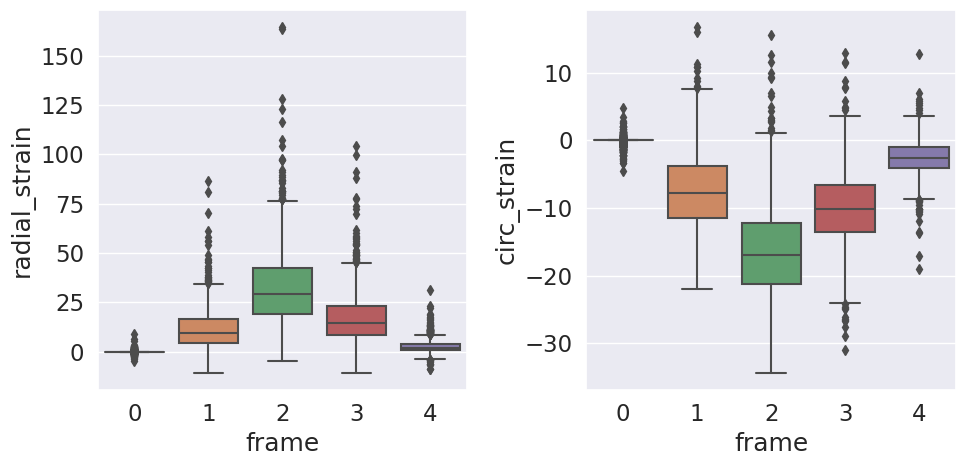

In [8]:
sb.set_context('paper')
sb.set(font_scale = 1.5)
fig, (ax, ax1) = plt.subplots(1,2,figsize=(10,5))
sb.boxplot(x="frame", y="radial_strain",
                 data=df_melt,
              ax=ax)

sb.boxplot(x="frame", y="circ_strain",
                 data=df_melt,
              ax=ax1)
plt.tight_layout()
plt.show()

In [9]:
# load meta
path_to_df_meta = '/mnt/ssd2/data/dmd/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase.csv'
df_meta = pd.read_csv(path_to_df_meta)
df_meta = df_meta.loc[:, ~df_meta.columns.str.contains('^Unnamed')]
df_meta['patient'] = df_meta['patient'].str.lower().str.ljust(11, '0')
df_meta.head()

Participant Number             Name  \
0                 1.0  AC_20180301_DMD   
1                 2.0  AA_20181211_DMD   
2                 3.0  AO_20191212_DMD   
3                 4.0  AA_20180710_DMD   
4                 5.0  AB_20180710_DMD   

  Tarique -visual wall motion abnormality? AHA segments  \
0                                        Y   9, 10 , 11   
1                                        Y           11   
2                                        N            0   
3                                        N            0   
4                                        Y           11   

  Tarique -strain abnormality? AHA segment from strain if different  \
0                            Y                                    0   
1                            N                                    0   
2                            Y                                   10   
3                            N                                    0   
4                            Y                                    0   

   Unique ID           Study Date  Age at MRI Gender  ...  Steroid use (y/n)  \
0  8381562.0  2018-03-01 00:00:00   12.344444      M  ...                  Y   
1  2073764.0  2018-12-11 00:00:00    8.788889      M  ...                  Y   
2  5381412.0  2019-12-12 00:00:00   15.852778      M  ...                  Y   
3  6223189.0  2018-07-10 00:00:00    9.566667      M  ...                  Y   
4  2883132.0  2018-07-10 00:00:00   12.950000      M  ...                  Y   

   Use of any ACE-I/ ARB/ MRA/ beta-blockers (y/n)  ACE-I use?   ARB use?  \
0                                                Y            Y         N   
1                                                Y            Y         N   
2                                                Y            Y         N   
3                                                Y            Y         N   
4                                                Y            Y         N   

   MRA use?  Beta-blocker use?    Specific Steroid and Dose  \
0         Y                  N                prednisone 20   
1         N                  N  prednisone 60 Fri, Sat, Sun   
2         Y                  Y                prednisone 15   
3         N                  Y       prednisone 60, Fri-Sun   
4         N                  N        prednisone 70 Fri-Sun   

                              ACE-I/ARB/BB/MRA doses  \
0               enalipril 2.5 BID, sprionolactone 25   
1                                      lisinopril 10   
2  spironolactone 50, lisinopril 10, carvedilol 3...   
3                    carvedilol 6.25, lisiniopril 10   
4                                      lisinopril 20   

                                   Other Medications      patient  
0  ranitidine 150mg, Vit D3 5000 units, albuterol...  ac_20180301  
1                                    VitD 4000 units  aa_20181211  
2  famotidine 10 BID, VitD3 6000 units, sertralin...  ao_20191212  
3    ranitidine 150 Fri-Sun, Vit D3 4000 units daily  aa_20180710  
4                   esomeprazole 10, Vit D3 2000 BID  ab_20180710  

[5 rows x 52 columns]

In [10]:
df_merged = pd.merge(left=df_melt, right=df_meta, how='left', left_on='pat', right_on='patient')
df_merged['target'] = df_merged['LGE present? (y/n)']
df_merged.head()

pat  aha frame  radial_strain  circ_strain  Participant Number  \
0  aa_20180710    1     0            0.0          0.0                 4.0   
1  aa_20180710    2     0            0.0          0.0                 4.0   
2  aa_20180710    3     0            0.0          0.0                 4.0   
3  aa_20180710    4     0            0.0          0.0                 4.0   
4  aa_20180710    5     0            0.0          0.0                 4.0   

              Name Tarique -visual wall motion abnormality? AHA segments  \
0  AA_20180710_DMD                                        N            0   
1  AA_20180710_DMD                                        N            0   
2  AA_20180710_DMD                                        N            0   
3  AA_20180710_DMD                                        N            0   
4  AA_20180710_DMD                                        N            0   

  Tarique -strain abnormality?  ...  \
0                            N  ...   
1                            N  ...   
2                            N  ...   
3                            N  ...   
4                            N  ...   

  Use of any ACE-I/ ARB/ MRA/ beta-blockers (y/n)  ACE-I use?  ARB use?  \
0                                               Y            Y        N   
1                                               Y            Y        N   
2                                               Y            Y        N   
3                                               Y            Y        N   
4                                               Y            Y        N   

   MRA use? Beta-blocker use?  Specific Steroid and Dose  \
0         N                 Y     prednisone 60, Fri-Sun   
1         N                 Y     prednisone 60, Fri-Sun   
2         N                 Y     prednisone 60, Fri-Sun   
3         N                 Y     prednisone 60, Fri-Sun   
4         N                 Y     prednisone 60, Fri-Sun   

            ACE-I/ARB/BB/MRA doses  \
0  carvedilol 6.25, lisiniopril 10   
1  carvedilol 6.25, lisiniopril 10   
2  carvedilol 6.25, lisiniopril 10   
3  carvedilol 6.25, lisiniopril 10   
4  carvedilol 6.25, lisiniopril 10   

                                 Other Medications      patient  target  
0  ranitidine 150 Fri-Sun, Vit D3 4000 units daily  aa_20180710       N  
1  ranitidine 150 Fri-Sun, Vit D3 4000 units daily  aa_20180710       N  
2  ranitidine 150 Fri-Sun, Vit D3 4000 units daily  aa_20180710       N  
3  ranitidine 150 Fri-Sun, Vit D3 4000 units daily  aa_20180710       N  
4  ranitidine 150 Fri-Sun, Vit D3 4000 units daily  aa_20180710       N  

[5 rows x 58 columns]

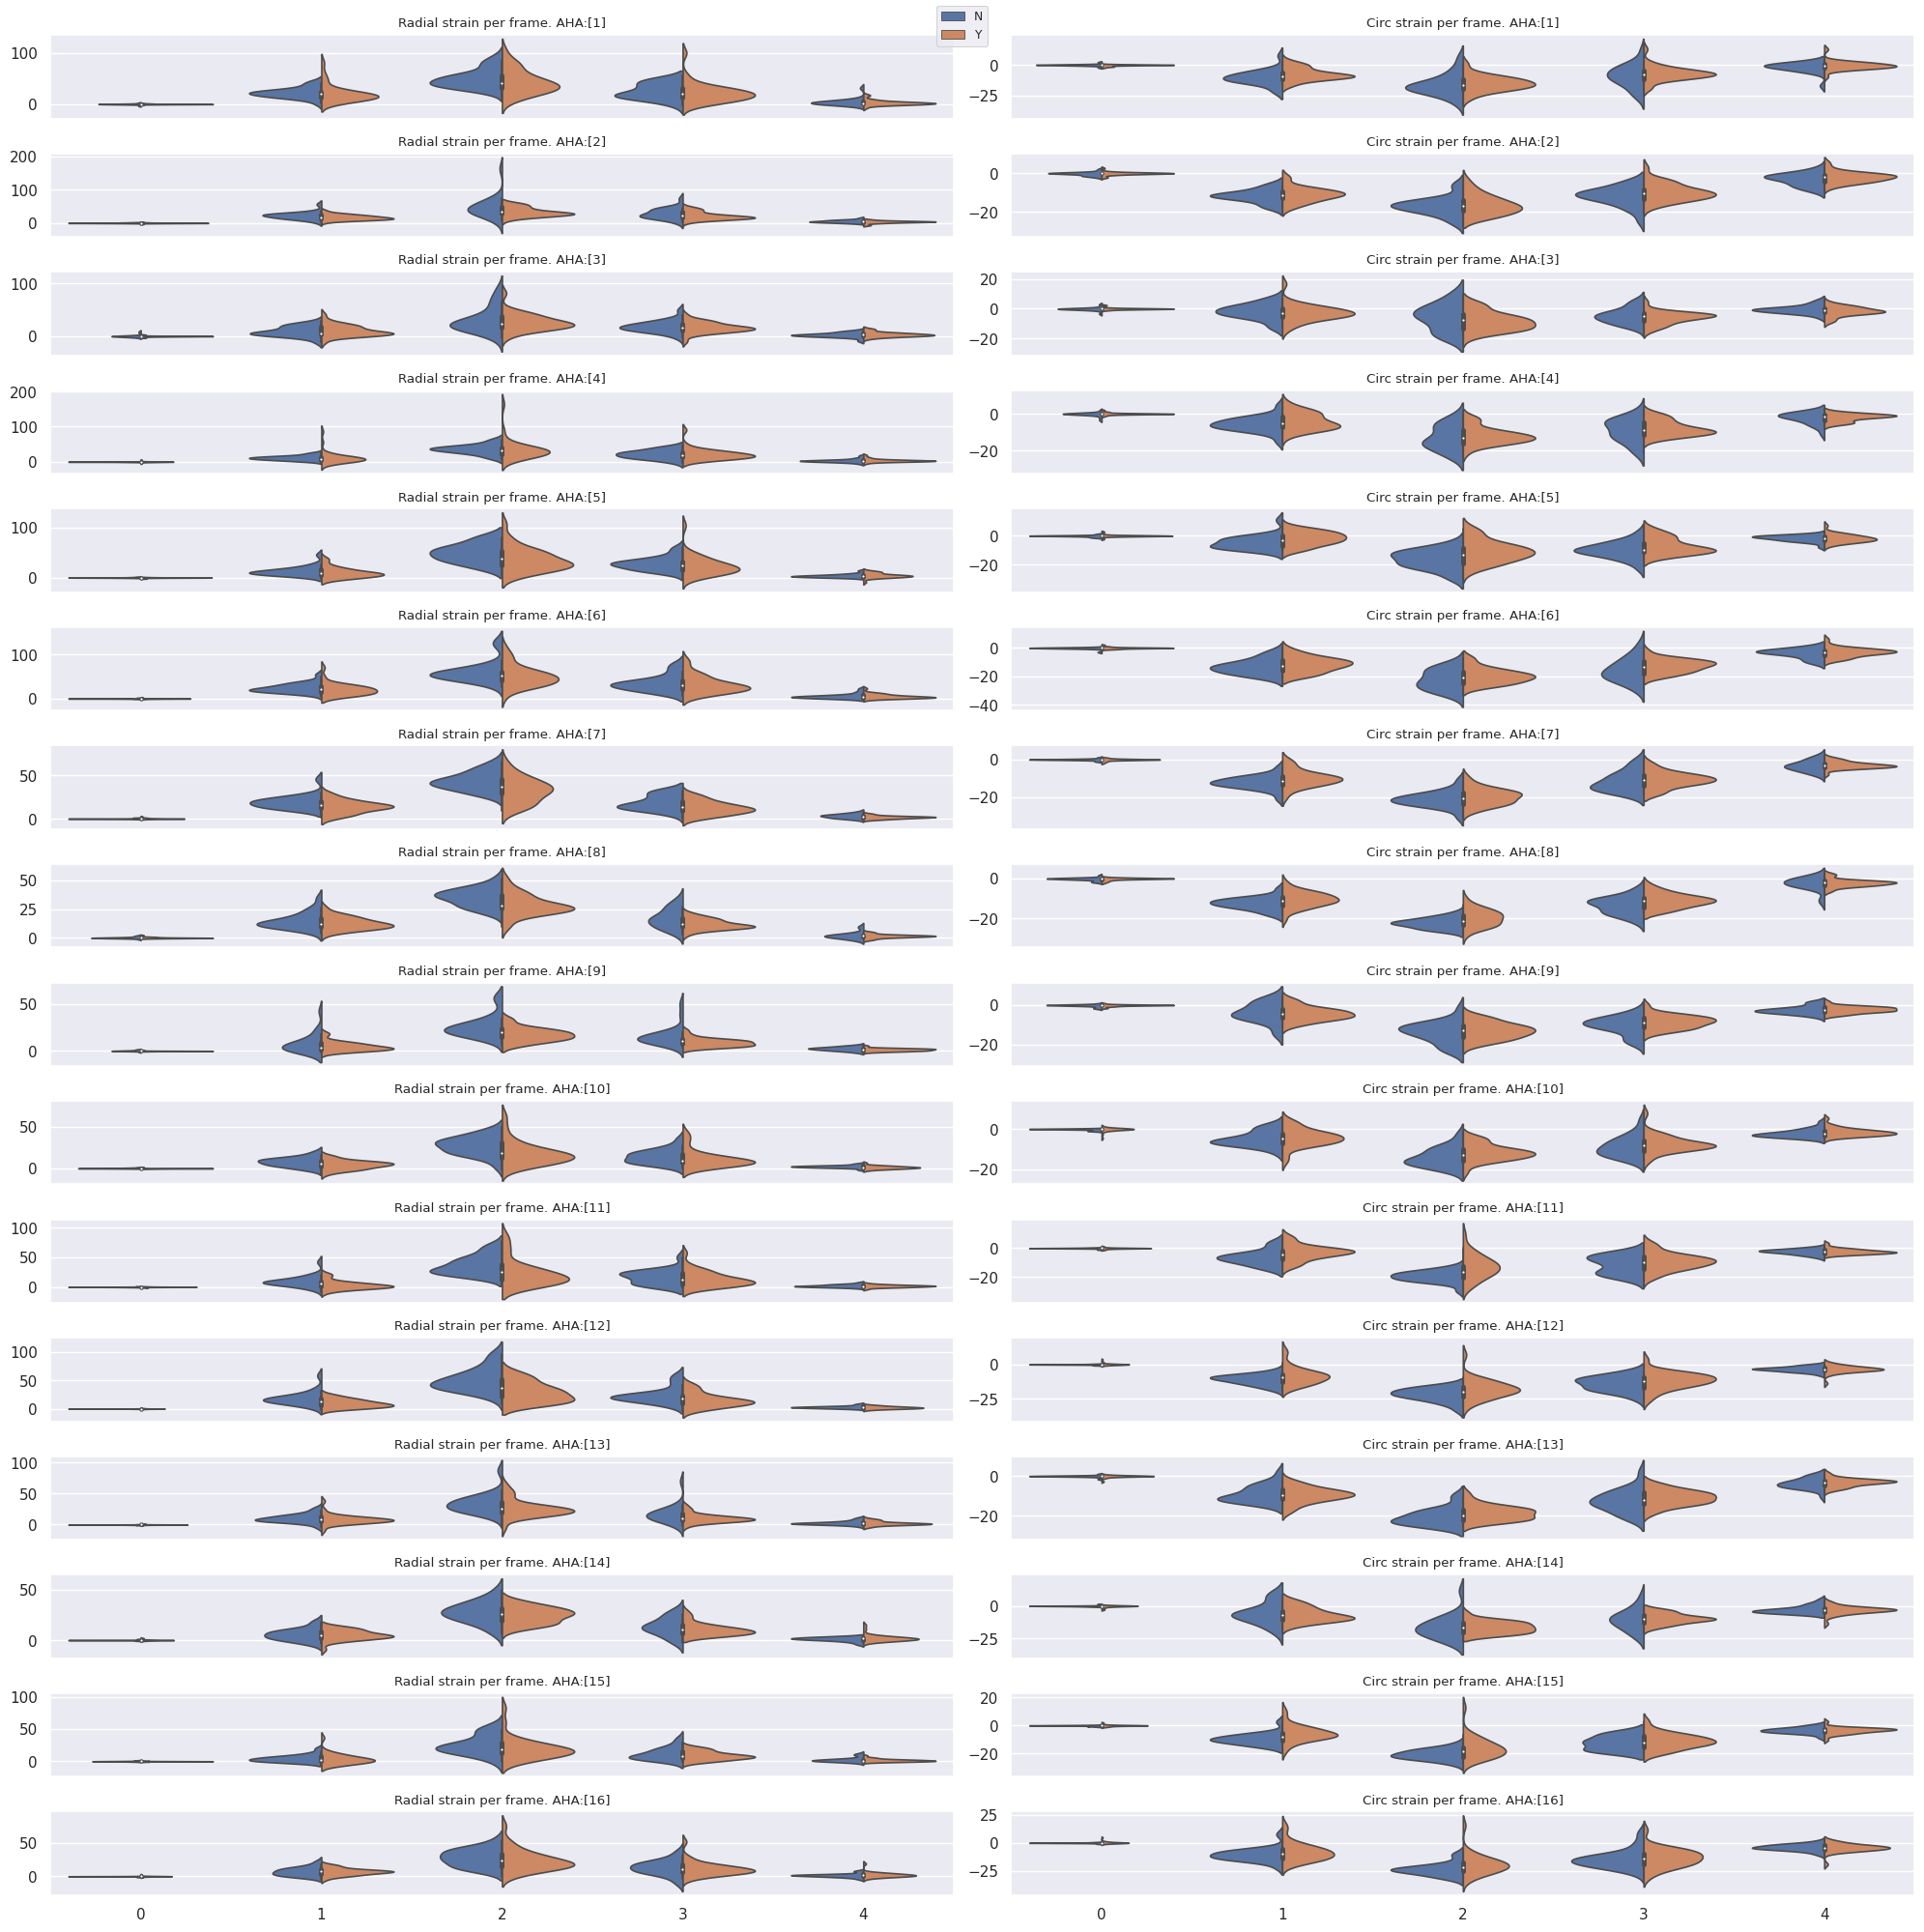

In [13]:
def plot_strain(df, segments=[1], ax=None, ax1=None, show_xlabel=False):
    sb.set_context('paper')
    #sb.set(font_scale = 1.5)
    if ax is None:
        fig, (ax, ax1) = plt.subplots(1,2,figsize=(20,4))
    ax.set_title('Radial strain per frame. AHA:{}'.format(segments))
    ax1.set_title('Circ strain per frame. AHA:{}'.format(segments))
    g1 = sb.violinplot(x="frame", y='radial_strain',
                     data=df[df['aha'].isin(segments)],
                  ax=ax,
                 hue='target',
                 split=True, legend=False)
    g2 = sb.violinplot(x="frame", y='circ_strain',
                     data=df[df['aha'].isin(segments)],
                  ax=ax1,
                 hue='target',
                 split=True)
    
    if show_xlabel:
        pass
    else:
        g1.set(ylabel=None)
        g2.set(ylabel=None)
        g1.set(xlabel=None)
        g2.set(xlabel=None)
        g1.legend([],[],frameon=False)
        g2.legend([],[],frameon=False)
        #g2.set(xticklabels=[])
        #g1.set(xticklabels=[])
    
    
seg_of_interest = 16
sb.set_context('paper')
sb.set(font_scale = 1)
fig, axes = plt.subplots(seg_of_interest,2,figsize=(20,20), sharex=True)
_ = [plot_strain(df_merged, segments=[i], ax=axes[i-1,0], ax1=axes[i-1,1], show_xlabel=i==seg_of_interest+1) for i in range(1,1 + seg_of_interest)]
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')
plt.tight_layout()
plt.savefig('/mnt/ssd2/jcmr2023/circle/strain@frame_per_segment.png')
plt.show()

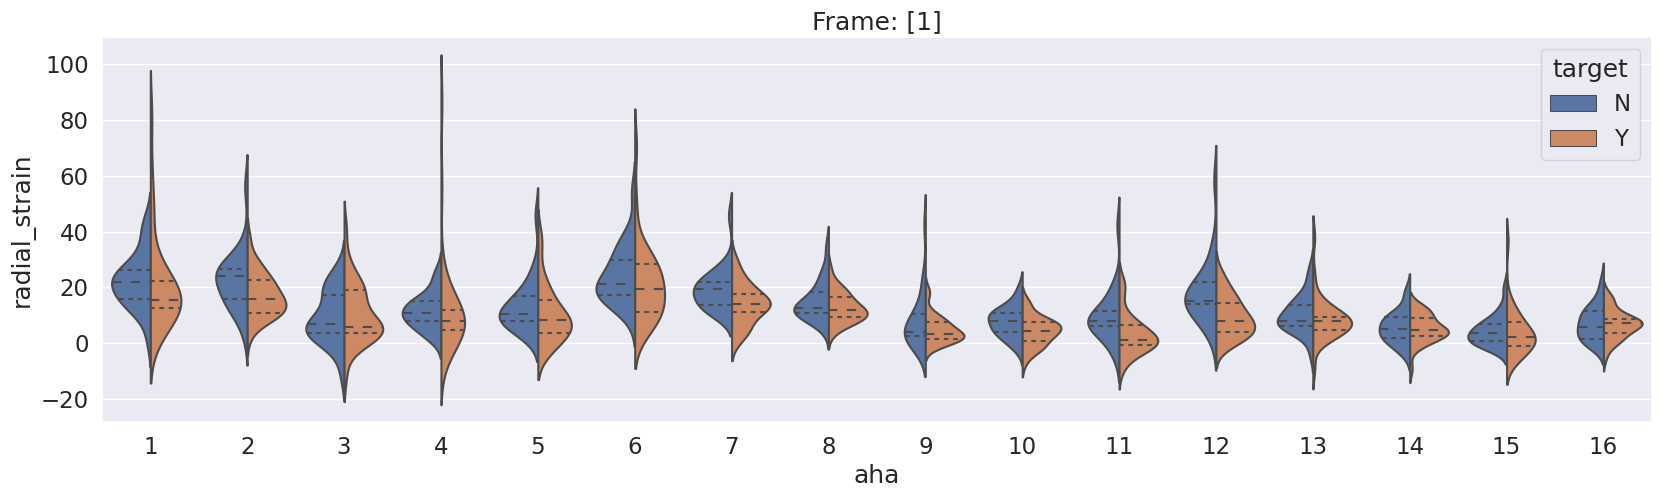

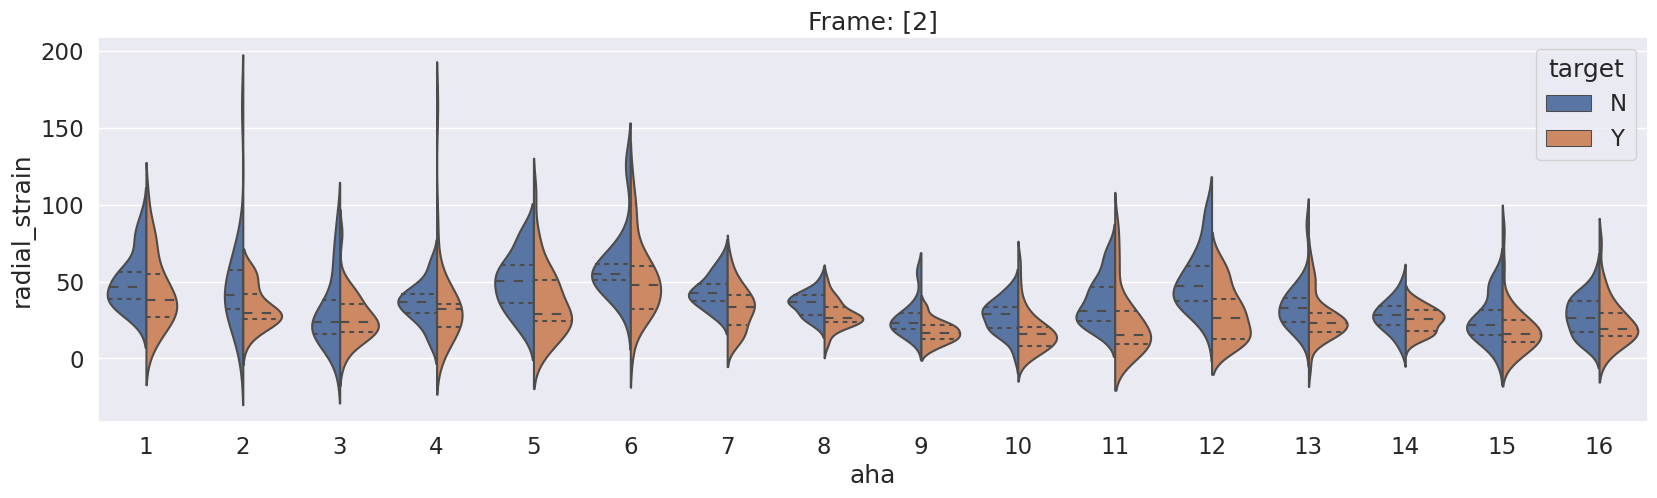

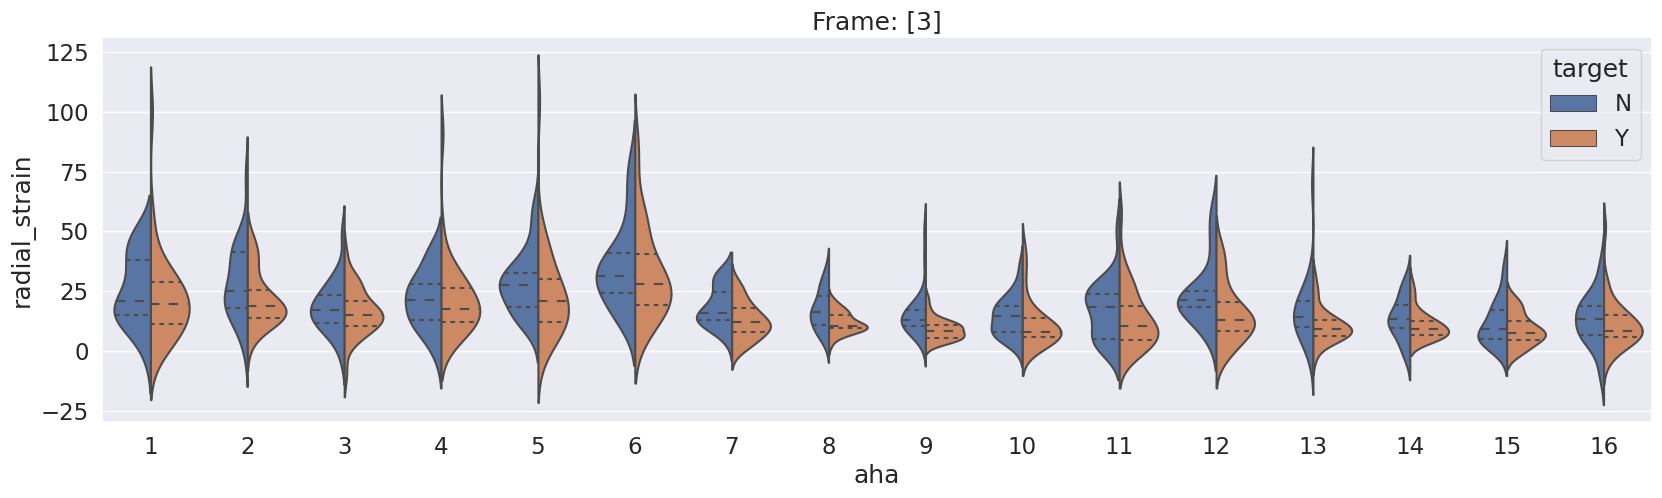

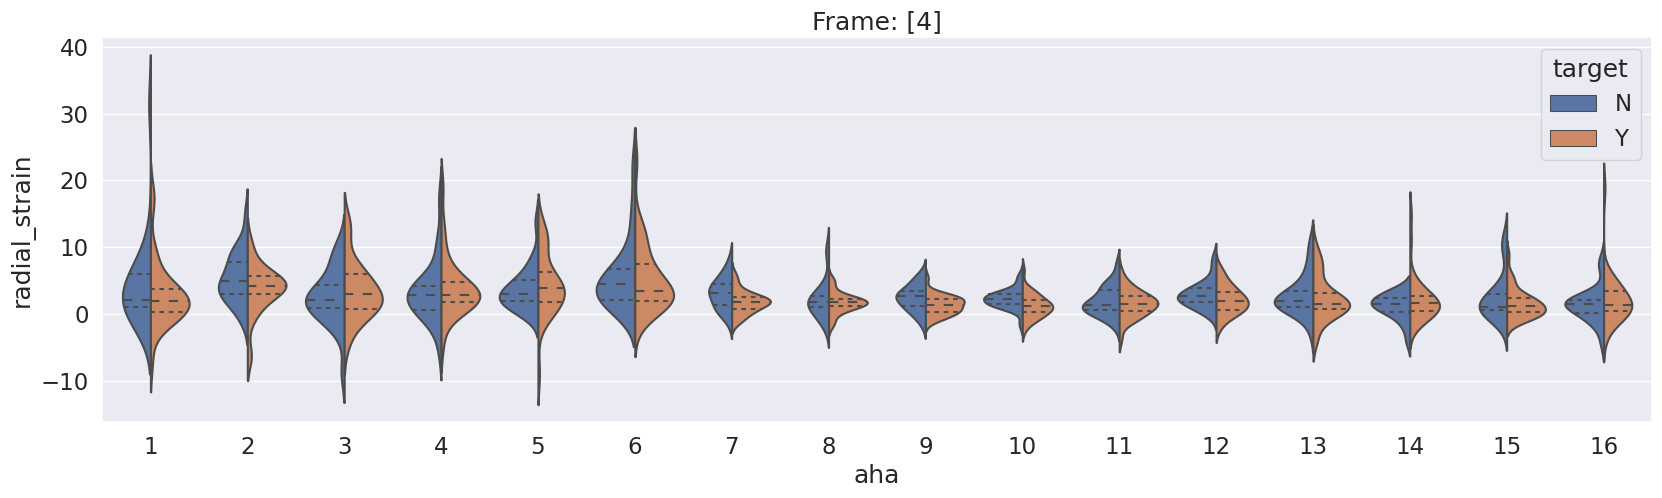

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_6344/1250327862.py", line 12, in <cell line: 12>
    _ = [plot_strain(df_merged, segments=[i]) for i in range(1,30)]
  File "/tmp/ipykernel_6344/1250327862.py", line 12, in <listcomp>
    _ = [plot_strain(df_merged, segments=[i]) for i in range(1,30)]
  File "/tmp/ipykernel_6344/1250327862.py", line 6, in plot_strain
    sb.violinplot(x="aha", y="radial_strain",inner='quart',
  File "/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/seaborn/_decorators.py", line 46, in inner_f
    return f(**kwargs)
  File "/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/seaborn/categorical.py", line 2397, in violinplot
    plotter = _ViolinPlotter(x, y, hue, data, order, hue_order,
  File "/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/s

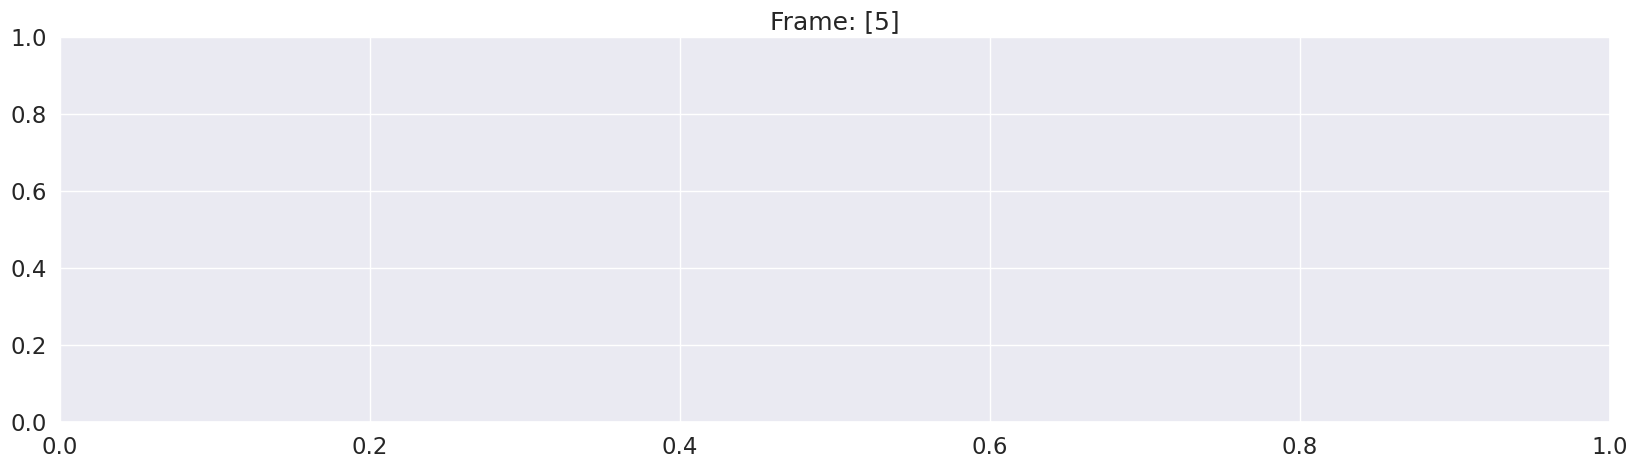

In [12]:
def plot_strain(df, segments=[1]):
    sb.set_context('paper')
    sb.set(font_scale = 1.5)
    fig, ax = plt.subplots(1,1,figsize=(20,5))
    plt.title('Frame: {}'.format(segments))
    sb.violinplot(x="aha", y="radial_strain",inner='quart',
                     data=df[df['frame'].isin(segments)],
                  ax=ax,
                 hue='target',
                 split=True
                 );plt.show()
_ = [plot_strain(df_merged, segments=[i]) for i in range(1,30)]

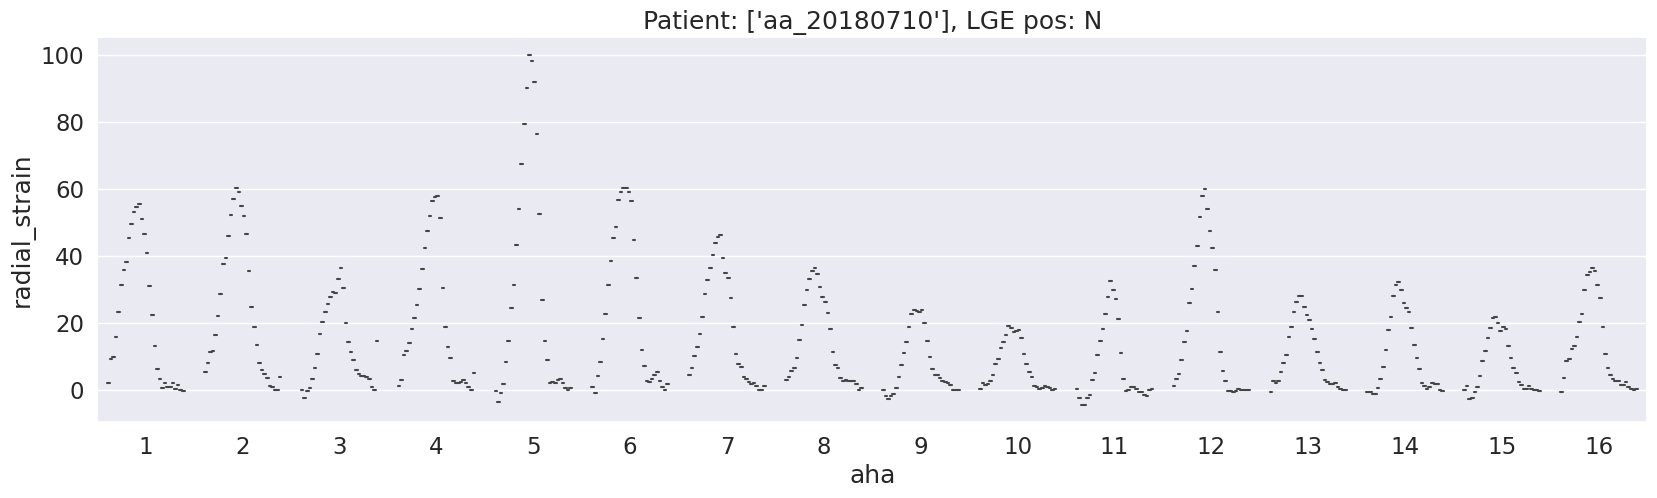

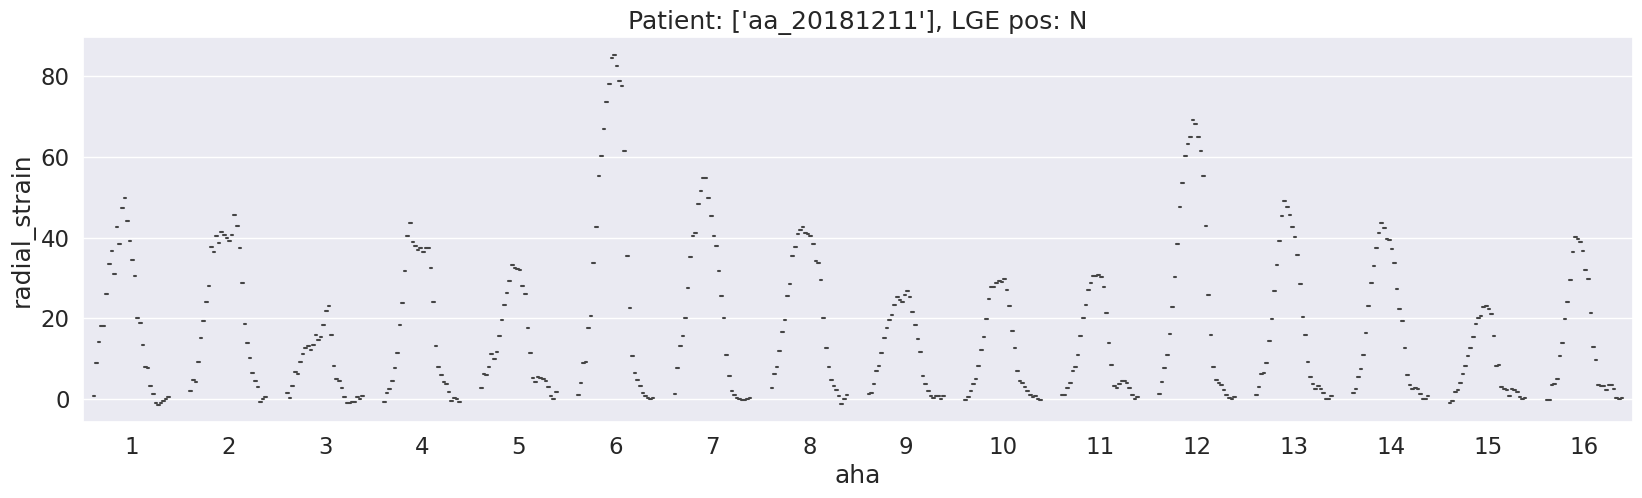

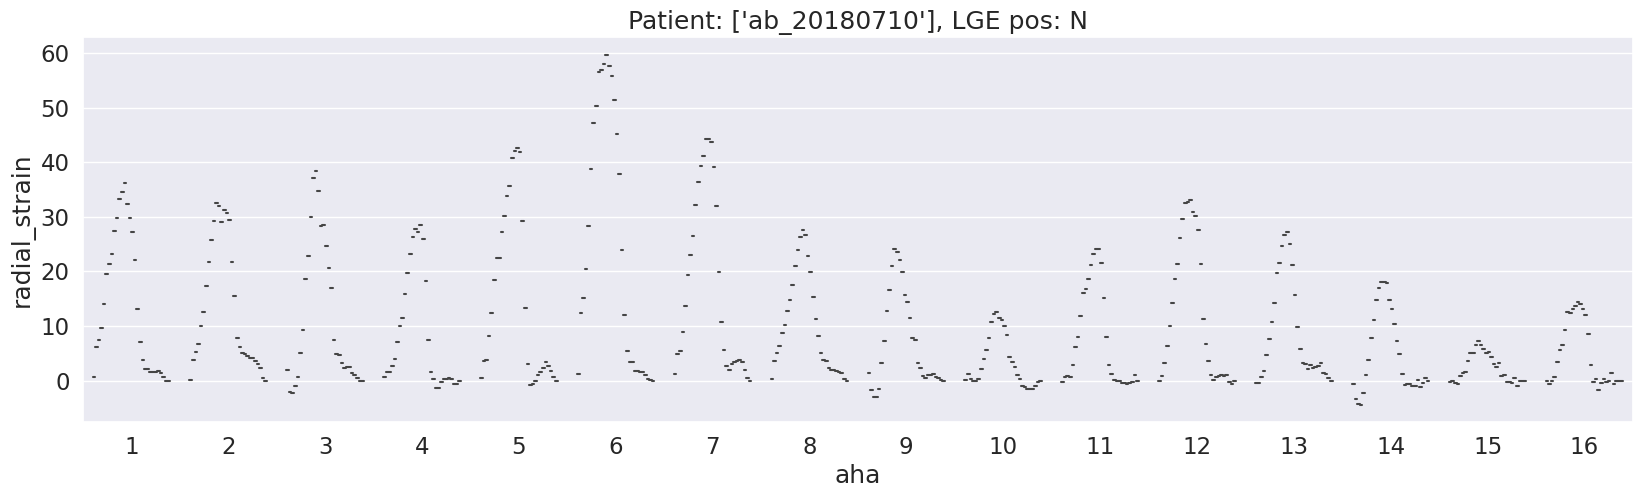

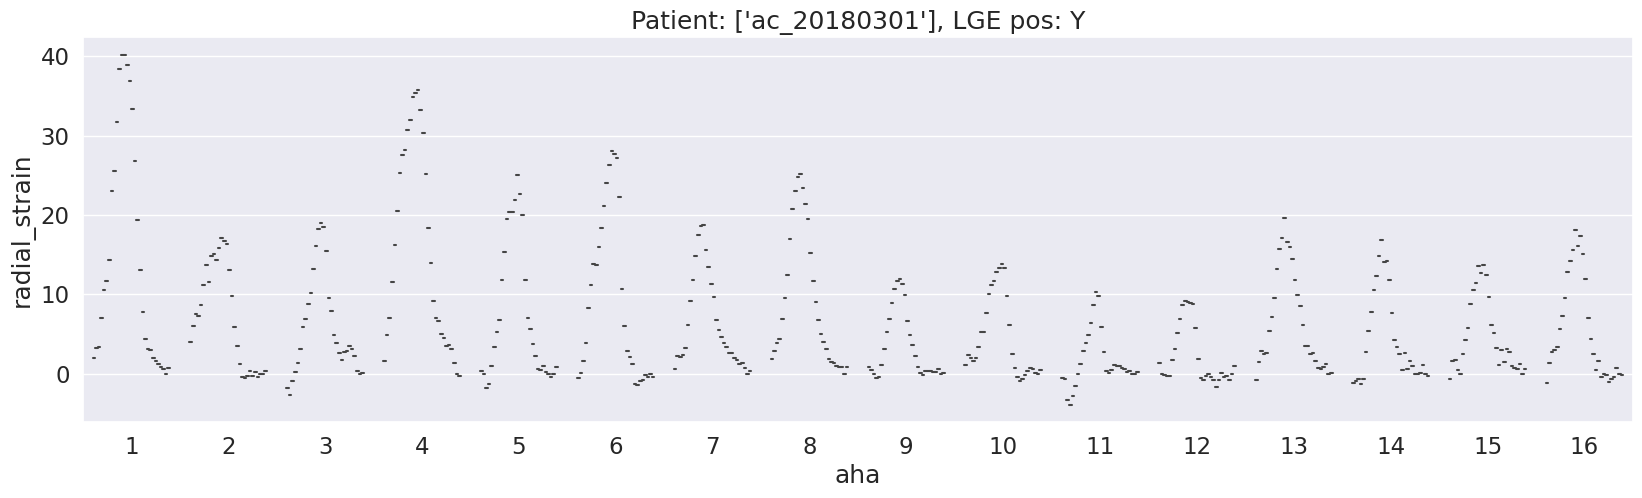

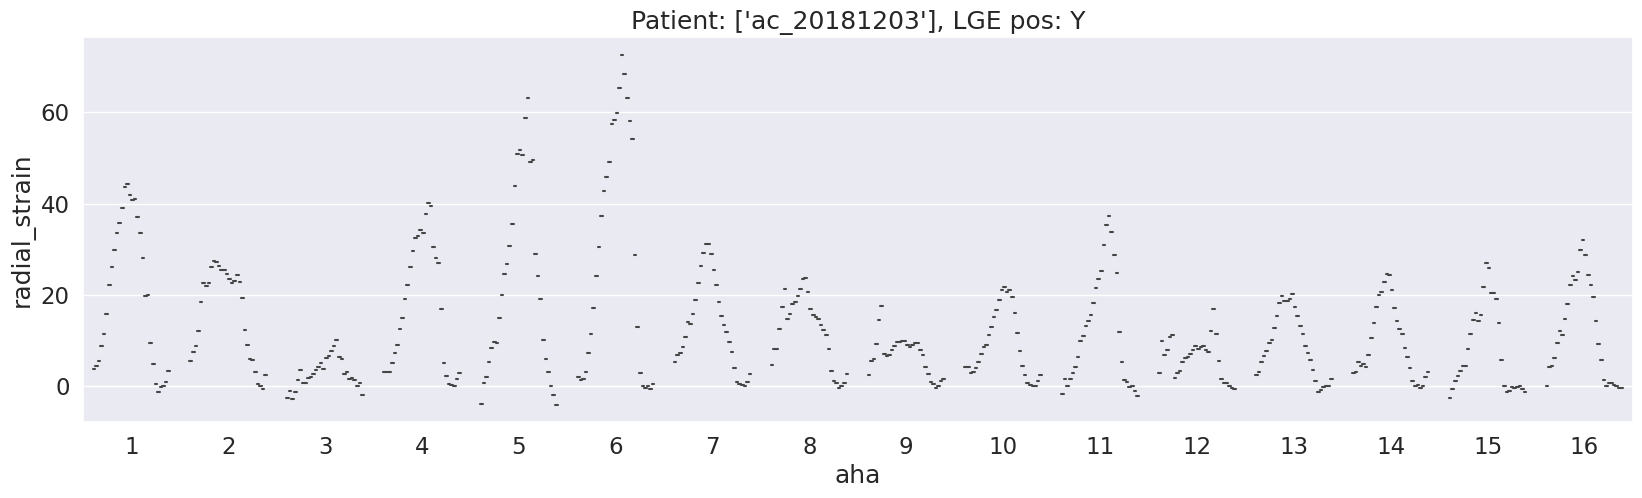

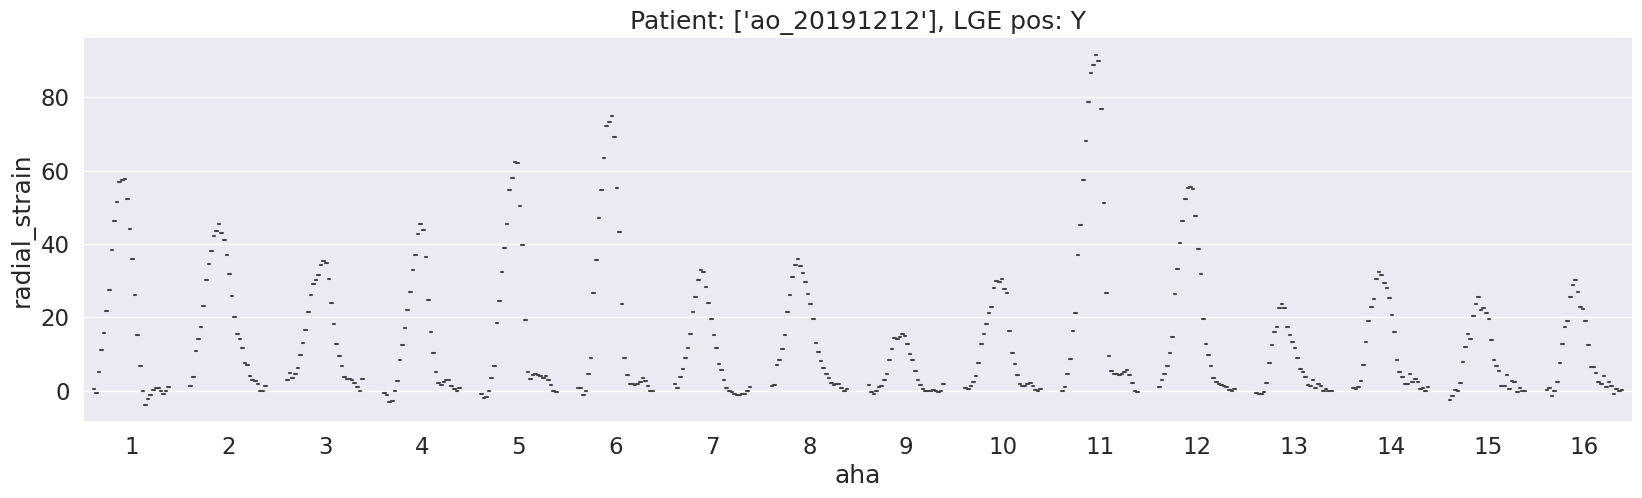

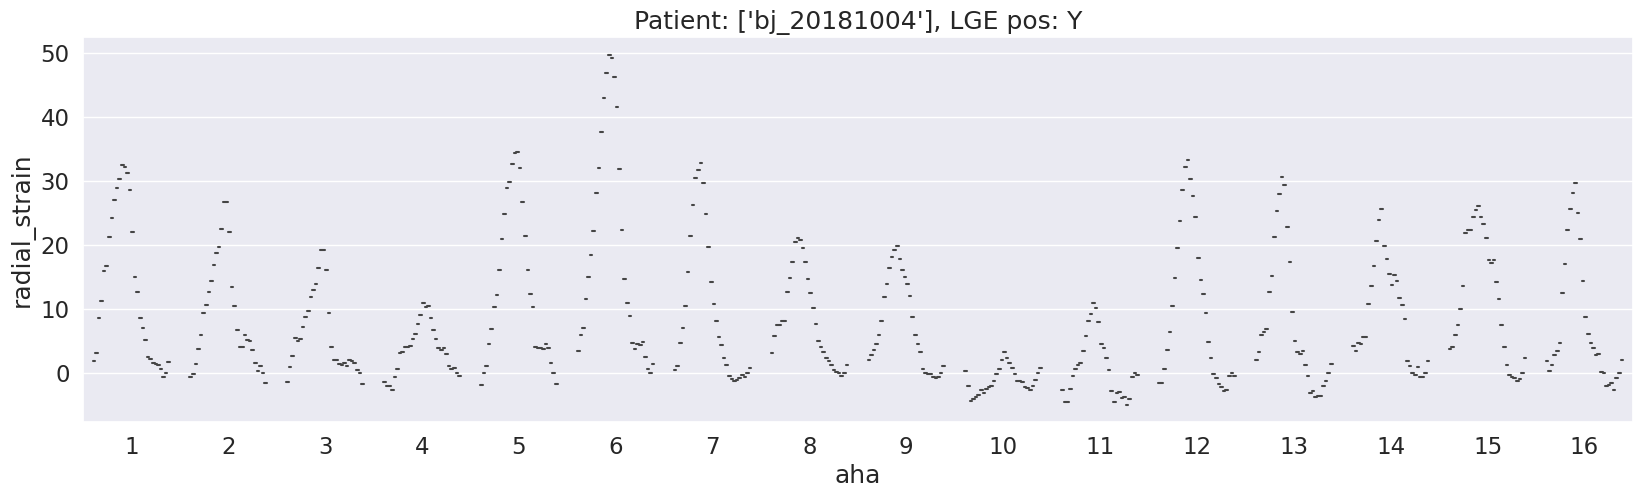

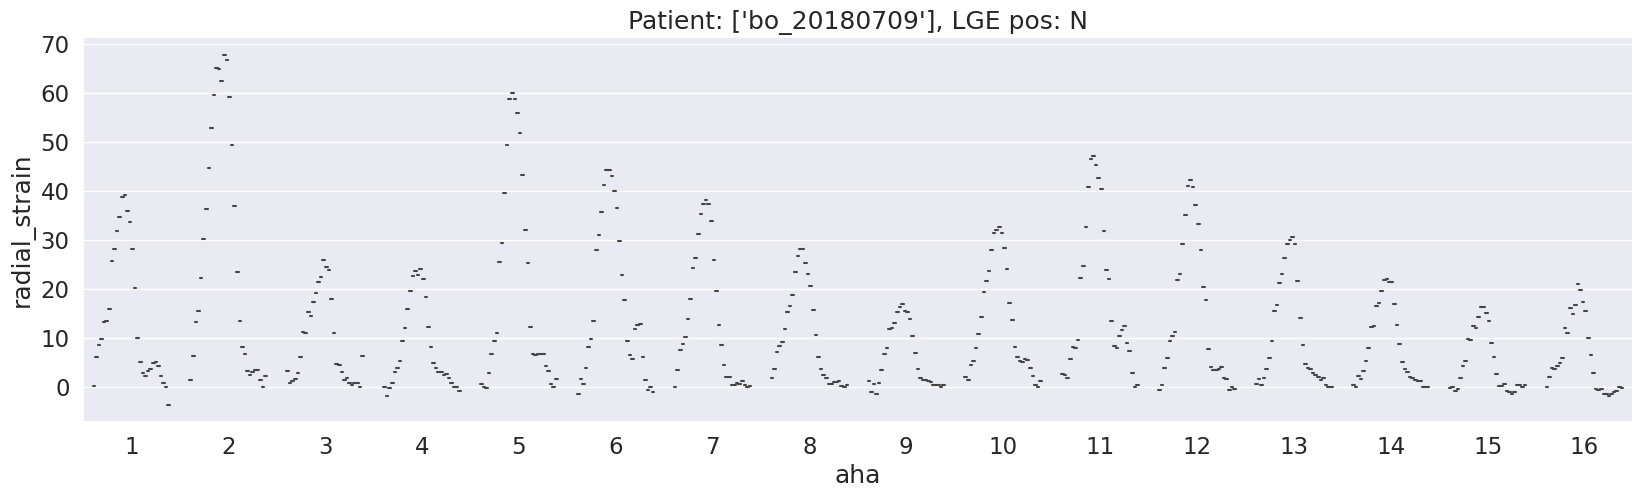

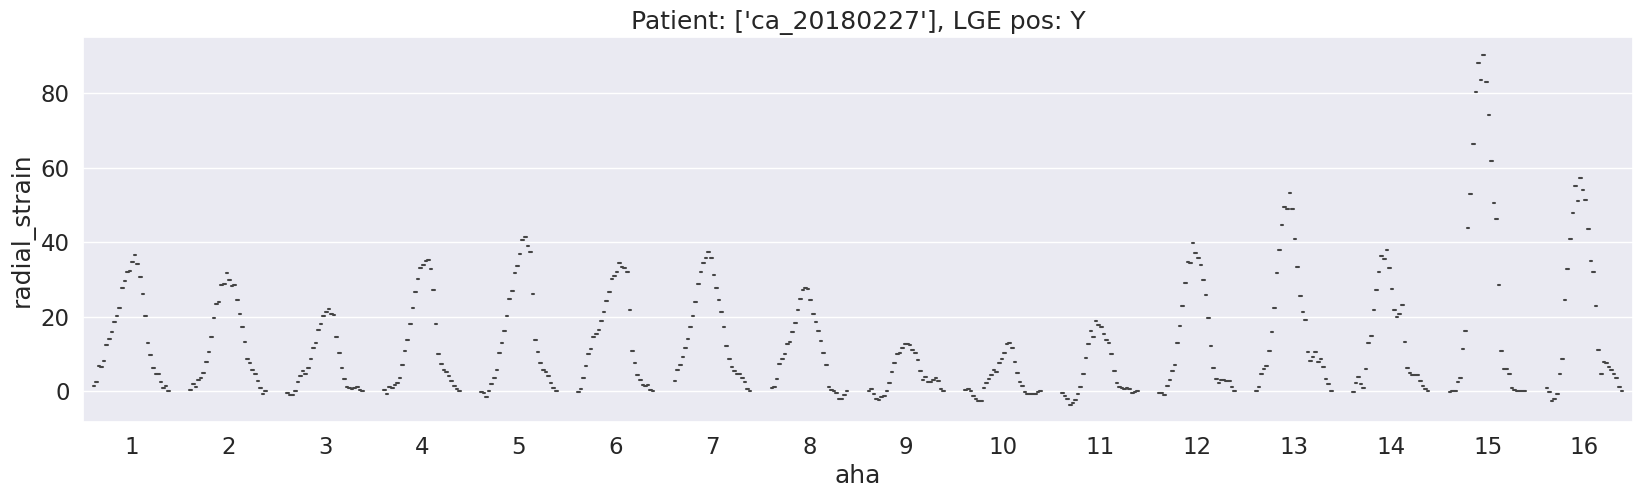

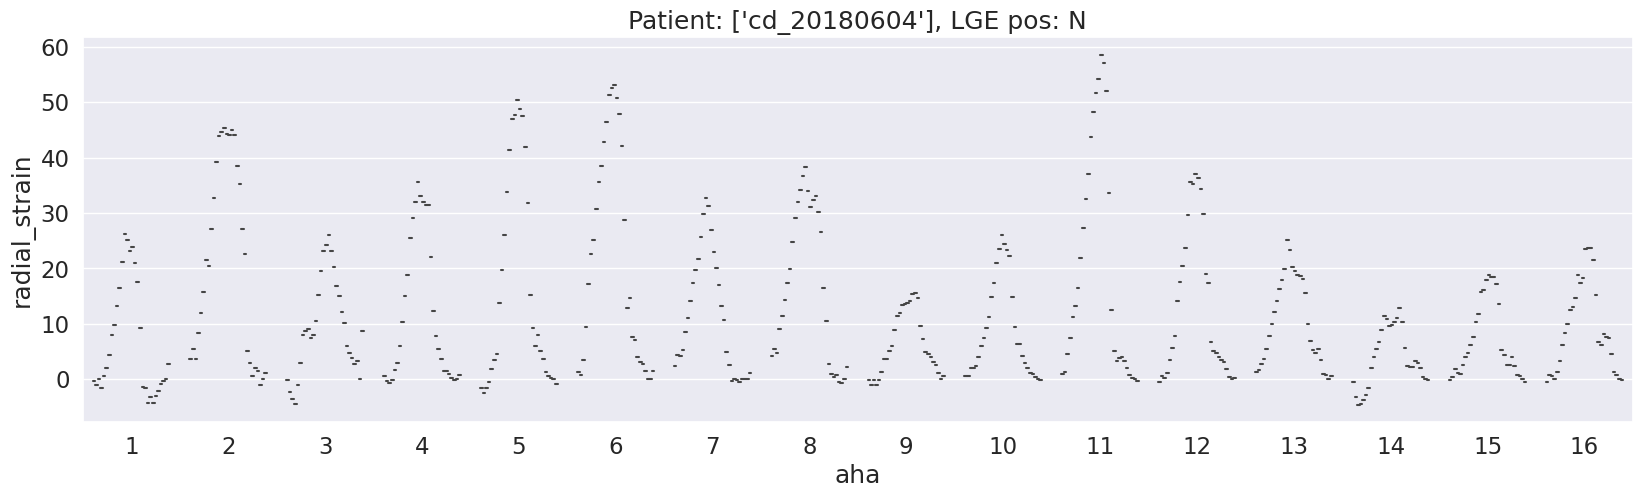

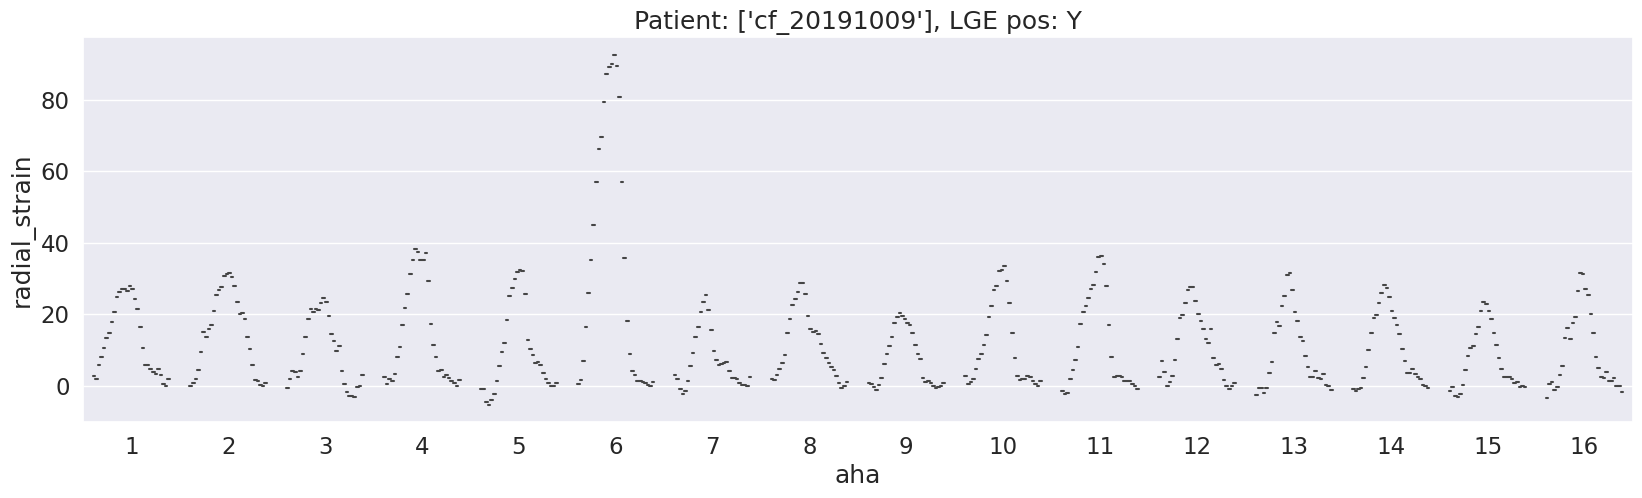

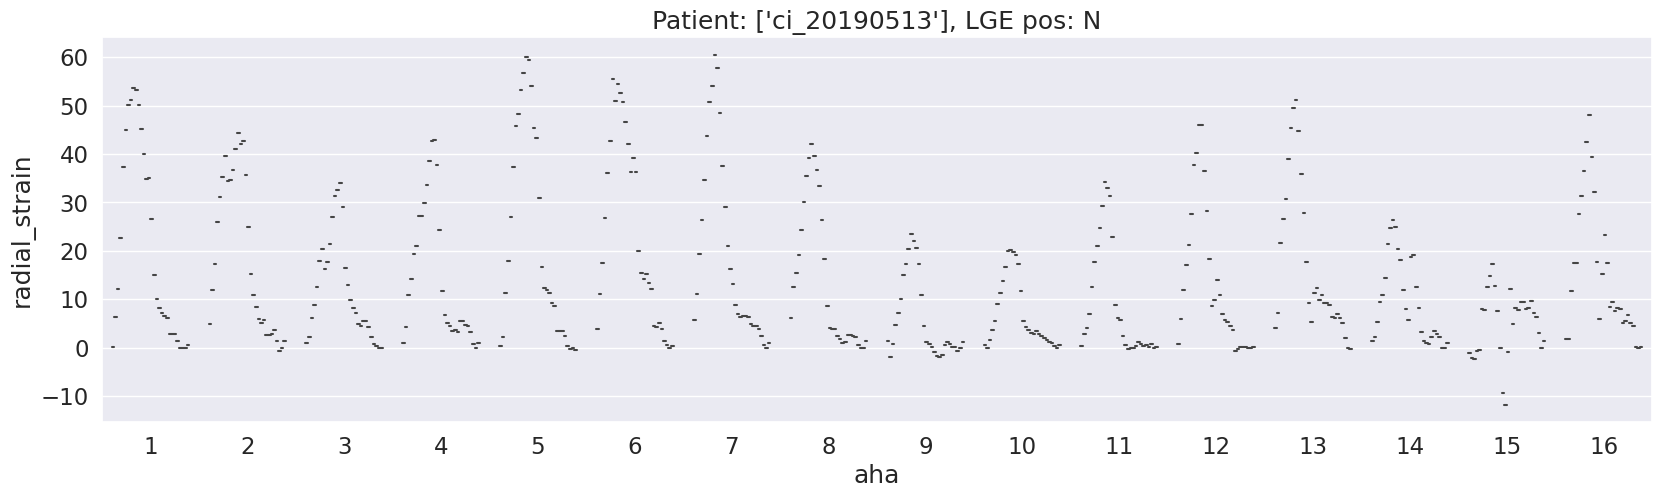

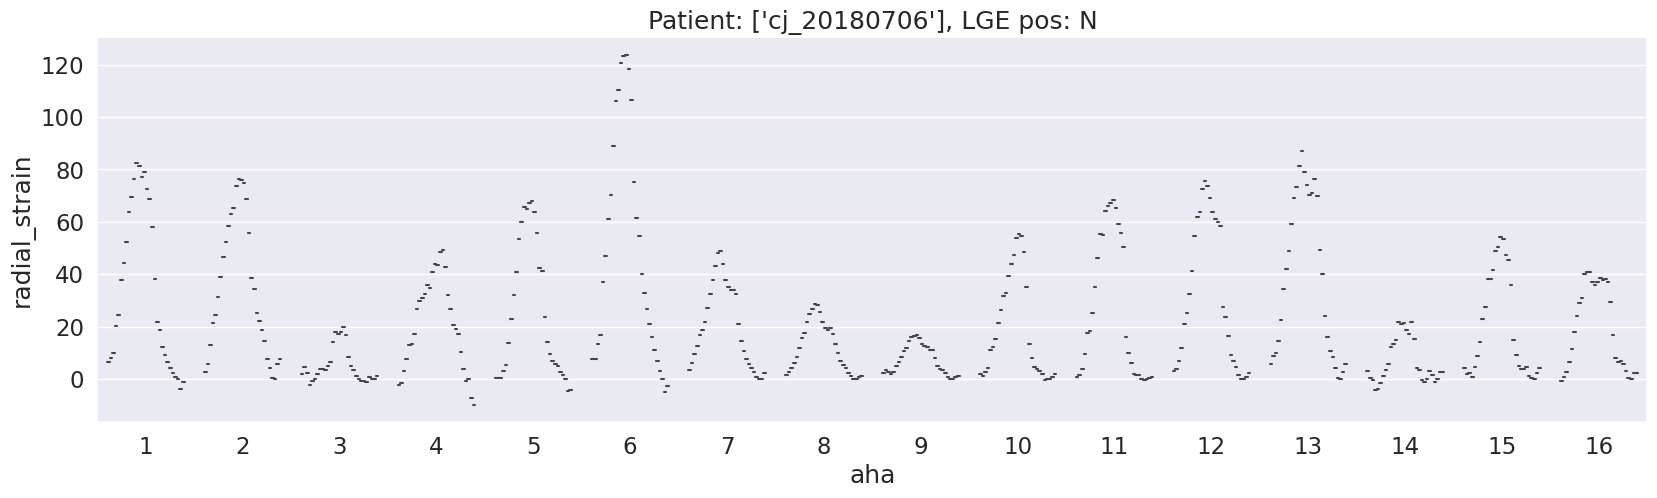

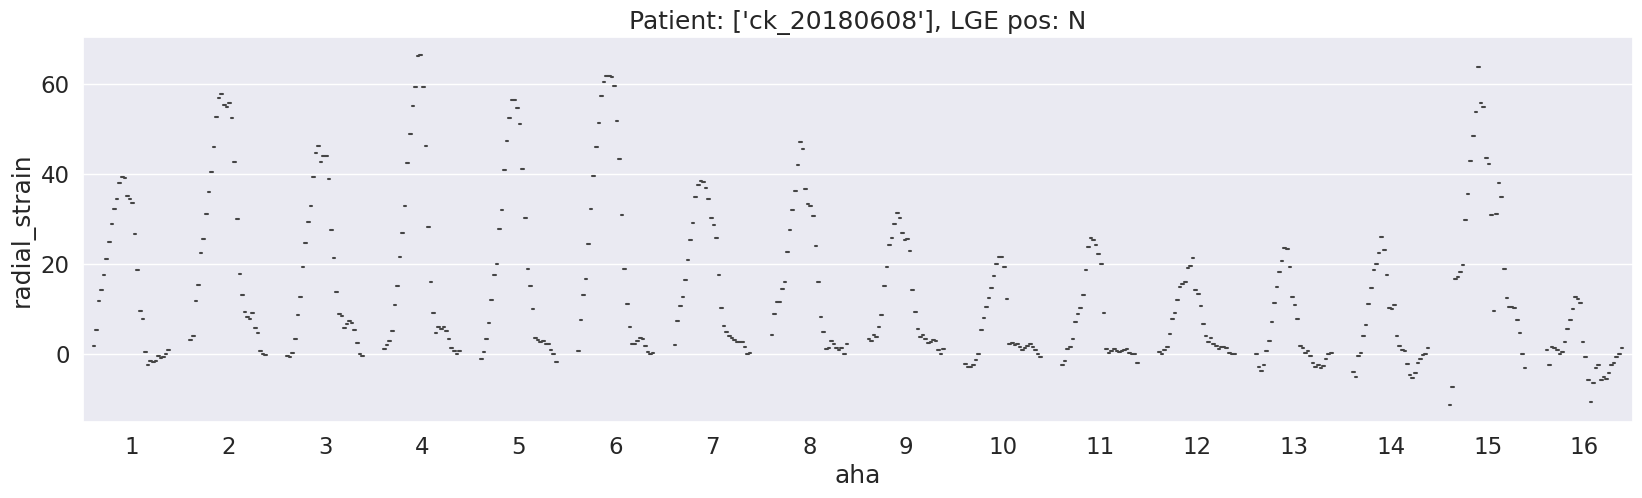

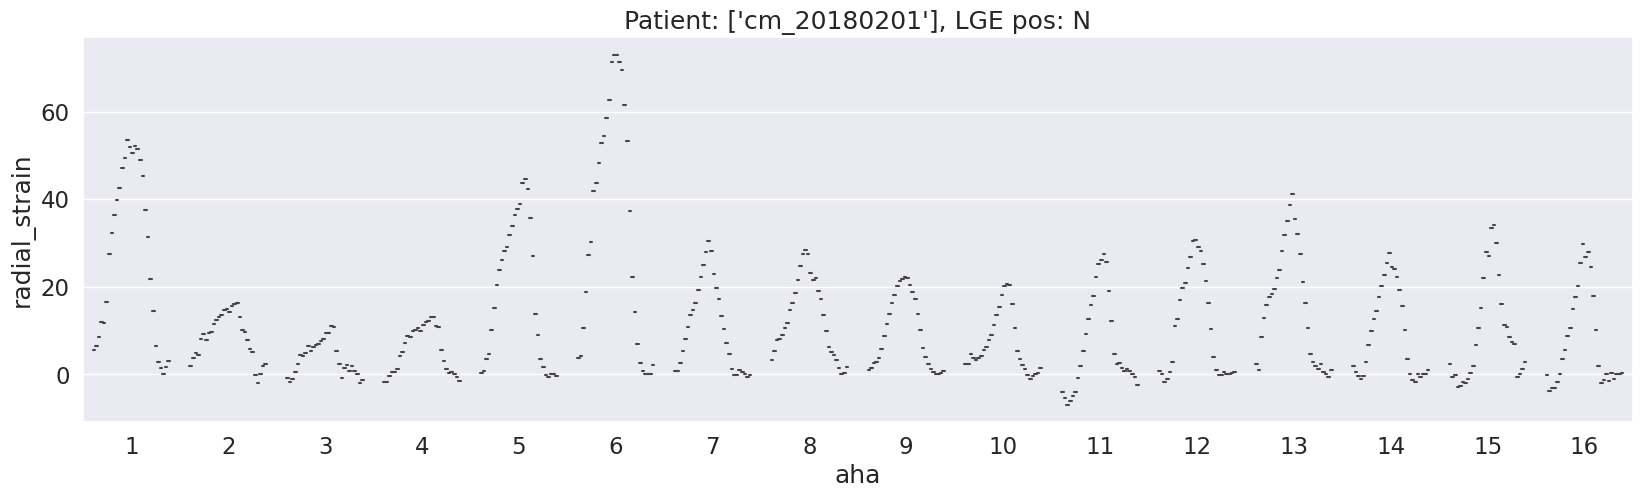

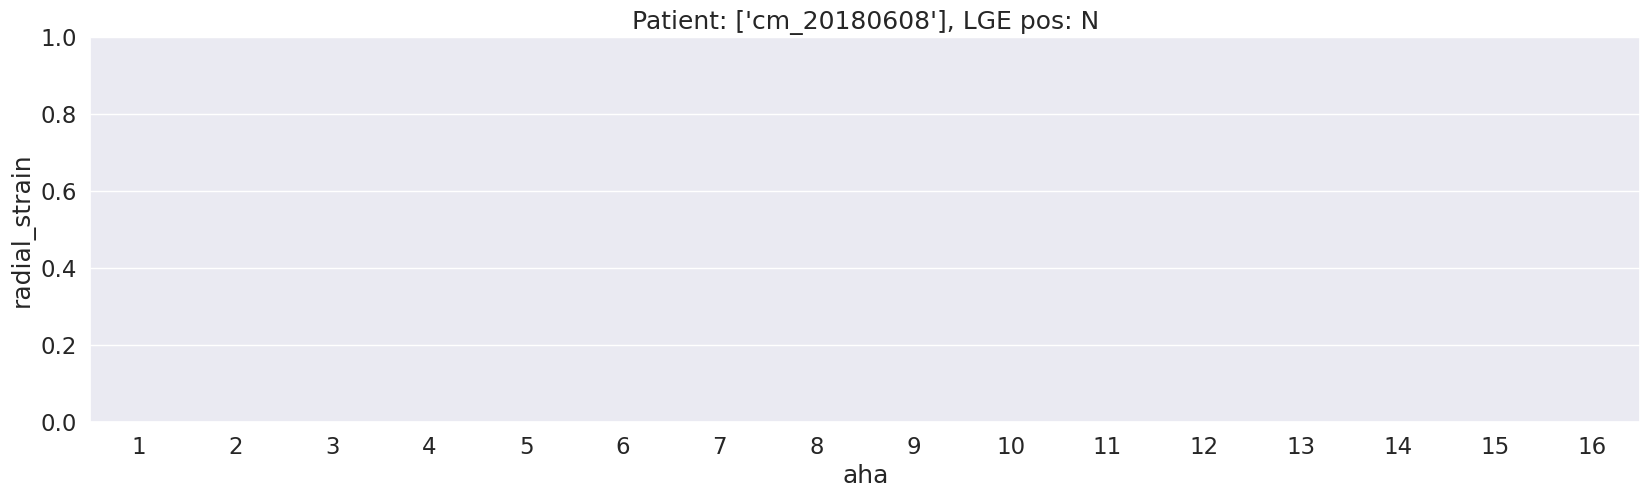

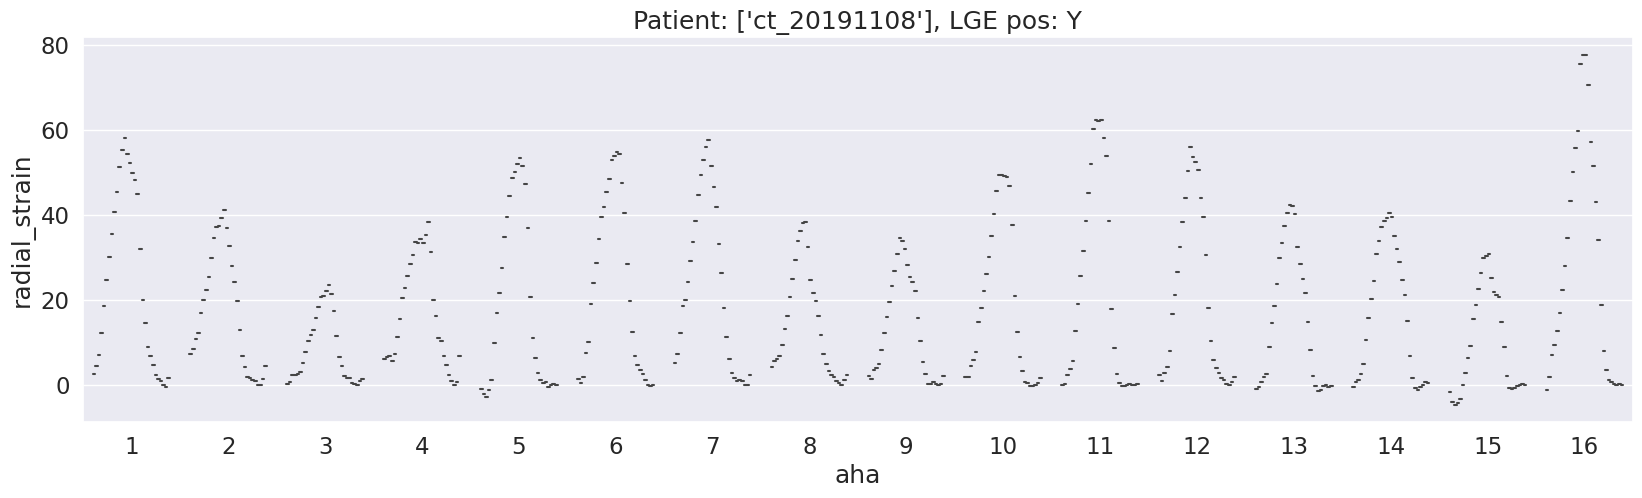

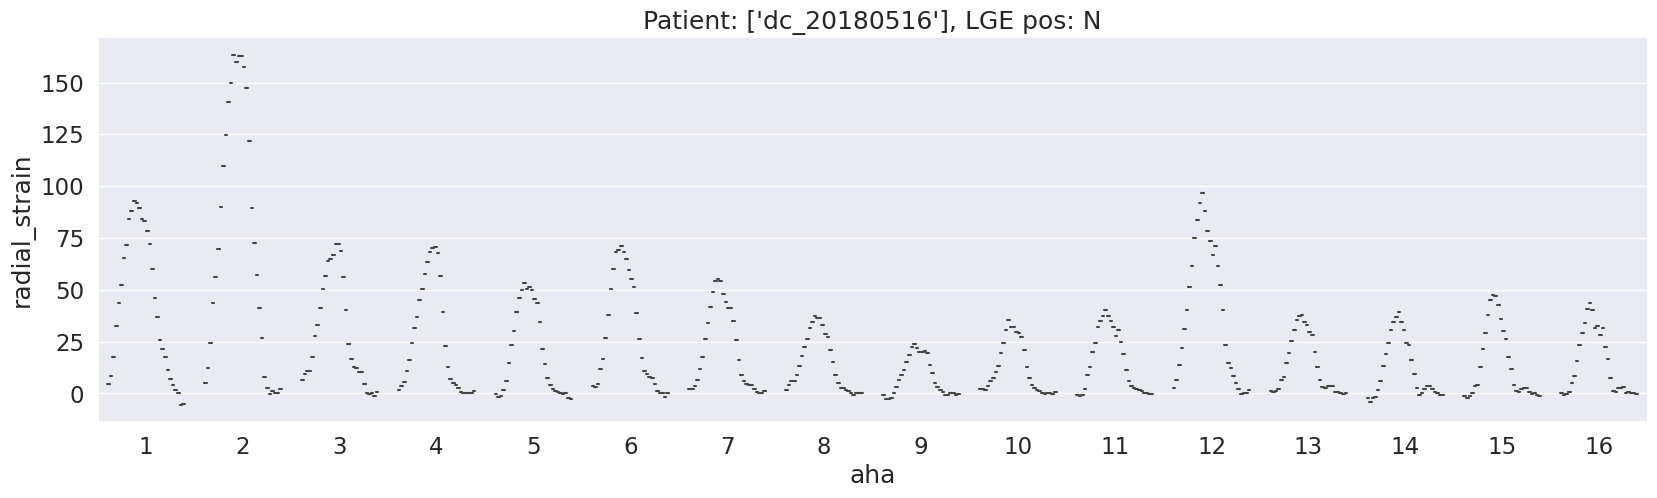

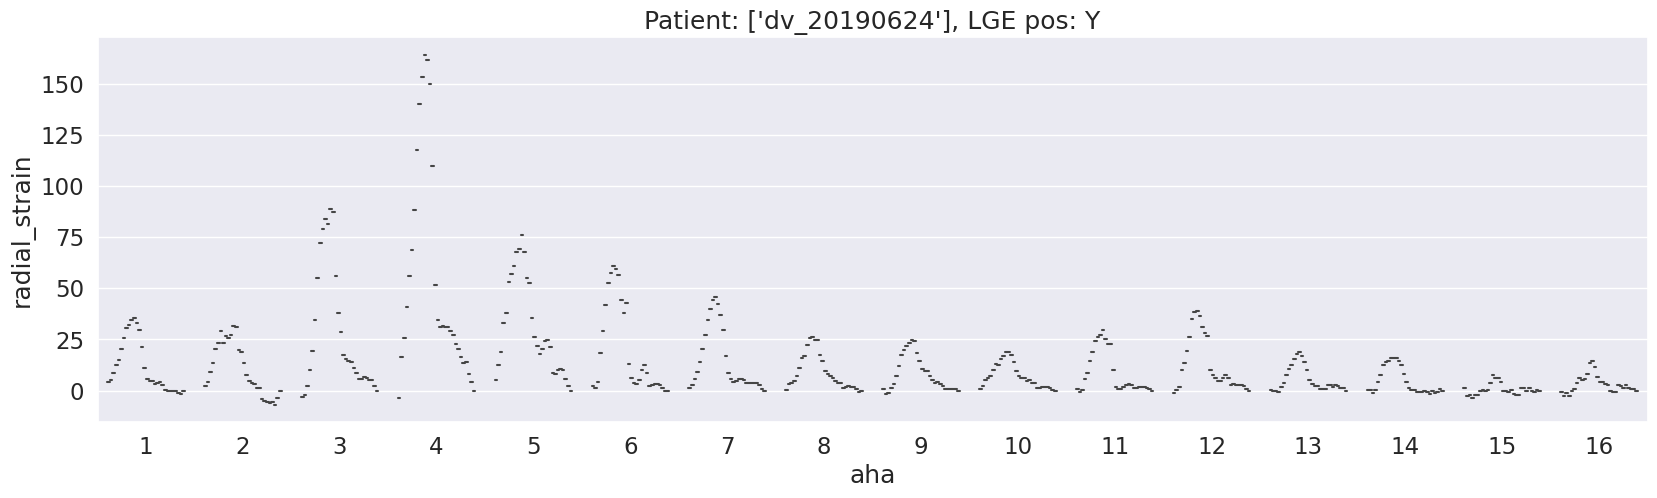

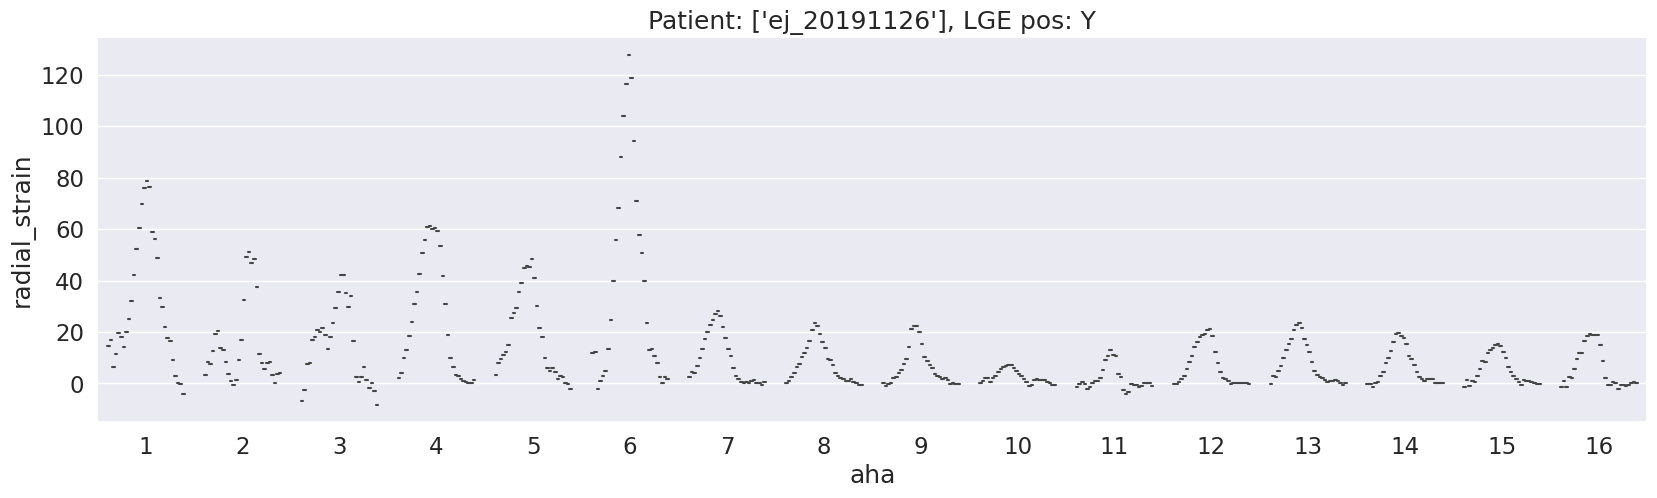

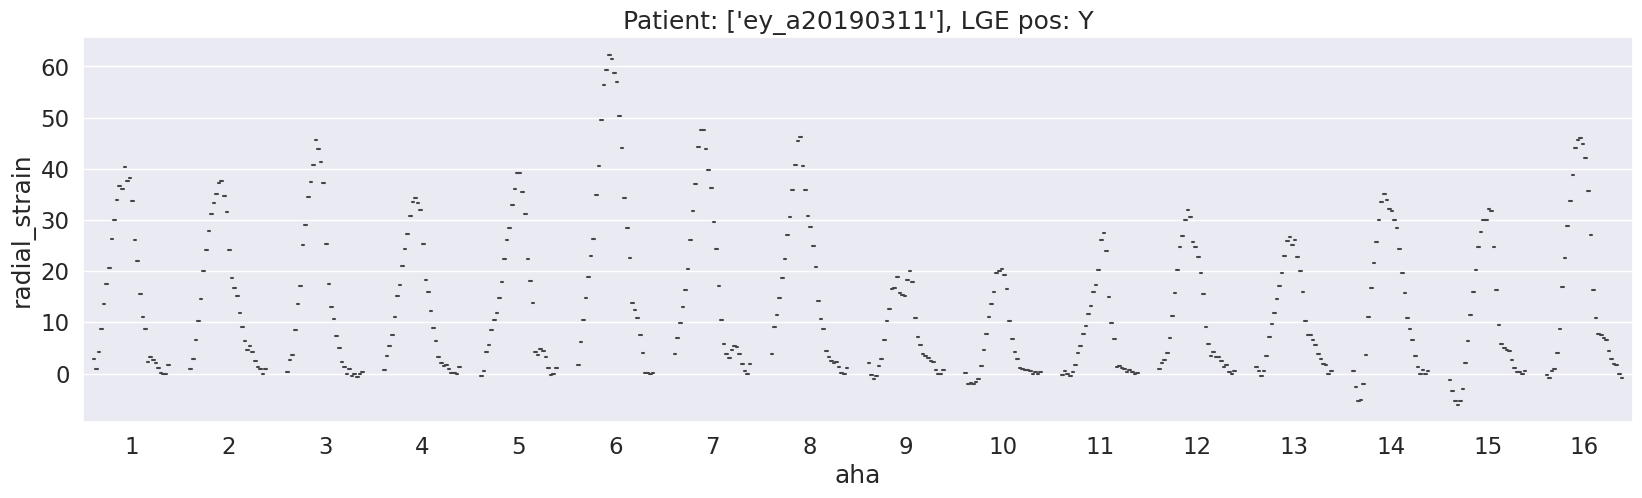

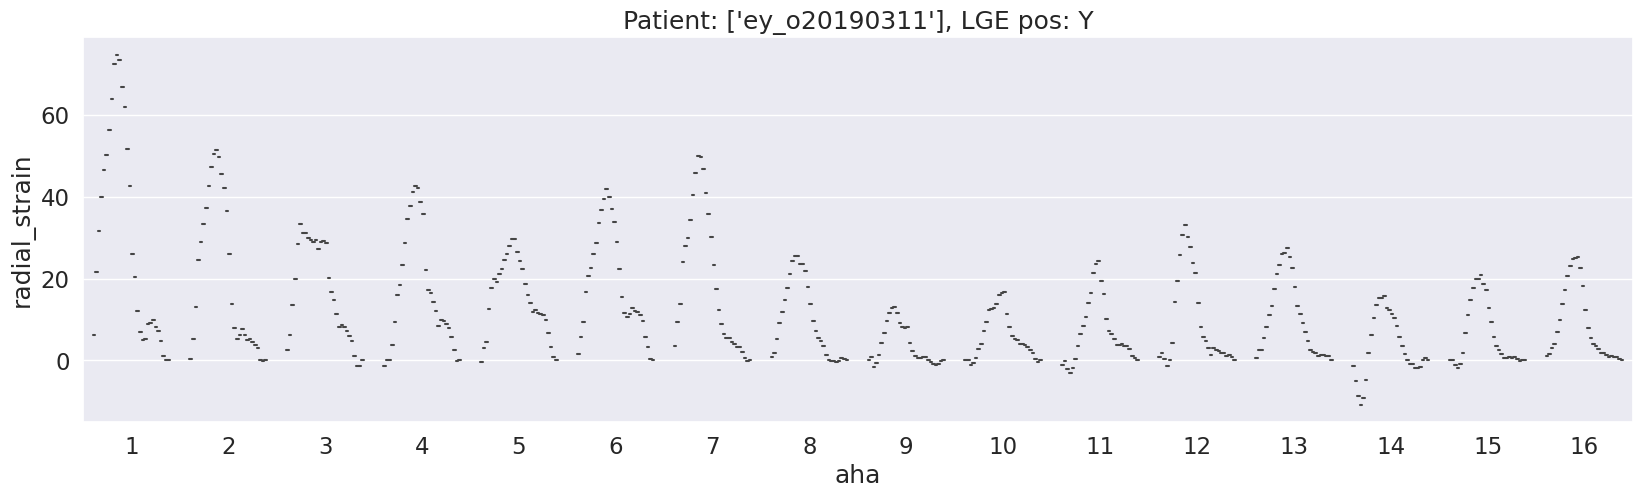

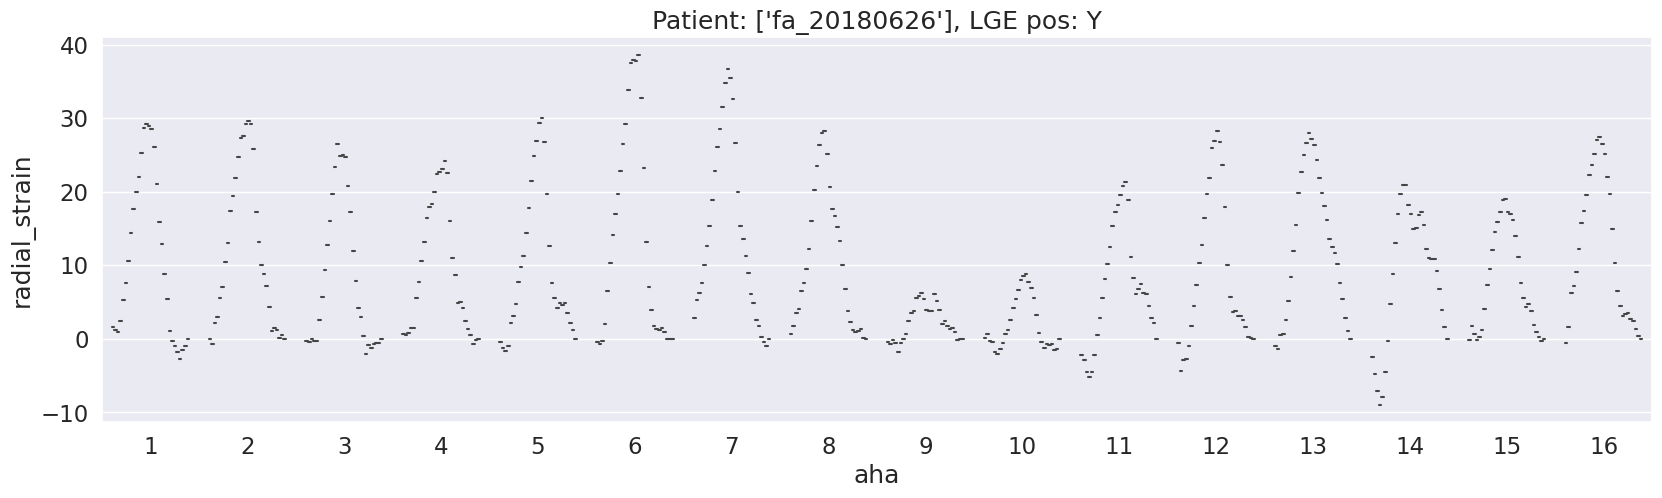

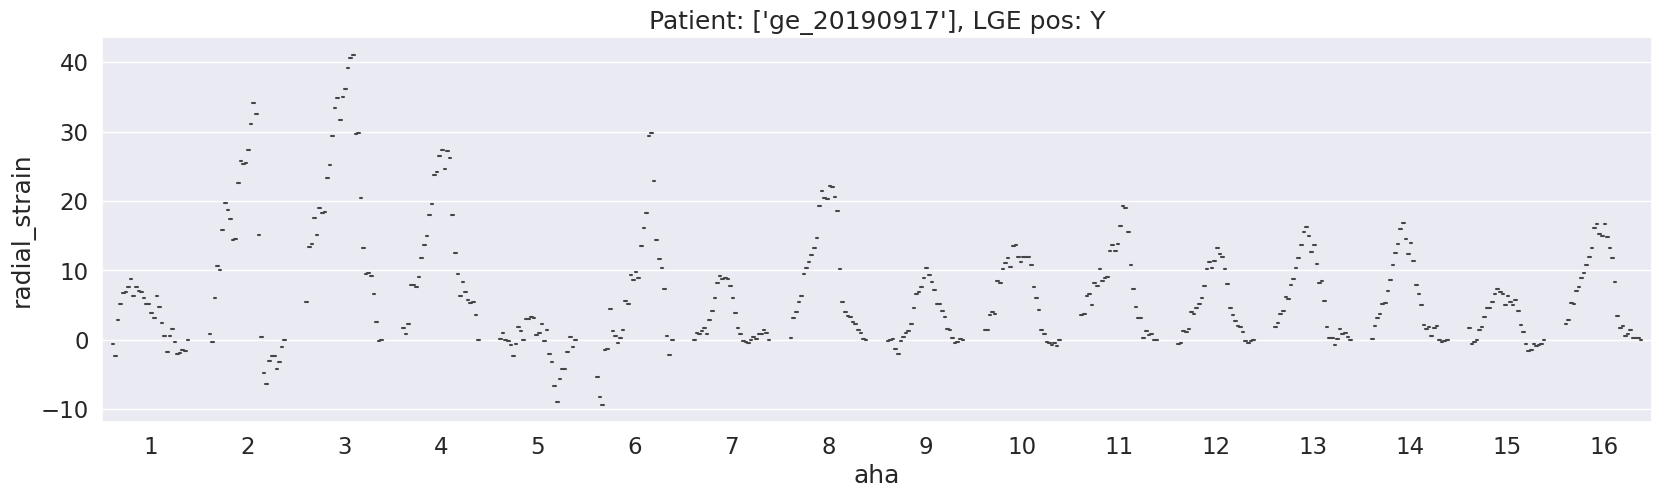

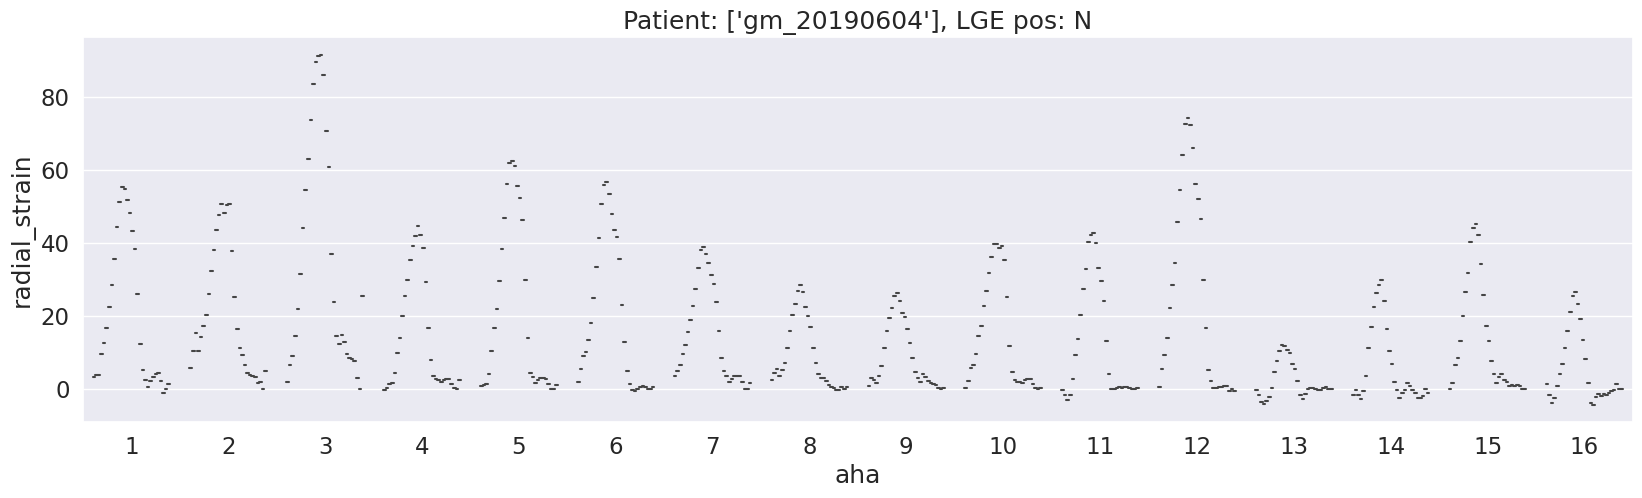

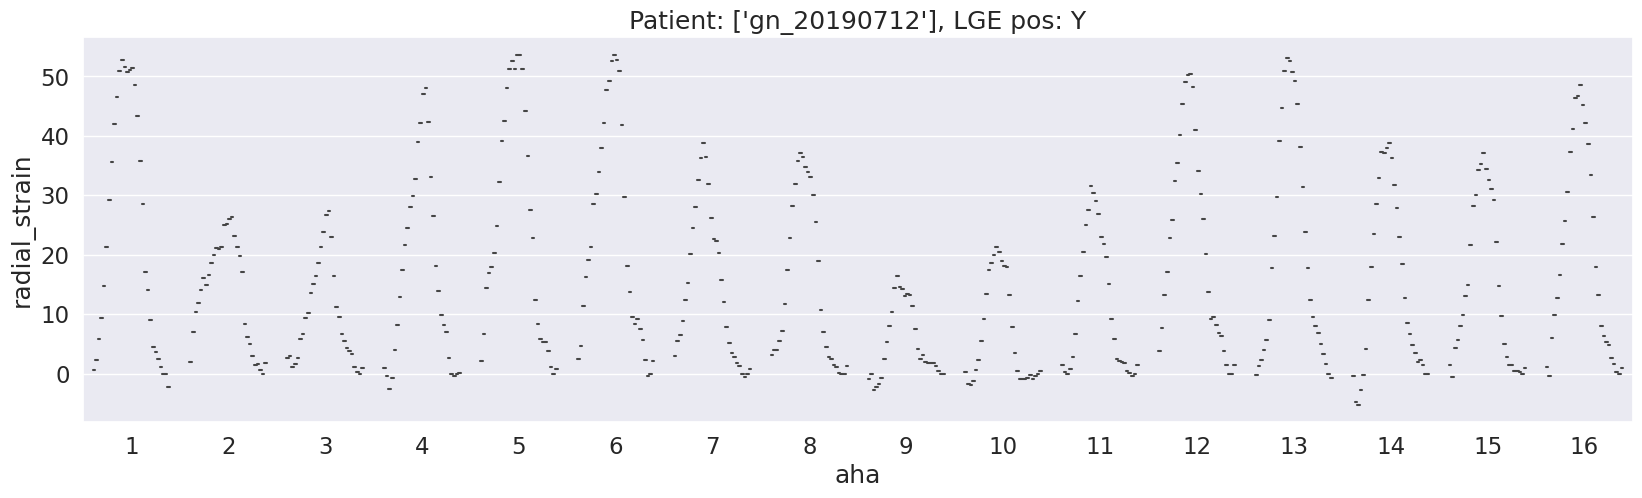

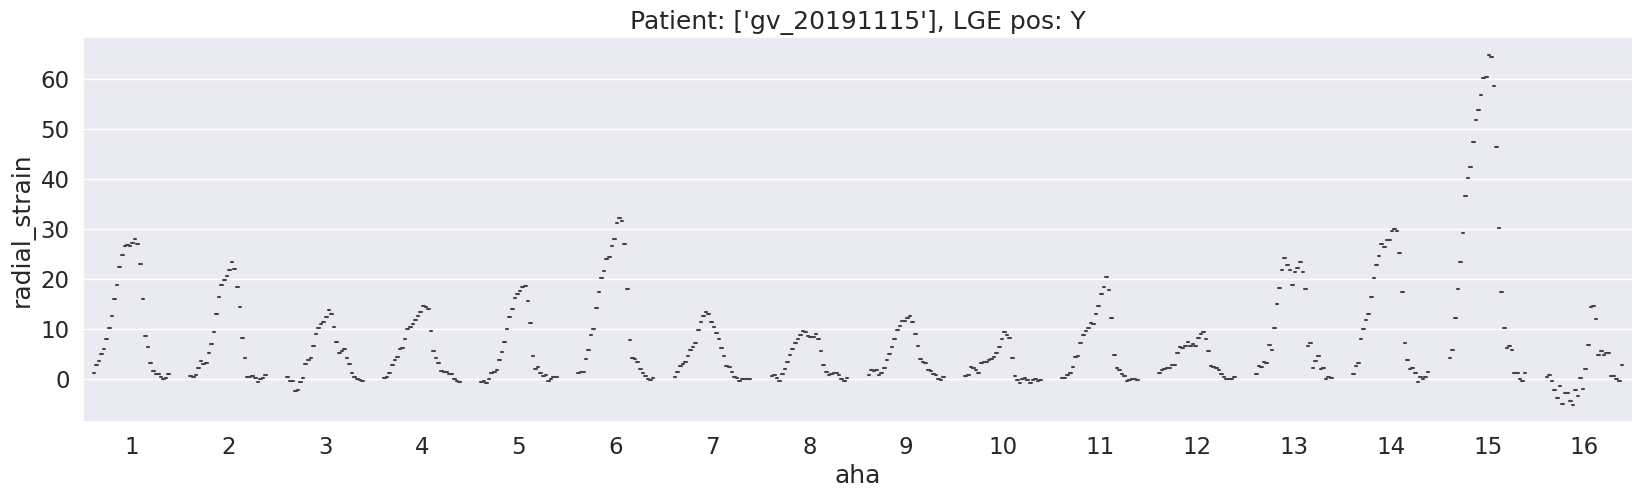

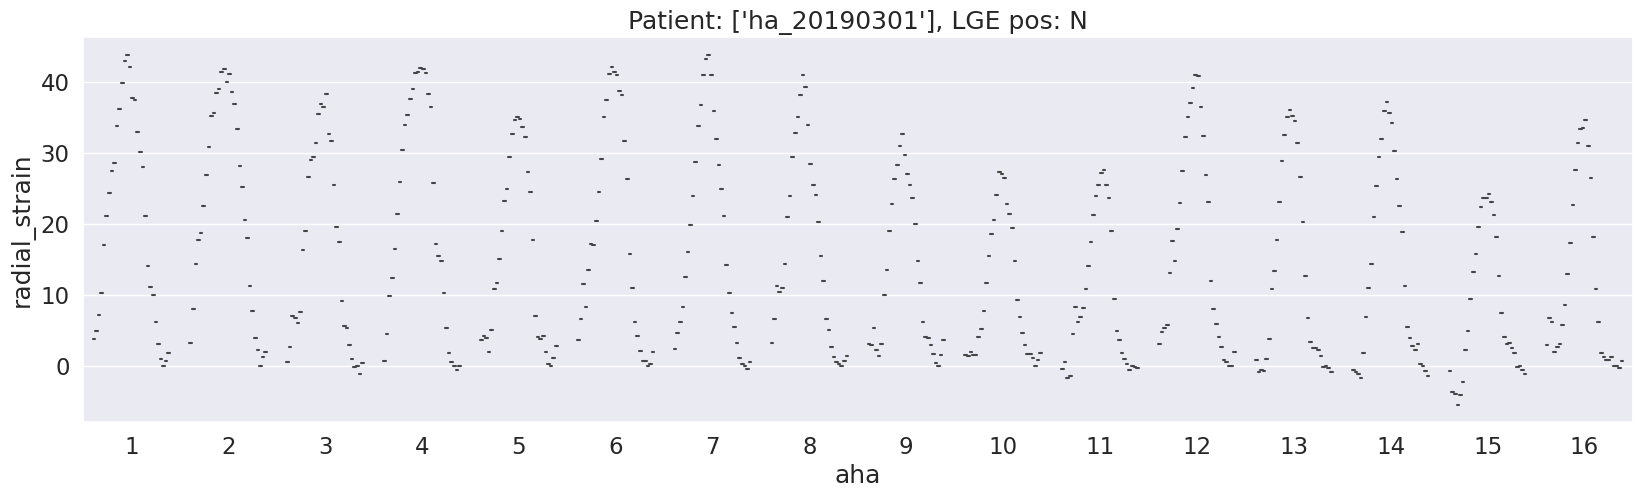

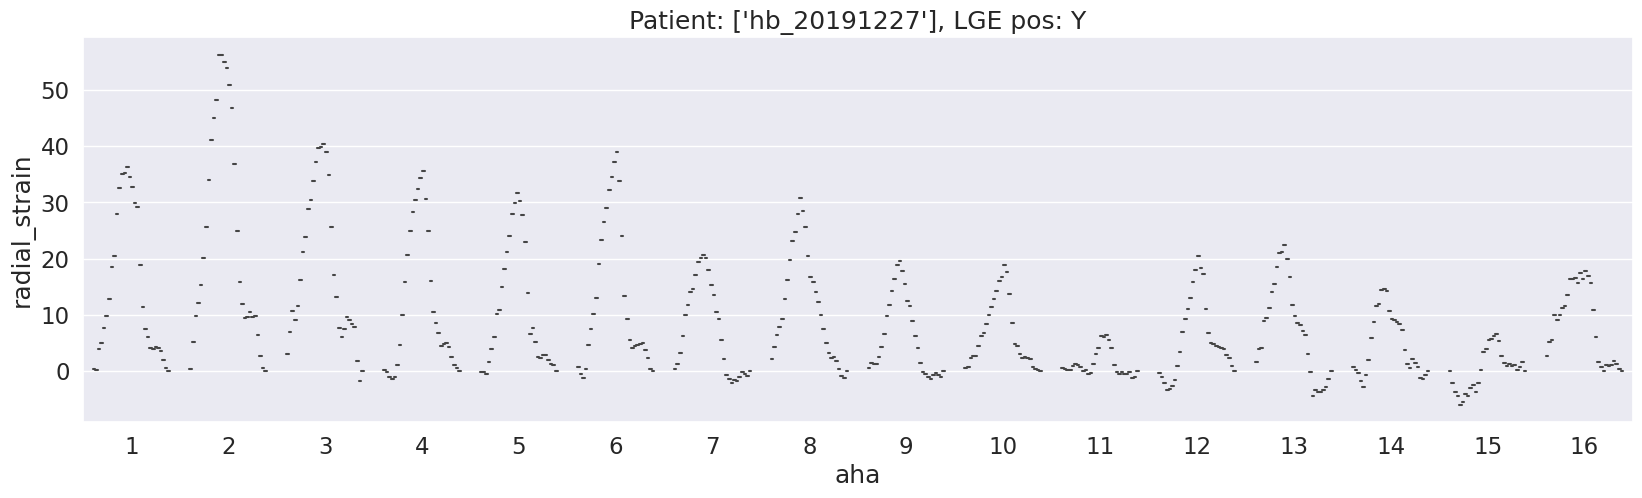

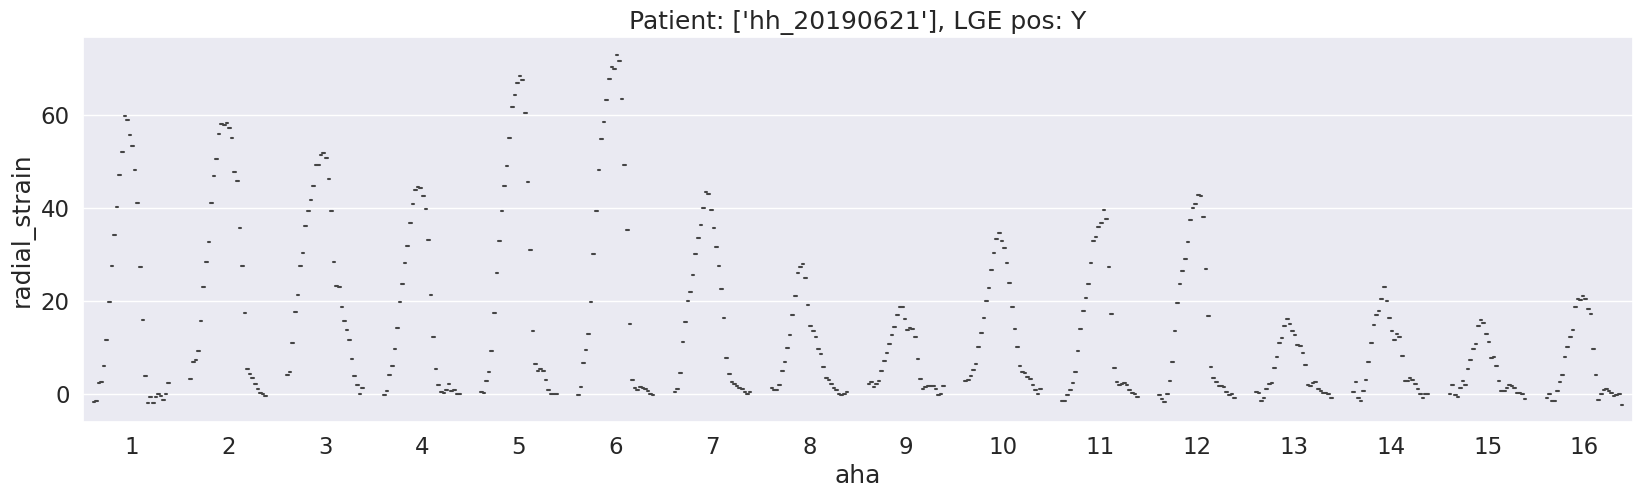

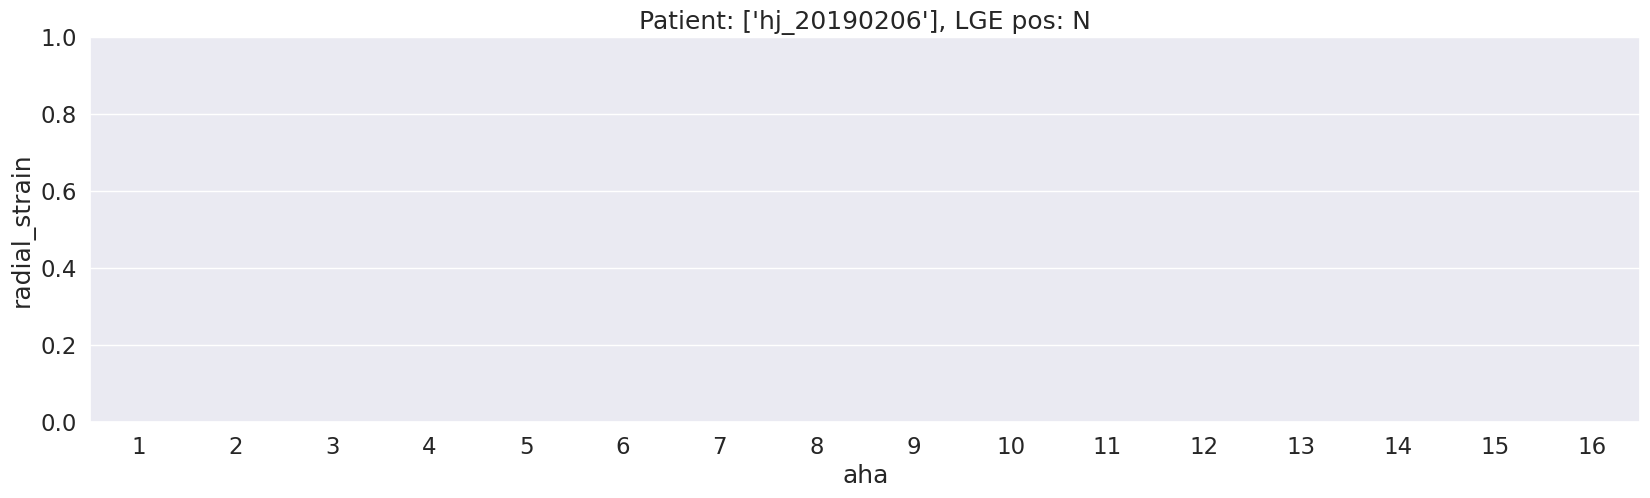

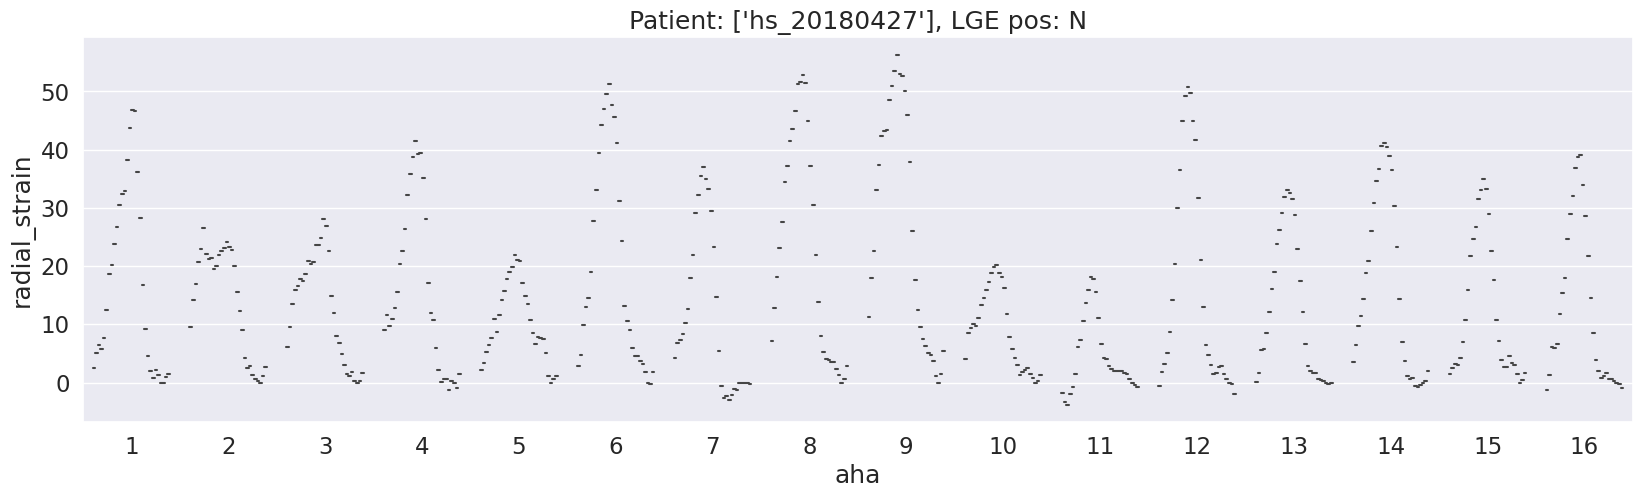

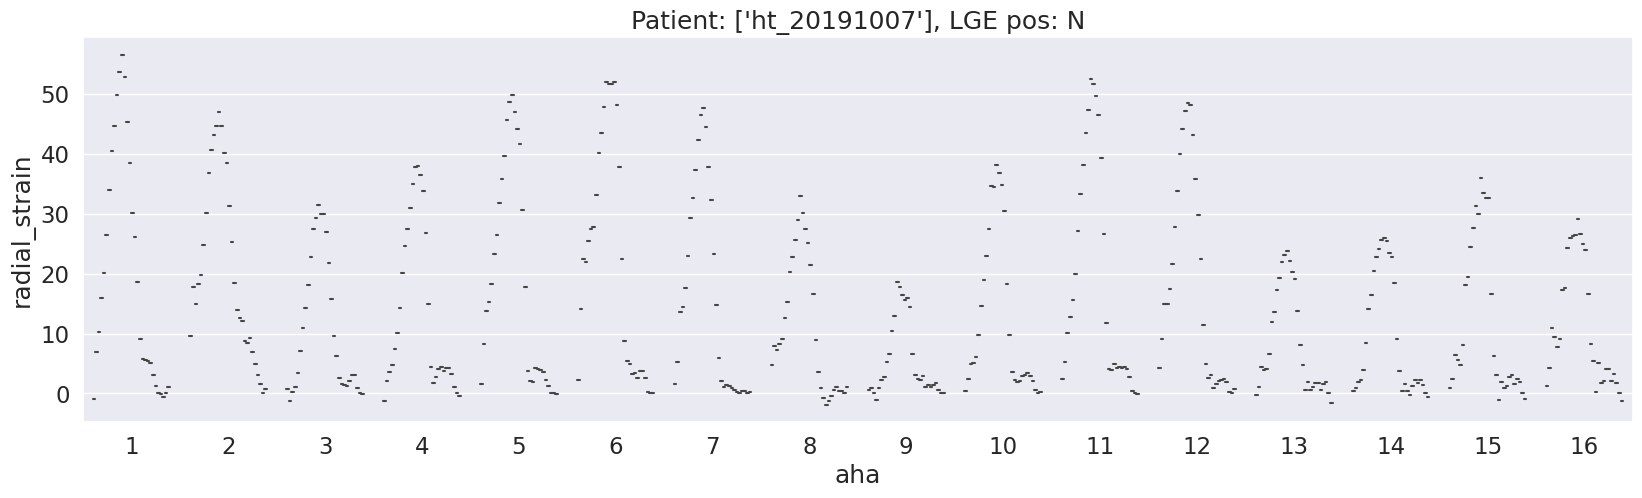

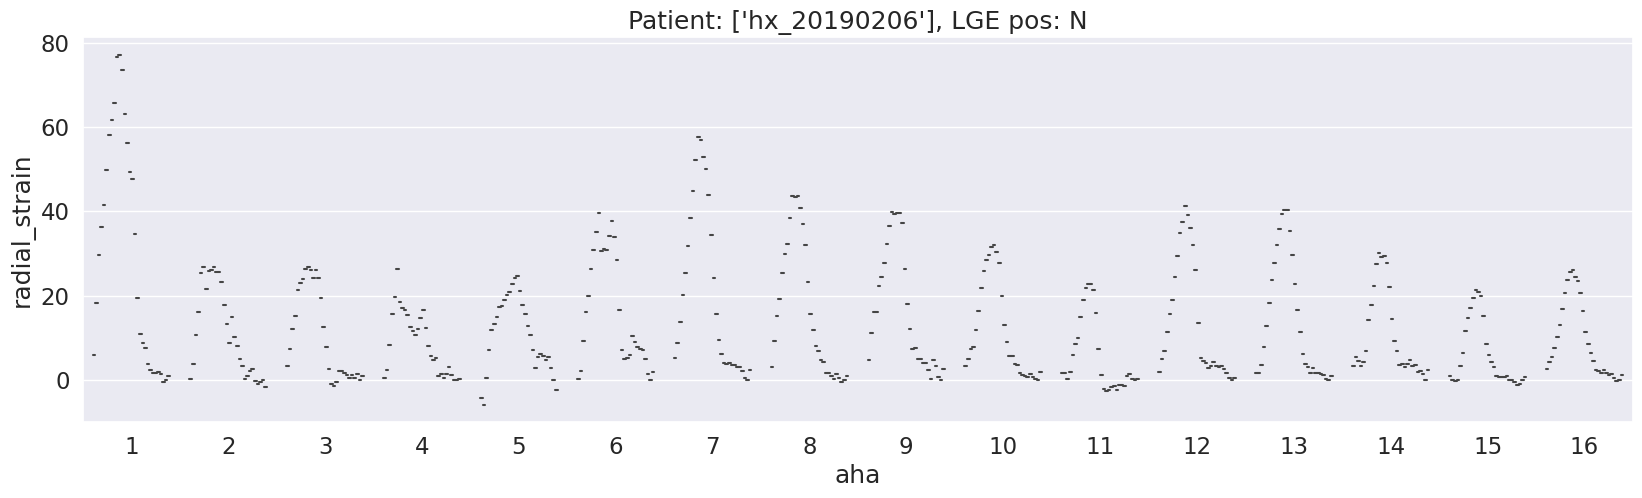

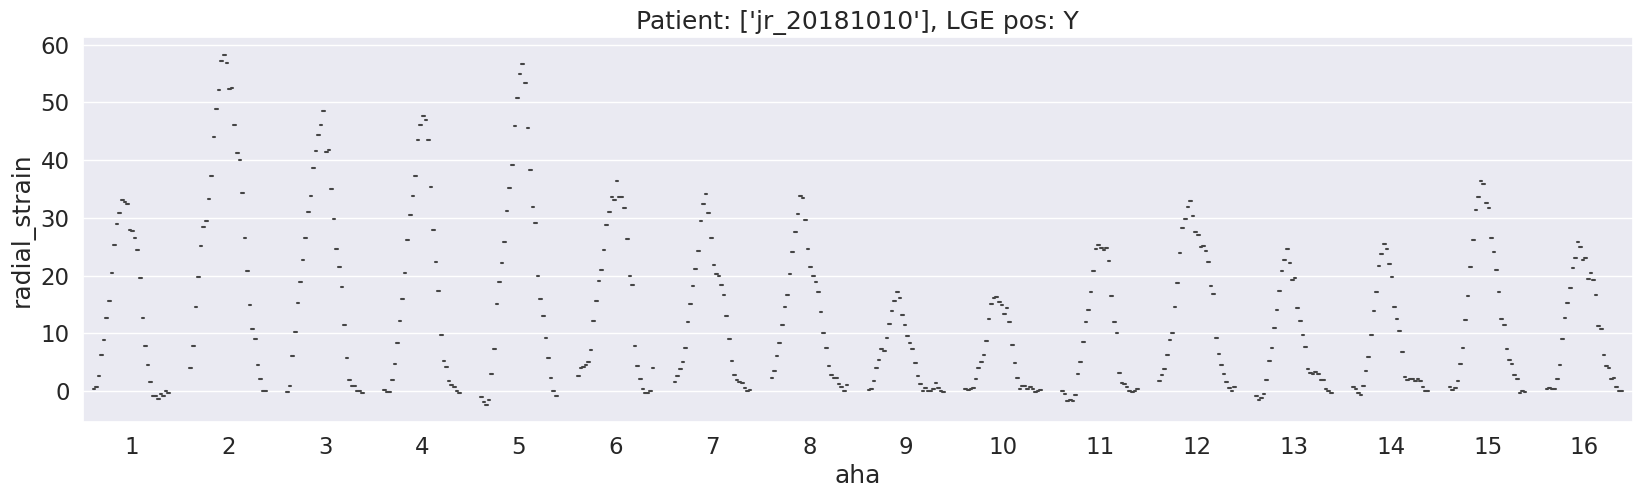

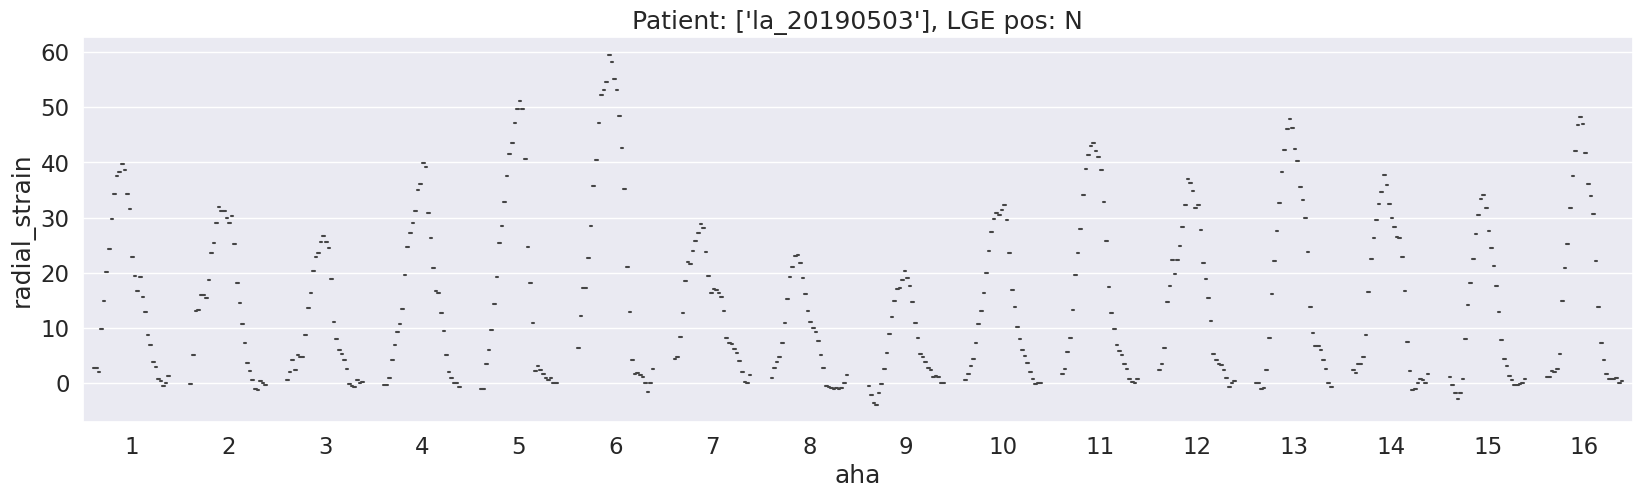

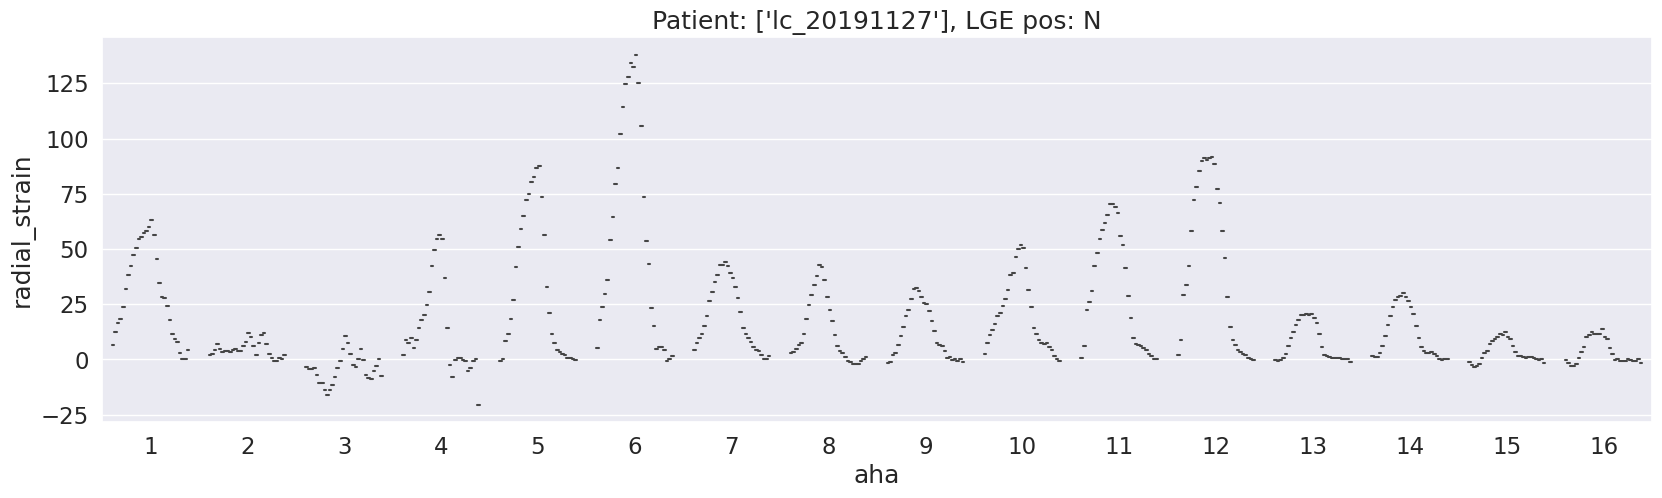

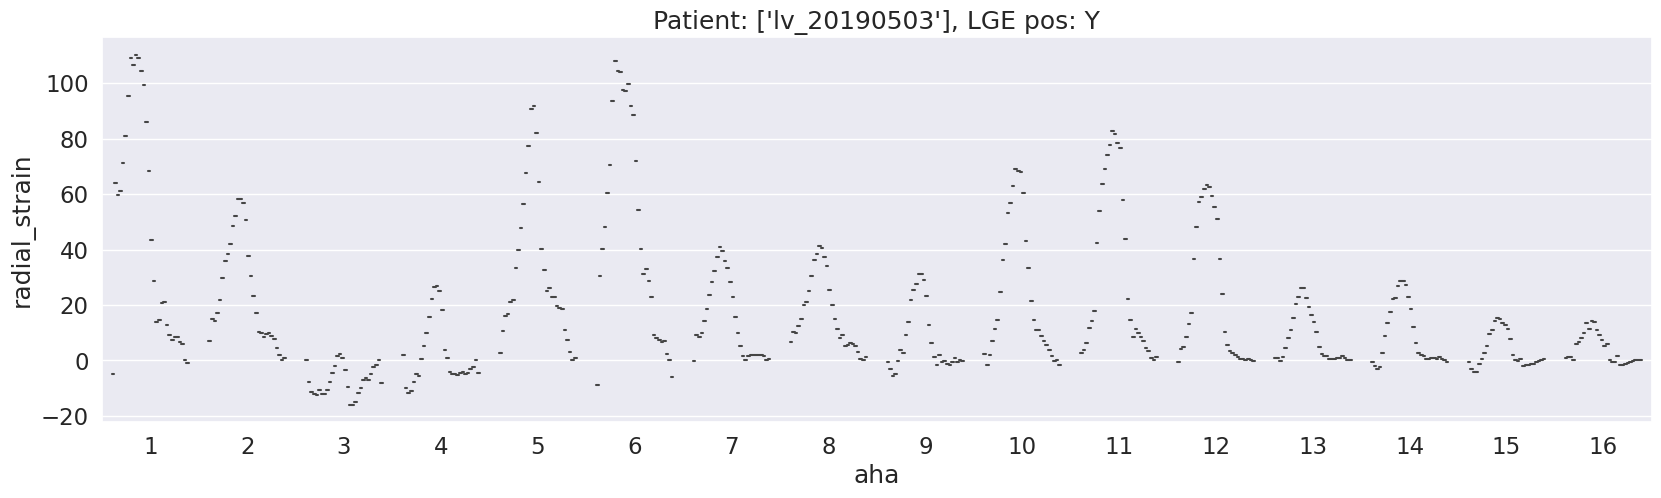

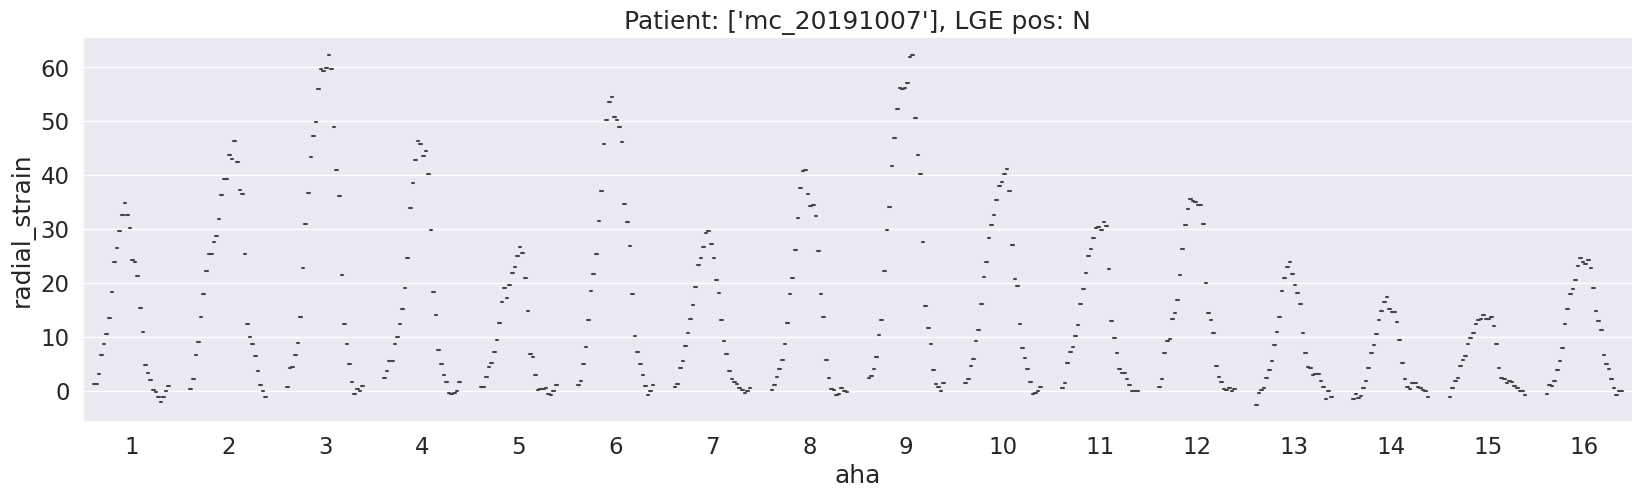

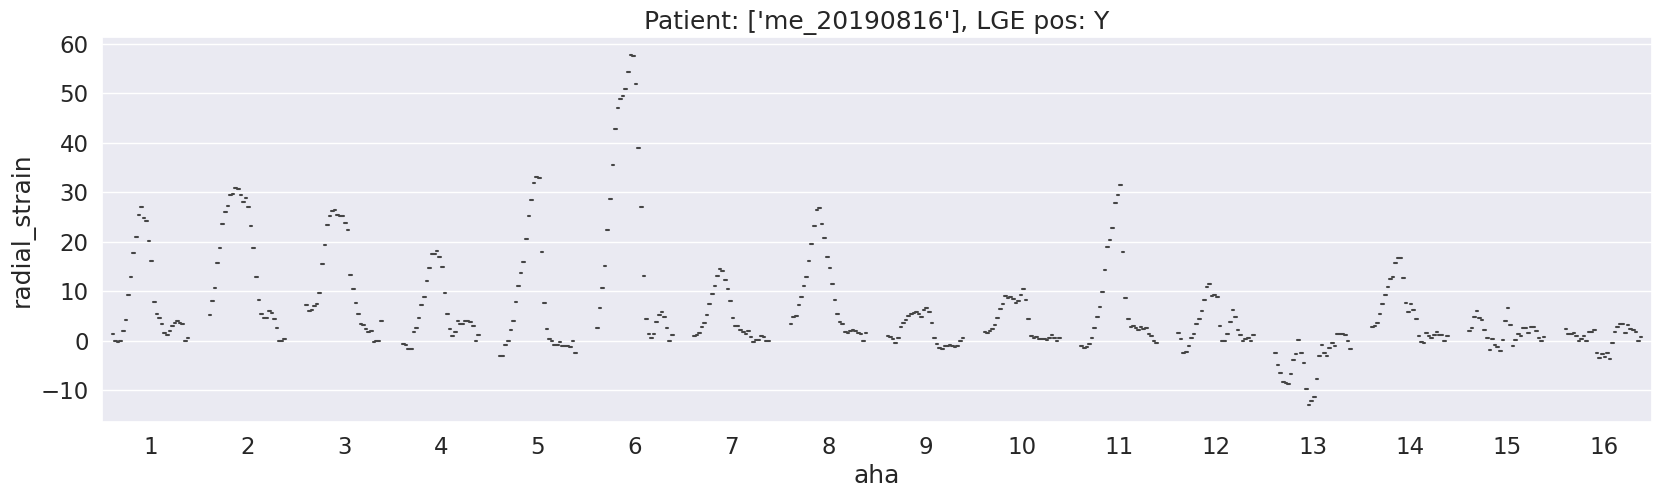

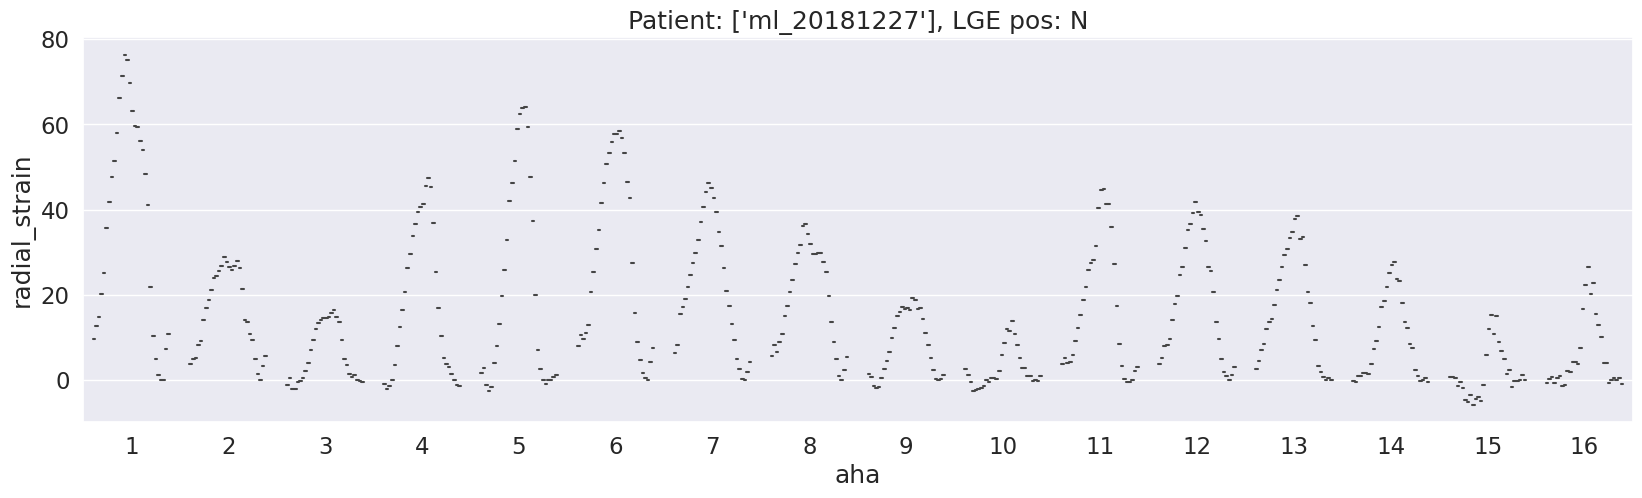

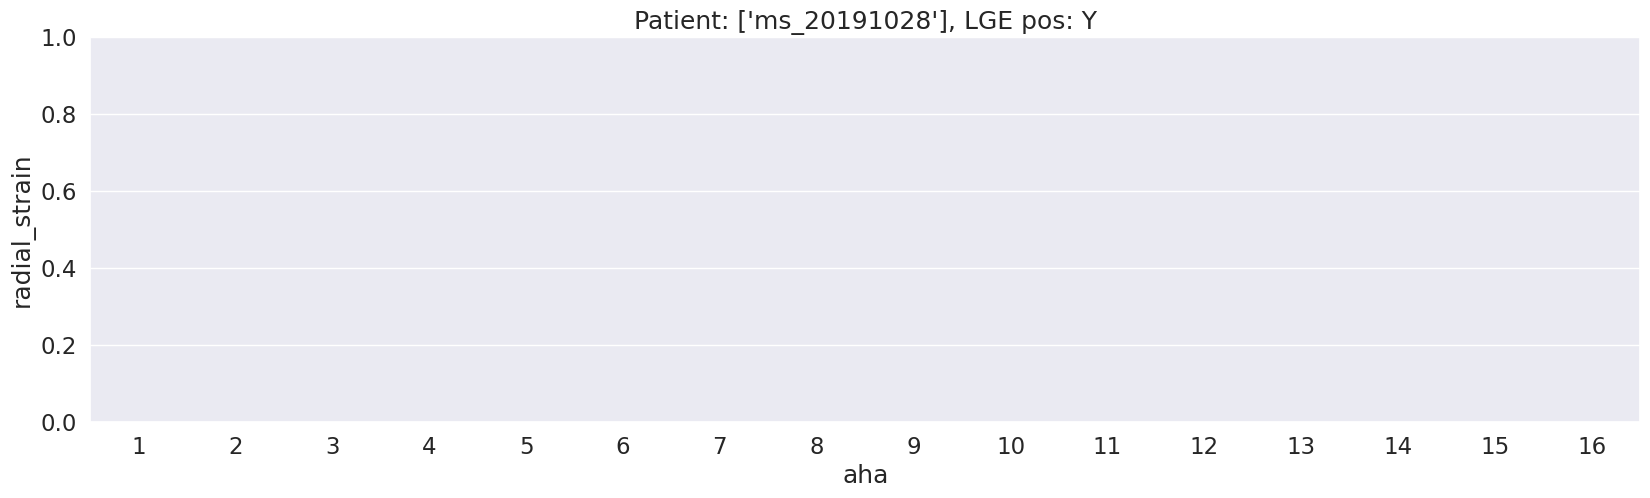

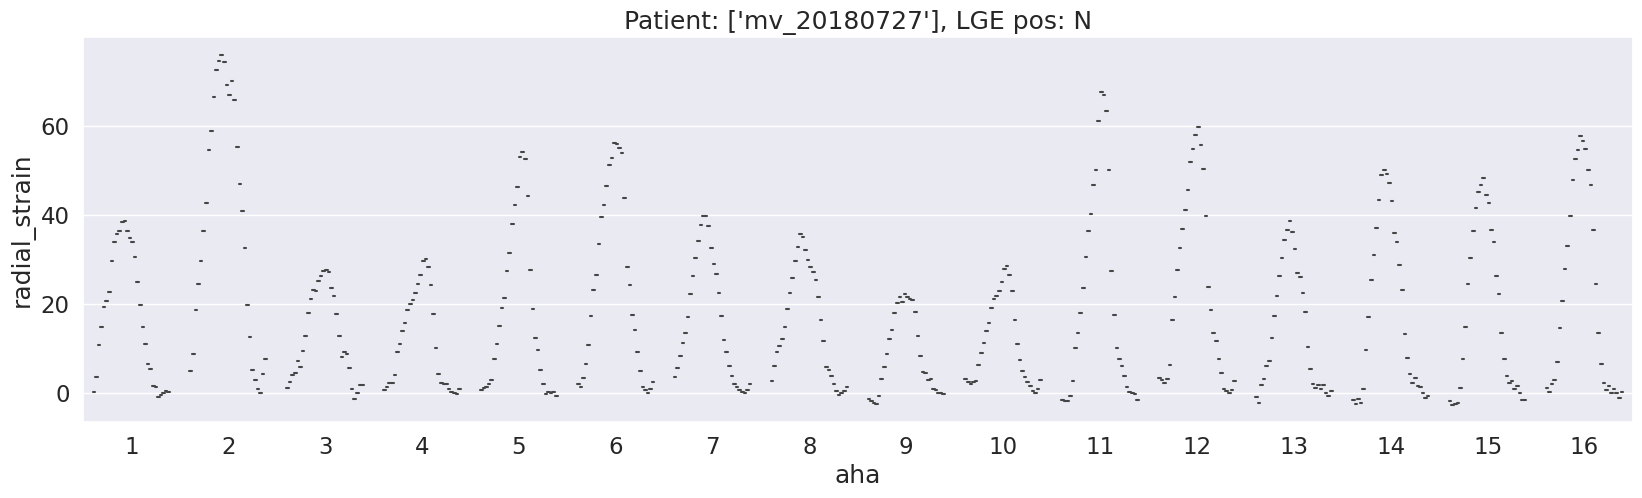

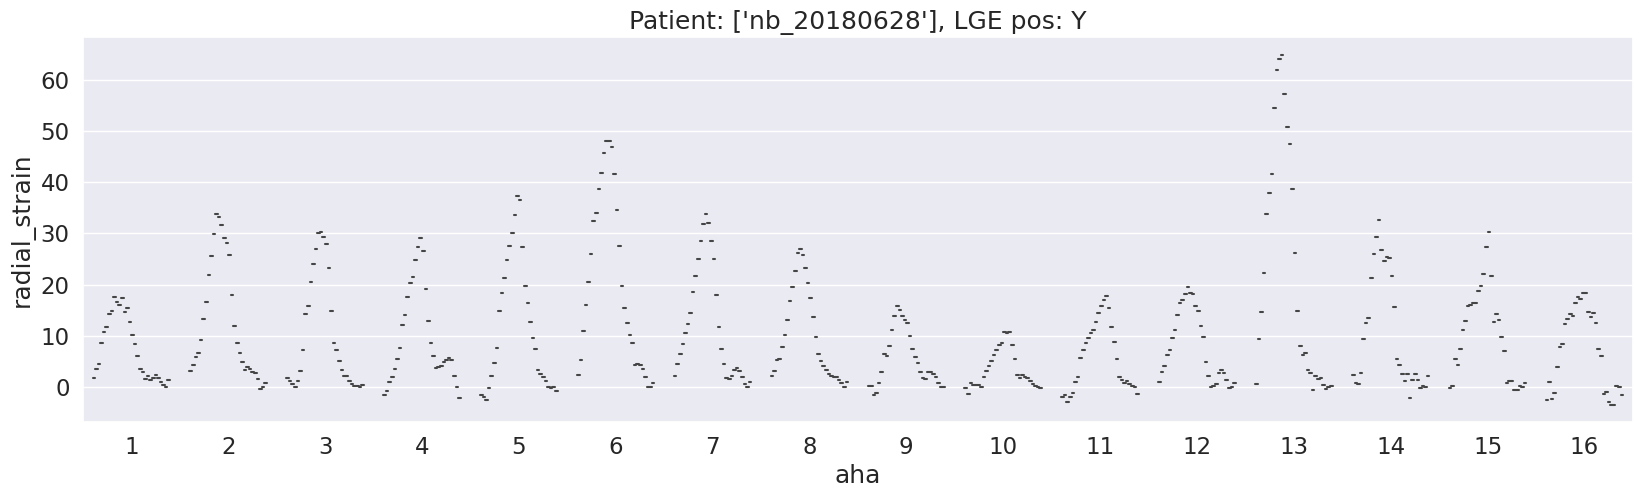

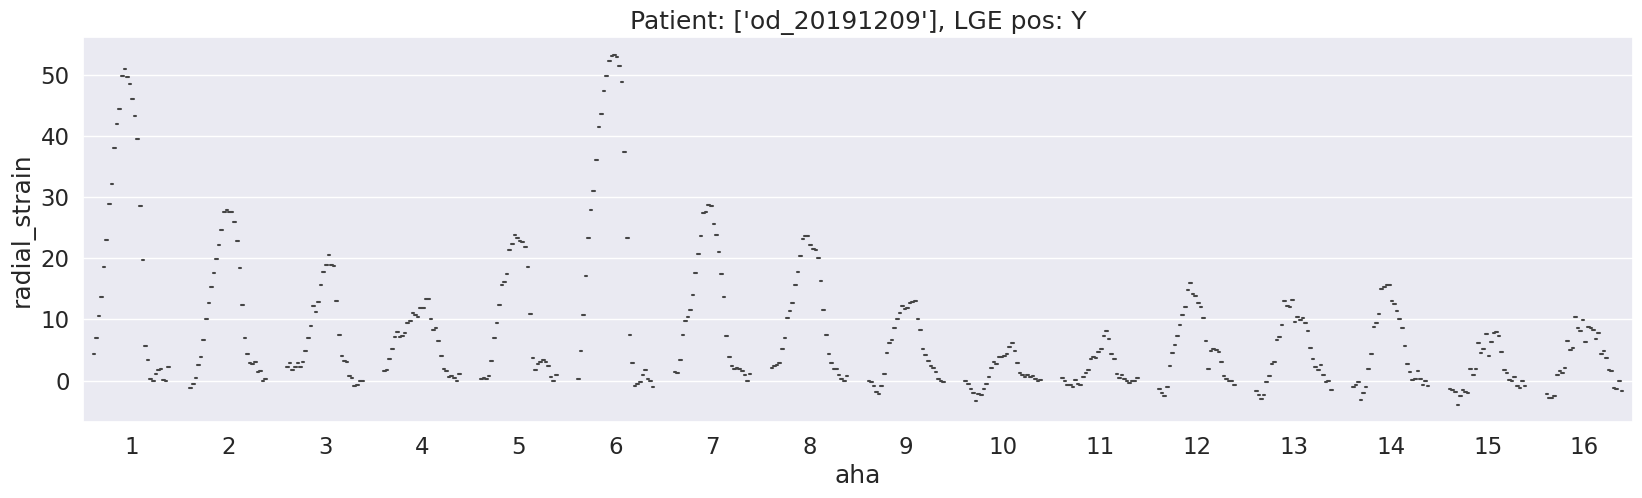

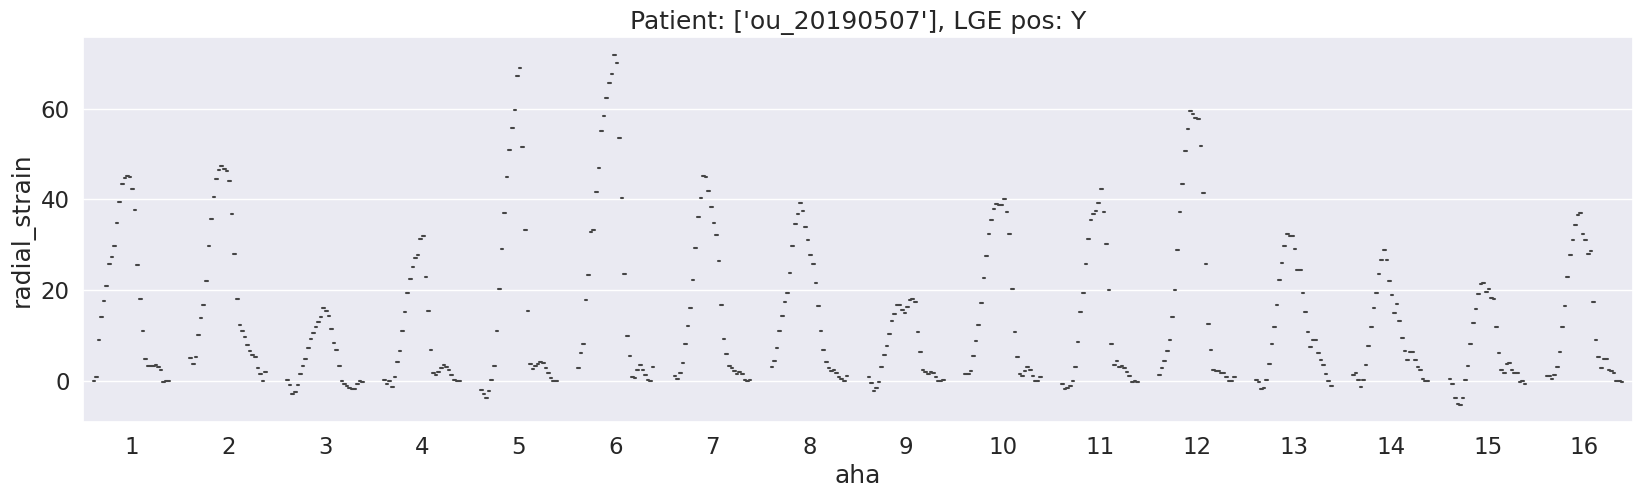

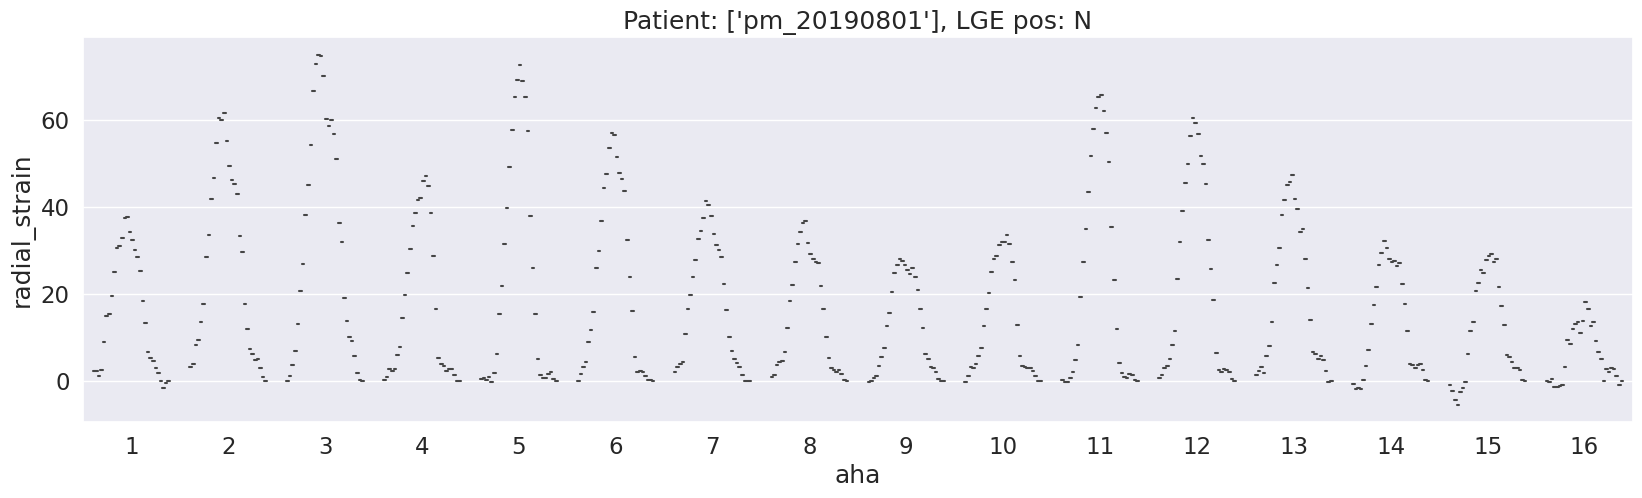

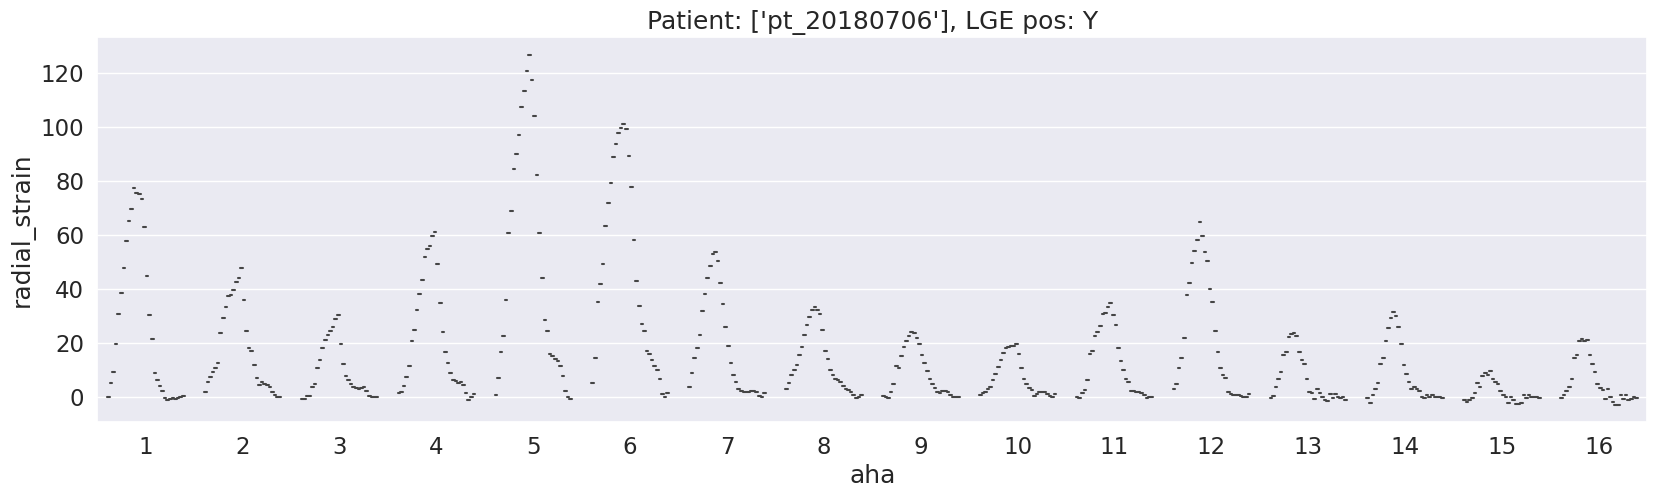

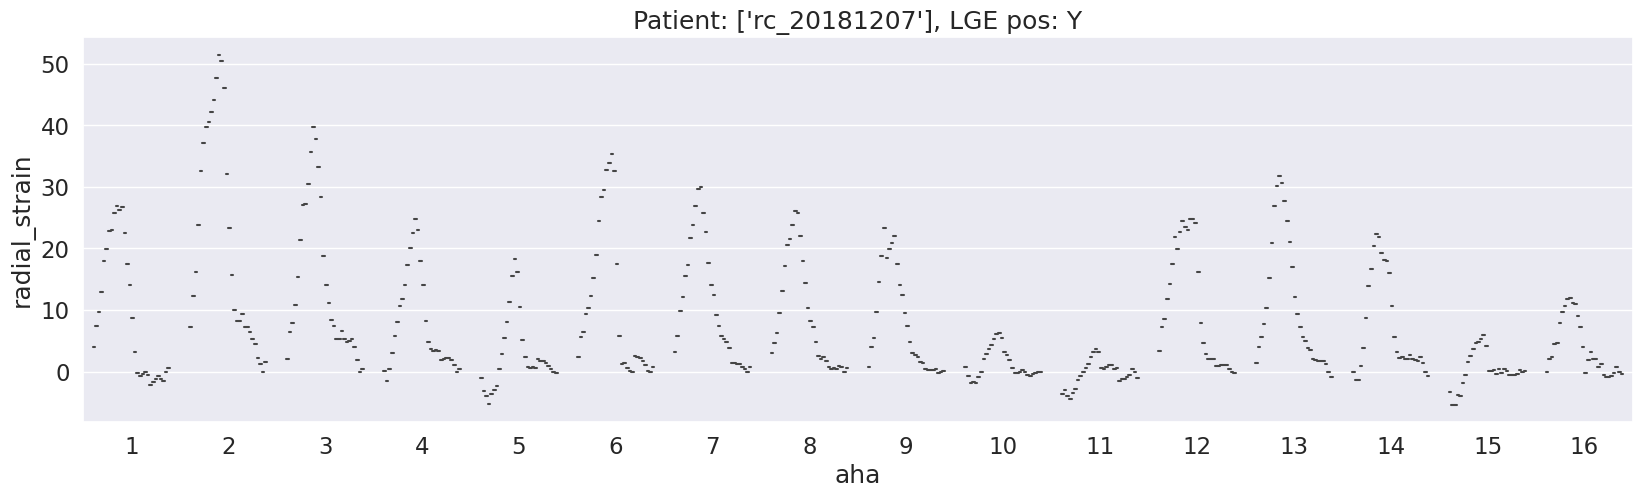

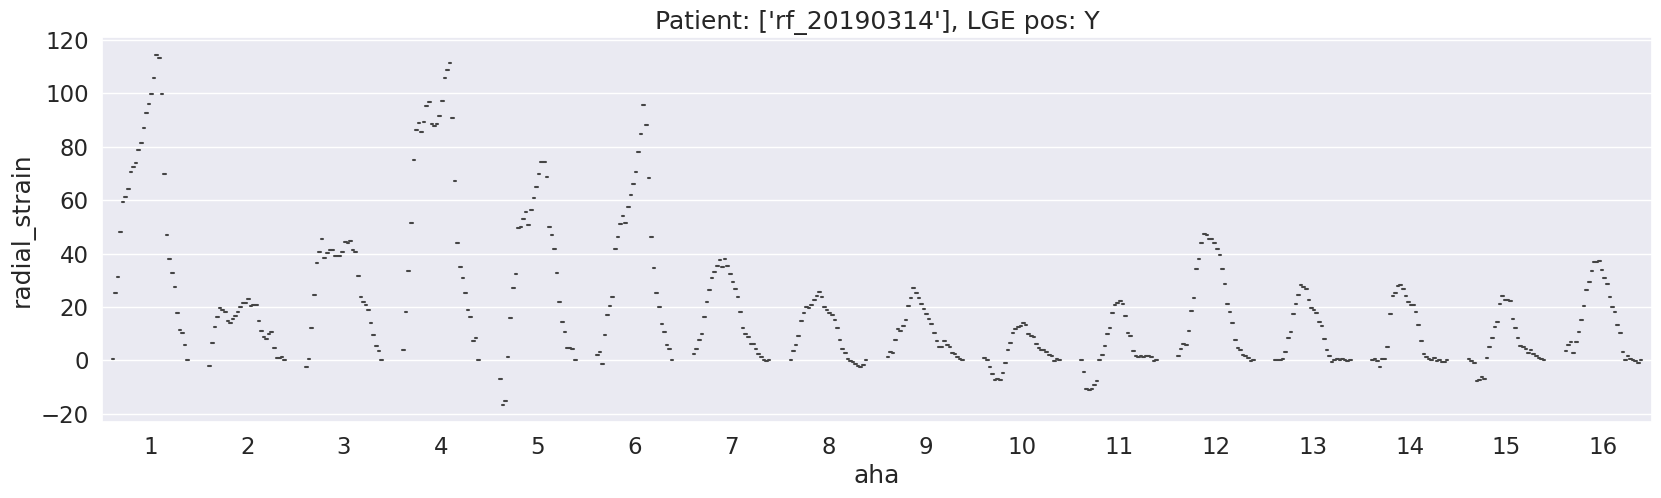

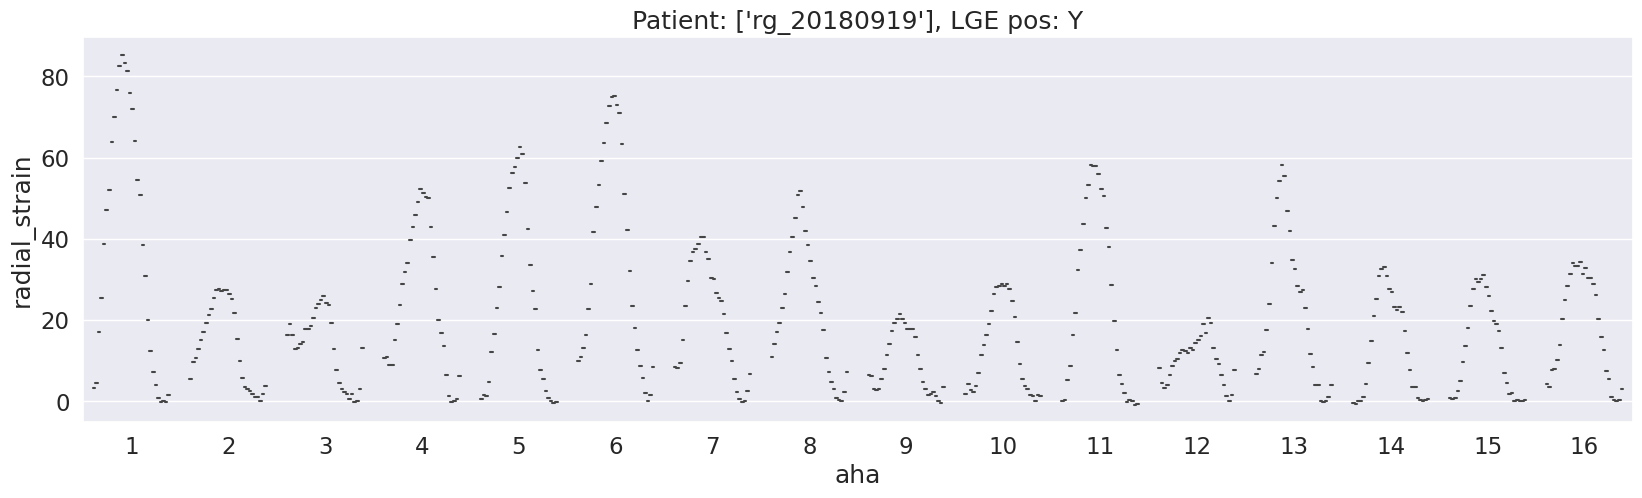

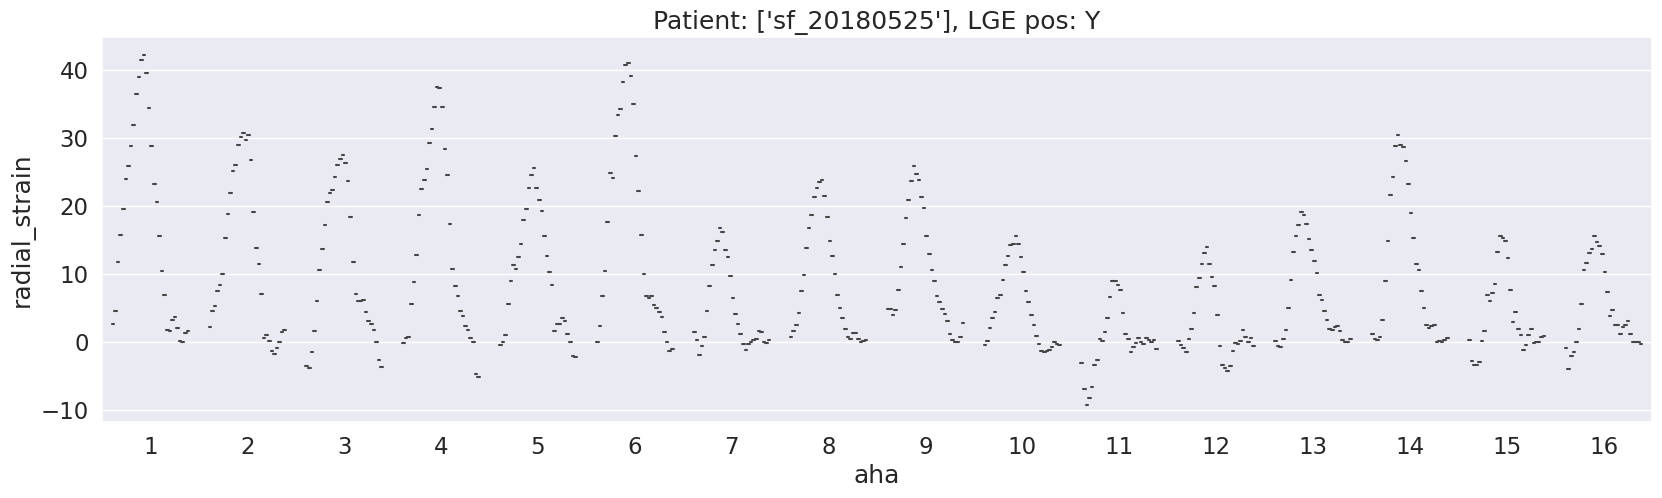

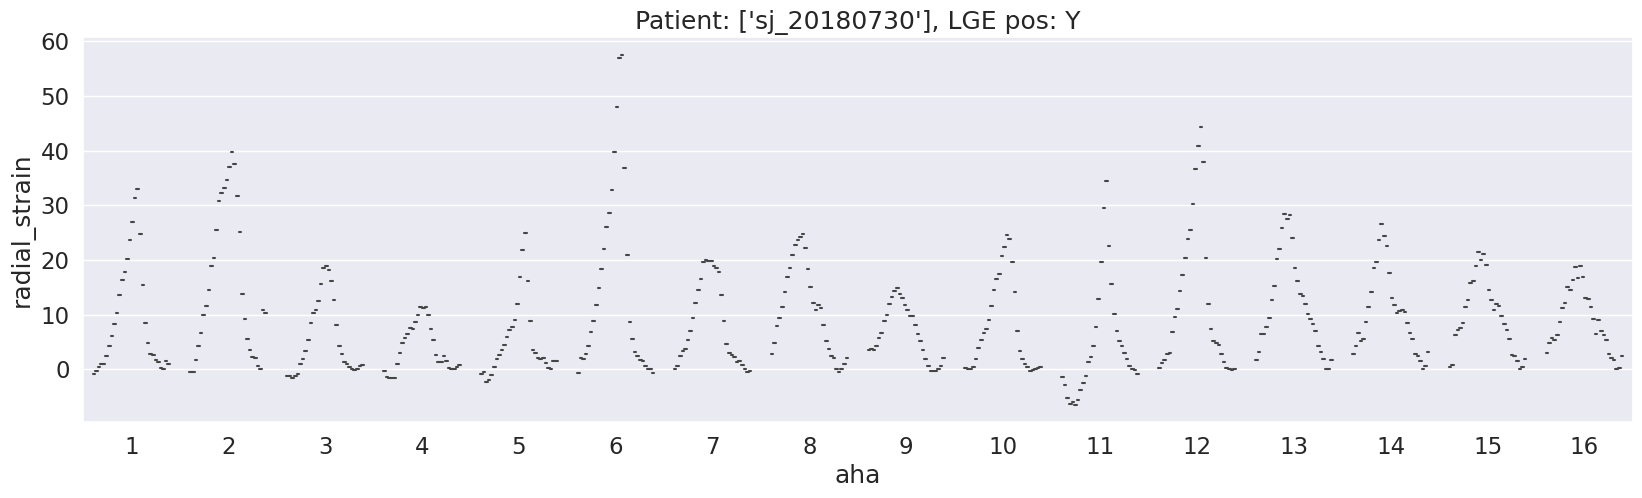

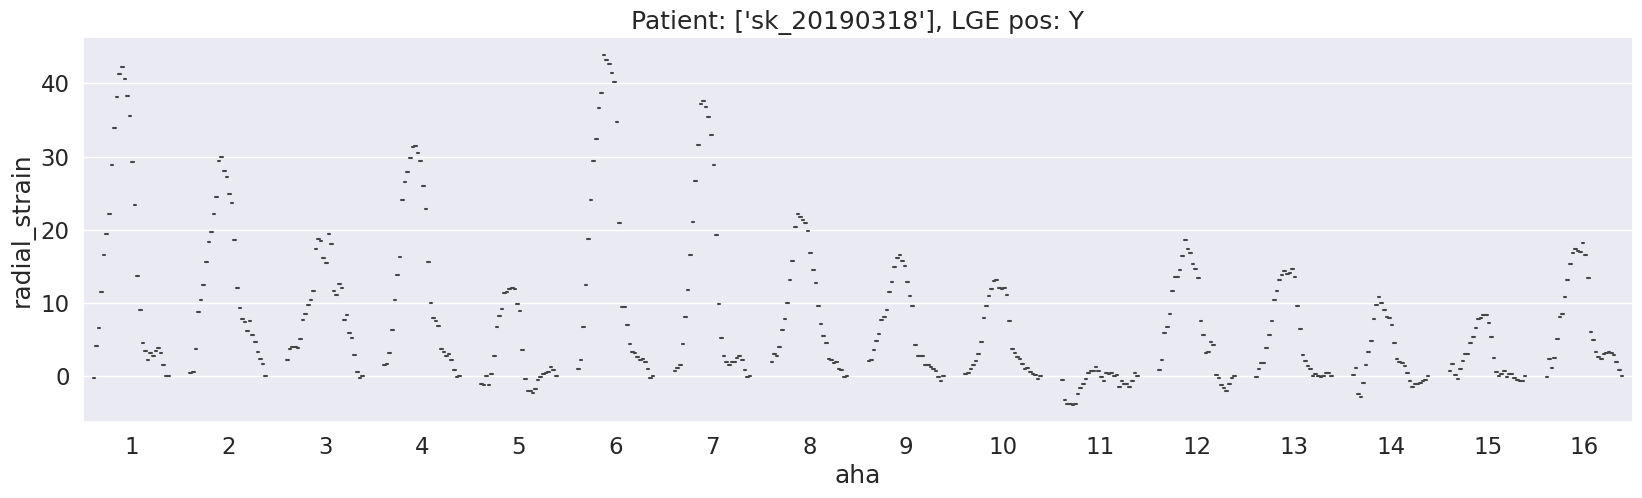

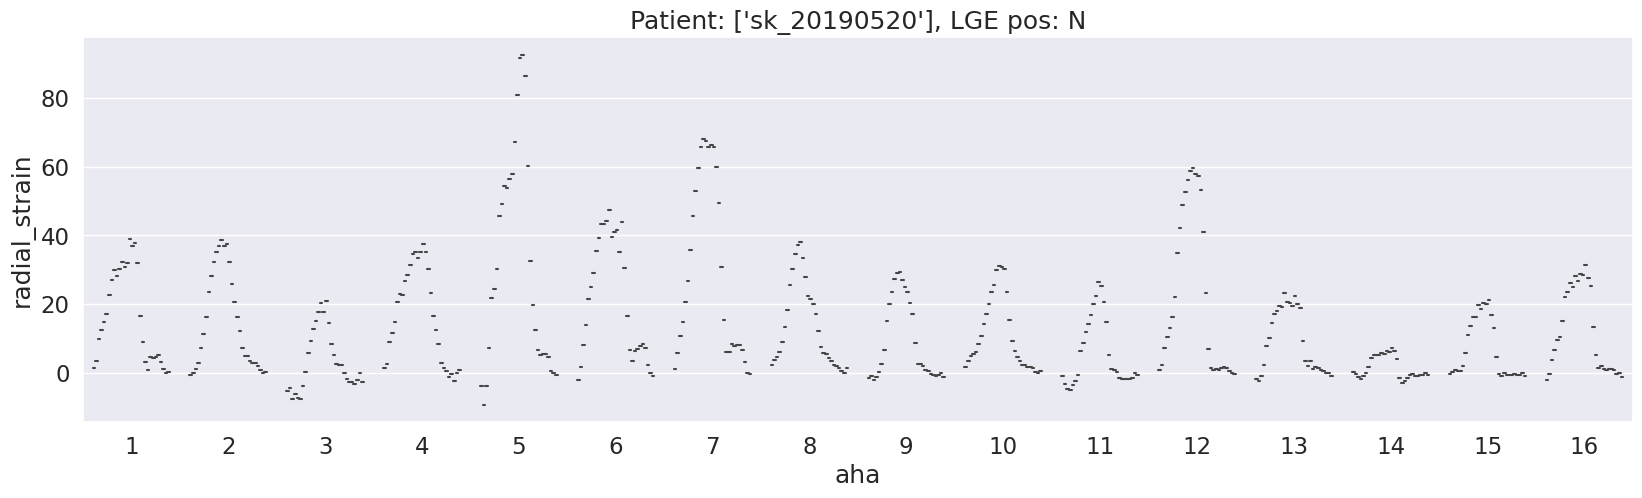

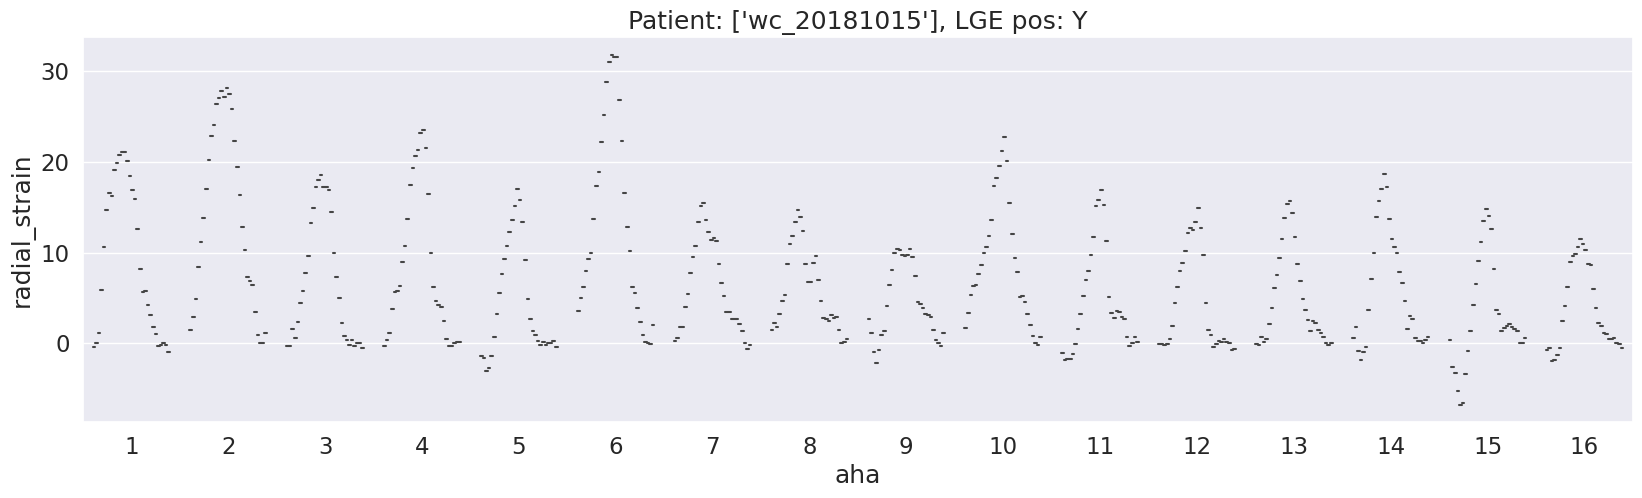

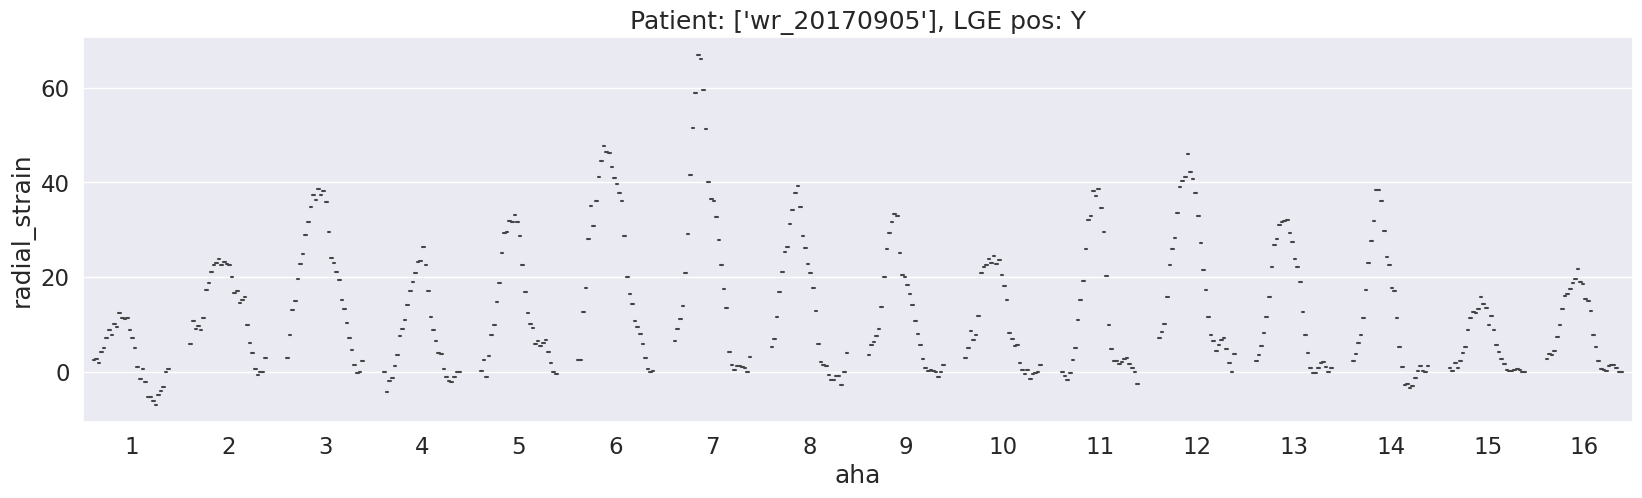

In [58]:
def plot_strain(df, segments=[1]):
    sb.set_context('paper')
    sb.set(font_scale = 1.5)
    fig, ax = plt.subplots(1,1,figsize=(20,5))
    plt.title('Patient: {}, LGE pos: {}'.format(segments, df[df['patient'].isin(segments)].target.values[0]))
    sb.violinplot(x="aha", y="radial_strain",inner='quart',
                     data=df[df['patient'].isin(segments)],
                  ax=ax,
                 hue='frame',
                  #scale_hue=True,
                 #split=True
                 )
    plt.legend([],[], frameon=False)
    plt.show()
_ = [plot_strain(df_merged, segments=[i]) for i in df_merged.patient.unique()]

In [14]:
df_merged.describe() # 27360 = 57 patients x 16 segments x 30 frames

aha  radial_strain  circ_strain  Participant Number  \
count  4560.000000    4320.000000  4320.000000         4560.000000   
mean      8.500000      12.978996    -7.334644           29.000000   
std       4.610278      16.807798     7.631071           16.453754   
min       1.000000     -10.754000   -34.412000            1.000000   
25%       4.750000       0.626250   -12.531500           15.000000   
50%       8.500000       6.881500    -5.583500           29.000000   
75%      12.250000      19.801750    -0.554250           43.000000   
max      16.000000     164.404000    16.738000           57.000000   

          Unique ID   Age at MRI          ED#          MS#          ES#  \
count  4.560000e+03  4560.000000  4560.000000  4560.000000  4560.000000   
mean   4.320642e+06    14.197563    29.140351     5.982456    12.631579   
std    2.898791e+06     3.160773     0.686756     0.713145     1.279279   
min    3.814370e+05     8.788889    28.000000     4.000000     9.000000   
25%    1.851147e+06    11.741667    29.000000     6.000000    12.000000   
50%    3.583054e+06    14.402778    29.000000     6.000000    12.000000   
75%    6.624293e+06    16.975000    30.000000     6.000000    13.000000   
max    9.953987e+06    22.225000    30.000000     8.000000    16.000000   

               PF#  ...  Height (cm)    BSA (m^2)   Heart Rate  \
count  4560.000000  ...  4560.000000  4560.000000  4560.000000   
mean     18.543860  ...   149.033333     1.496491    95.052632   
std       1.777934  ...    15.705206     0.362771    14.785943   
min      13.000000  ...   121.900000     0.680000    62.000000   
25%      17.000000  ...   135.600000     1.210000    86.000000   
50%      19.000000  ...   148.800000     1.520000    96.000000   
75%      19.000000  ...   161.300000     1.730000   103.000000   
max      23.000000  ...   182.000000     2.380000   138.000000   

       LV Ejection Fraction  LV end diastolic volume  LV end systolic volume  \
count           4560.000000              4560.000000             4560.000000   
mean               0.544035               108.771930               51.721053   
std                0.088066                38.786605               27.874369   
min                0.340000                54.000000               12.000000   
25%                0.490000                83.000000               33.000000   
50%                0.550000                94.000000               43.000000   
75%                0.600000               124.000000               60.000000   
max                0.780000               225.000000              148.000000   

       LV mass (g)  RV Ejection Fraction  RV end diastolic volume  \
count  4560.000000           4560.000000              4560.000000   
mean     67.403509              0.564561                99.631579   
std      26.199069              0.059686                26.798219   
min      27.000000              0.460000                58.000000   
25%      52.000000              0.520000                82.000000   
50%      59.000000              0.560000                93.000000   
75%      78.000000              0.600000               111.000000   
max     151.000000              0.740000               171.000000   

       RV end systolic volume  
count             4560.000000  
mean                43.684211  
std                 14.101637  
min                 19.000000  
25%                 33.000000  
50%                 41.000000  
75%                 51.000000  
max                 86.000000  

[8 rows x 27 columns]

In [15]:
df_merged.columns

Index(['pat', 'aha', 'frame', 'radial_strain', 'circ_strain',
       'Participant Number', 'Name',
       'Tarique -visual wall motion abnormality?', 'AHA segments',
       'Tarique -strain abnormality?', 'AHA segment from strain if different',
       'Unique ID', 'Study Date', 'Age at MRI', 'Gender', 'ED#', 'MS#', 'ES#',
       'PF#', 'MD#', '# of Phases',
       'Plain XML, Plain+strain XML, and Strain Calculations Exported',
       'Plain + LGE workspacexported', 'LGE TD location', 'LAX_ED', 'LAX_ES',
       'LAX_phases', 'Weight (kg)', 'Height (cm)', 'BSA (m^2)', 'Heart Rate',
       'BP', 'LV Ejection Fraction', 'LV end diastolic volume',
       'LV end systolic volume', 'LV mass (g)', 'RV Ejection Fraction',
       'RV end diastolic volume', 'RV end systolic volume',
       'LGE present? (y/n)',
       '% Involvement of LV myocardium (by mean+5xSD method)',
       'AHA segments with LGE',
       'Location, and Extent of Late Gadolinium Enhancement (LGE)',
       'Nocturnal BiPAP 

In [16]:
y = (df_merged[df_merged.frame==0].sort_values(['pat']).groupby('pat')['target'].apply(lambda x: list(x)[0]).values=='Y').astype(int) # 57 patients
print(y.shape)

(57,)


In [17]:
y

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

1. select the features of choice
2. start the grid search, which will use the current x and y values
3. Refit an estimator with the best parameters from the gridseach and plot the metrics + SD per split

(57, 160)
********** Logistic Regression **********
[0.42857143 0.14285714 0.5        0.83333333 0.57142857]
F1: 0.47 (+/- 0.14) [Logistic Regression]
Recall: 0.50 (+/- 0.22) [Logistic Regression]
Accuracy: 0.41 (+/- 0.10) [Logistic Regression]
********** Random Forest **********
[0.57142857 0.85714286 1.         0.83333333 0.71428571]
F1: 0.69 (+/- 0.11) [Random Forest]
Recall: 0.80 (+/- 0.14) [Random Forest]
Accuracy: 0.54 (+/- 0.16) [Random Forest]
********** Naive Bayes **********
[0.28571429 0.71428571 0.5        0.66666667 0.57142857]
F1: 0.55 (+/- 0.15) [Naive Bayes]
Recall: 0.55 (+/- 0.15) [Naive Bayes]
Accuracy: 0.49 (+/- 0.19) [Naive Bayes]
********** Scaled DecissionTree **********
[0.57142857 0.57142857 0.83333333 0.66666667 0.57142857]
F1: 0.63 (+/- 0.02) [Scaled DecissionTree]
Recall: 0.64 (+/- 0.10) [Scaled DecissionTree]
Accuracy: 0.55 (+/- 0.03) [Scaled DecissionTree]
********** KNN **********
[0.85714286 0.42857143 0.16666667 0.33333333 0.28571429]
F1: 0.42 (+/- 0.16)

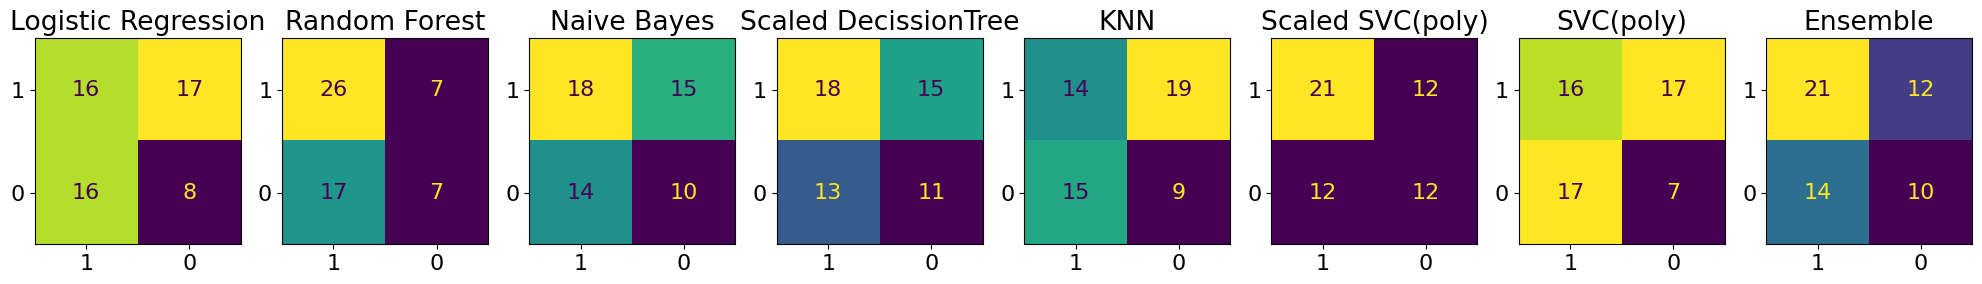

In [18]:
# radial and circ strain per segment and frame 16 x time x 2
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat'])['radial_strain'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x2 = np.stack(df_merged.sort_values(['pat']).groupby(['pat'])['circ_strain'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x = np.concatenate([x,x2], axis=1)
print(x.shape)
x = np.nan_to_num(x)
cross_validate_f1(x,y)

(57, 32)
********** Logistic Regression **********
[0.42857143 0.71428571 1.         0.33333333 1.        ]
F1: 0.70 (+/- 0.24) [Logistic Regression]
Recall: 0.70 (+/- 0.28) [Logistic Regression]
Accuracy: 0.68 (+/- 0.24) [Logistic Regression]
********** Random Forest **********
[0.71428571 0.71428571 0.5        0.5        0.71428571]
F1: 0.62 (+/- 0.12) [Random Forest]
Recall: 0.63 (+/- 0.10) [Random Forest]
Accuracy: 0.53 (+/- 0.17) [Random Forest]
********** Naive Bayes **********
[0.57142857 0.71428571 0.5        0.66666667 0.71428571]
F1: 0.66 (+/- 0.08) [Naive Bayes]
Recall: 0.63 (+/- 0.08) [Naive Bayes]
Accuracy: 0.61 (+/- 0.12) [Naive Bayes]
********** Scaled DecissionTree **********
[0.57142857 0.42857143 0.5        0.5        0.57142857]
F1: 0.54 (+/- 0.07) [Scaled DecissionTree]
Recall: 0.51 (+/- 0.05) [Scaled DecissionTree]
Accuracy: 0.49 (+/- 0.10) [Scaled DecissionTree]
********** KNN **********
[0.71428571 0.57142857 0.5        0.5        0.42857143]
F1: 0.62 (+/- 0.05) 

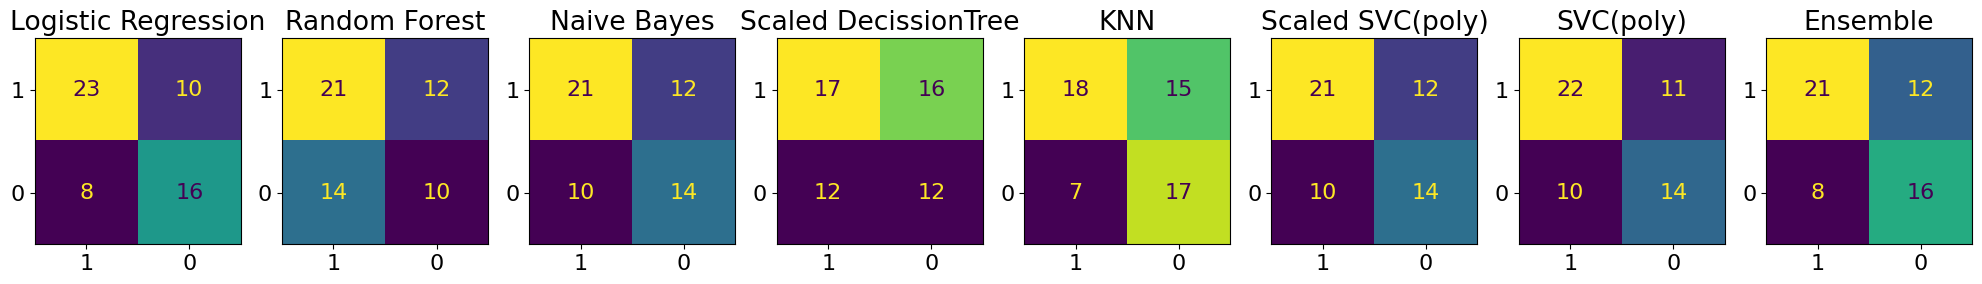

In [19]:
# Peak radial and circ strain per segment
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['radial_strain'].apply(lambda x: max(list(x))).values).astype(np.float32).reshape((57,16))
x2 = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['circ_strain'].apply(lambda x: min(list(x))).values).astype(np.float32).reshape((57,16))
x = np.concatenate([x,x2], axis=1)
print(x.shape)
x = np.nan_to_num(x)
cross_validate_f1(x,y)

(57, 2)
********** Logistic Regression **********
[0.57142857 0.85714286 0.5        0.66666667 0.57142857]
F1: 0.71 (+/- 0.11) [Logistic Regression]
Recall: 0.63 (+/- 0.12) [Logistic Regression]
Accuracy: 0.71 (+/- 0.11) [Logistic Regression]
********** Random Forest **********
[0.57142857 0.42857143 0.66666667 0.66666667 0.85714286]
F1: 0.63 (+/- 0.13) [Random Forest]
Recall: 0.64 (+/- 0.14) [Random Forest]
Accuracy: 0.55 (+/- 0.15) [Random Forest]
********** Naive Bayes **********
[0.85714286 0.85714286 0.66666667 0.66666667 0.85714286]
F1: 0.68 (+/- 0.07) [Naive Bayes]
Recall: 0.78 (+/- 0.09) [Naive Bayes]
Accuracy: 0.54 (+/- 0.06) [Naive Bayes]
********** Scaled DecissionTree **********
[0.57142857 0.42857143 0.5        0.66666667 0.57142857]
F1: 0.56 (+/- 0.08) [Scaled DecissionTree]
Recall: 0.55 (+/- 0.08) [Scaled DecissionTree]
Accuracy: 0.49 (+/- 0.11) [Scaled DecissionTree]
********** KNN **********
[0.71428571 0.42857143 0.5        0.66666667 0.14285714]
F1: 0.59 (+/- 0.18) [

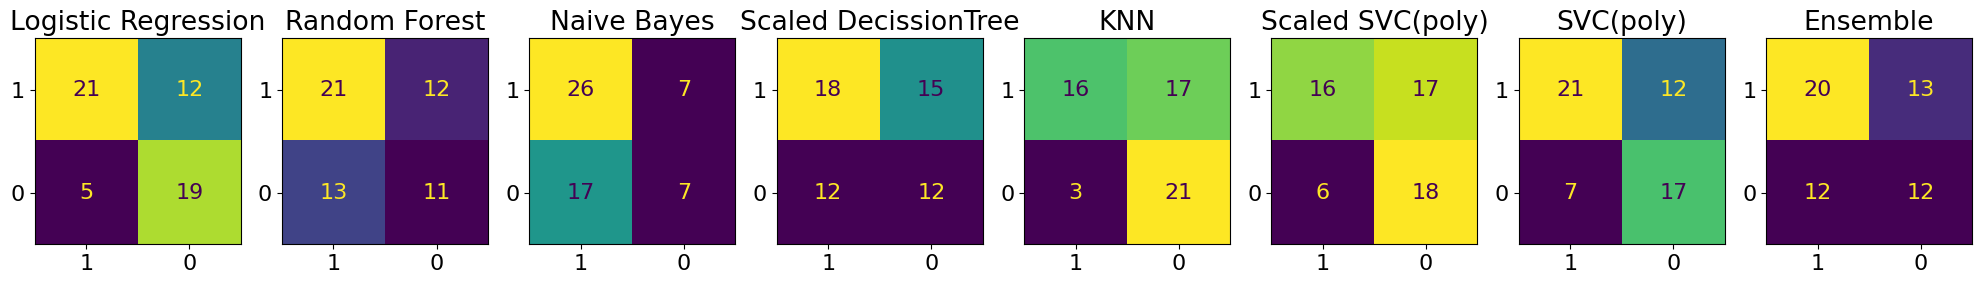

In [20]:
# Peak radial and circ strain per patient
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['radial_strain'].apply(lambda x: np.mean(list(x))).values).astype(np.float32).reshape((57,16))
x = np.max(x, axis=1)
x2 = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['circ_strain'].apply(lambda x: np.mean(list(x))).values).astype(np.float32).reshape((57,16))
x2 = np.min(x2, axis=1)
x = np.stack([x,x2], axis=1)
print(x.shape)
x = np.nan_to_num(x)
cross_validate_f1(x,y)

In [21]:
gs = create_grid_search()
gs = gs.fit(x, y)

/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/sklearn/met

In [27]:
# create a df from the gs results
results = pd.DataFrame.from_dict(gs.cv_results_)
results["params_str"] = results.params.apply(str)
pd.set_option('display.max_colwidth', None)
results.shape

(1620, 72)

In [28]:
results.sort_values(by=['rank_test_f1','rank_test_accuracy','rank_test_recall'])[['mean_test_f1','mean_test_recall', 'mean_test_accuracy', 'params_str']].head(5)

mean_test_f1  mean_test_recall  mean_test_accuracy  \
485       0.774216          0.938095            0.684848   
41        0.773739          0.938095            0.684848   
257       0.773739          0.938095            0.684848   
1133      0.773739          0.938095            0.684848   
1193      0.773739          0.938095            0.684848   

                                                                                                                                                 params_str  
485       {'clf': SVC(C=5, gamma=0.001, kernel='poly'), 'clf__C': 5, 'clf__class_weight': None, 'clf__gamma': 0.001, 'clf__kernel': 'poly', 'scaler': None}  
41       {'clf': SVC(C=5, gamma=0.001, kernel='poly'), 'clf__C': 0.1, 'clf__class_weight': None, 'clf__gamma': 0.01, 'clf__kernel': 'poly', 'scaler': None}  
257        {'clf': SVC(C=5, gamma=0.001, kernel='poly'), 'clf__C': 1, 'clf__class_weight': None, 'clf__gamma': 0.01, 'clf__kernel': 'poly', 'scaler': None}  
1133    {'clf': SVC(C=5, gamma=0.001, kernel='poly'), 'clf__C': 100, 'clf__class_weight': None, 'clf__gamma': 0.001, 'clf__kernel': 'poly', 'scaler': None}  
1193  {'clf': SVC(C=5, gamma=0.001, kernel='poly'), 'clf__C': 100, 'clf__class_weight': None, 'clf__gamma': 'scale', 'clf__kernel': 'poly', 'scaler': None}

In [29]:
results.sort_values(by=['rank_test_balanced_accuracy','rank_test_recall','rank_test_f1'])[['mean_test_accuracy','mean_test_f1','mean_test_recall', 'mean_test_accuracy', 'params_str']].head(5)

mean_test_accuracy  mean_test_f1  mean_test_recall  mean_test_accuracy  \
1318            0.718182      0.719307          0.633333            0.718182   
1426            0.740909      0.773027          0.761905            0.740909   
654             0.703030      0.698089          0.609524            0.703030   
666             0.703030      0.698089          0.609524            0.703030   
870             0.703030      0.698089          0.609524            0.703030   

                                                                                                                                                                   params_str  
1318  {'clf': SVC(C=5, gamma=0.001, kernel='poly'), 'clf__C': 100, 'clf__class_weight': 'balanced', 'clf__gamma': 'auto', 'clf__kernel': 'sigmoid', 'scaler': MinMaxScaler()}  
1426     {'clf': SVC(C=5, gamma=0.001, kernel='poly'), 'clf__C': 1000.0, 'clf__class_weight': None, 'clf__gamma': 'auto', 'clf__kernel': 'sigmoid', 'scaler': MinMaxScaler()}  
654      {'clf': SVC(C=5, gamma=0.001, kernel='poly'), 'clf__C': 5, 'clf__class_weight': 'balanced', 'clf__gamma': 'scale', 'clf__kernel': 'rbf', 'scaler': StandardScaler()}  
666       {'clf': SVC(C=5, gamma=0.001, kernel='poly'), 'clf__C': 5, 'clf__class_weight': 'balanced', 'clf__gamma': 'auto', 'clf__kernel': 'rbf', 'scaler': StandardScaler()}  
870     {'clf': SVC(C=5, gamma=0.001, kernel='poly'), 'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__gamma': 'scale', 'clf__kernel': 'rbf', 'scaler': StandardScaler()}

In [30]:
results.sort_values(by=['rank_test_roc_auc','rank_test_accuracy','rank_test_recall'])[['mean_test_roc_auc','mean_test_f1','mean_test_recall', 'mean_test_accuracy', 'params_str']].head(5)

mean_test_roc_auc  mean_test_f1  mean_test_recall  mean_test_accuracy  \
1337           0.748095      0.727311          0.842857            0.648485   
1330           0.747619      0.710985          0.876190            0.595455   
12             0.747143      0.676190          0.666667            0.628788   
13             0.747143      0.676190          0.666667            0.628788   
14             0.747143      0.676190          0.666667            0.628788   

                                                                                                                                                             params_str  
1337              {'clf': SVC(C=5, gamma=0.001, kernel='poly'), 'clf__C': 1000.0, 'clf__class_weight': None, 'clf__gamma': 0.01, 'clf__kernel': 'poly', 'scaler': None}  
1330  {'clf': SVC(C=5, gamma=0.001, kernel='poly'), 'clf__C': 1000.0, 'clf__class_weight': None, 'clf__gamma': 0.1, 'clf__kernel': 'sigmoid', 'scaler': MinMaxScaler()}  
12       {'clf': RandomForestClassifier(class_weight='balanced', random_state=1), 'clf__class_weight': 'balanced', 'clf__n_estimators': 10, 'scaler': StandardScaler()}  
13         {'clf': RandomForestClassifier(class_weight='balanced', random_state=1), 'clf__class_weight': 'balanced', 'clf__n_estimators': 10, 'scaler': MinMaxScaler()}  
14                   {'clf': RandomForestClassifier(class_weight='balanced', random_state=1), 'clf__class_weight': 'balanced', 'clf__n_estimators': 10, 'scaler': None}

## Evaluate best estimators from gridsearch CV

**Recall** in this context is also referred to as the true positive rate or sensitivity, and 

$\frac{tp}{tp+fn}$ 



**Precision** is also referred to as positive predictive value (PPV); other related measures used in classification include true negative rate and accuracy. True negative rate is also called specificity.

$\frac{tp}{tp+fp)}$



**Accuracy** (maybe missleading for imbalanced data.)

$\frac{tp+tn}{tp+tn+fp+fn}$



Specifity: 0.34 (+/- 0.12)
Sensitivity: 0.94 (+/- 0.08)
params: {'clf': SVC(C=5, gamma=0.001, kernel='poly'), 'clf__C': 5, 'clf__class_weight': None, 'clf__gamma': 0.001, 'clf__kernel': 'poly', 'scaler': None}
Recall: 0.94 (+/- 0.08)
Accuracy: 0.68 (+/- 0.10)
Precision: 0.66 (+/- 0.08)
Balanced Accuracy: 0.64 (+/- 0.10)
F1: 0.77 (+/- 0.08)
AUC: 0.64 (+/- 0.10)


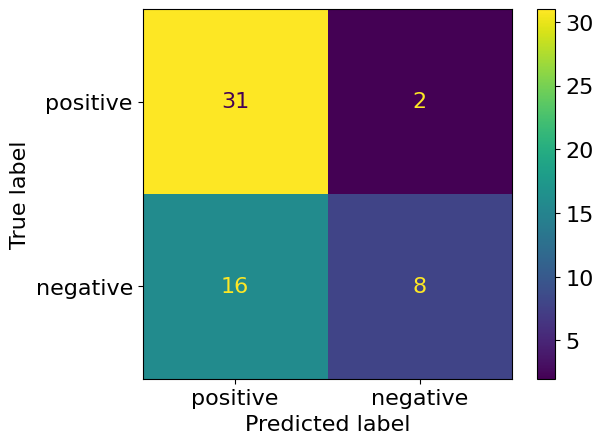

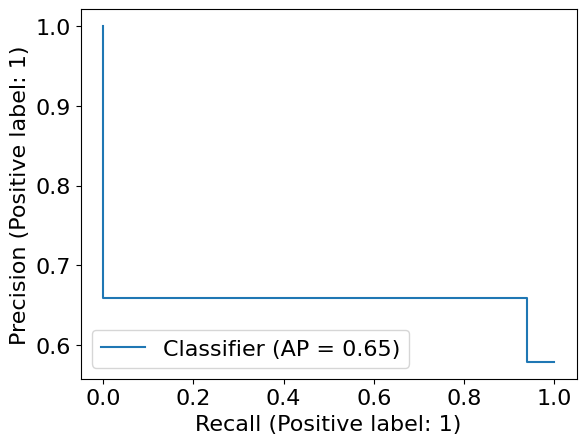

In [31]:
# use the parameters of the best classifier from the gridsearch and refit on data in CV manner 
plot_report(gs.best_estimator_, x, y, label=gs.best_params_)
plt.show()

(57, 16)
********** Logistic Regression **********
[0.42857143 0.85714286 0.66666667 0.33333333 0.57142857]
F1: 0.59 (+/- 0.12) [Logistic Regression]
Recall: 0.57 (+/- 0.18) [Logistic Regression]
Accuracy: 0.56 (+/- 0.07) [Logistic Regression]
********** Random Forest **********
[0.71428571 0.85714286 0.5        0.5        0.71428571]
F1: 0.63 (+/- 0.14) [Random Forest]
Recall: 0.66 (+/- 0.14) [Random Forest]
Accuracy: 0.55 (+/- 0.18) [Random Forest]
********** naive Bayes **********
[0.71428571 0.85714286 0.5        0.5        0.85714286]
F1: 0.68 (+/- 0.11) [naive Bayes]
Recall: 0.69 (+/- 0.16) [naive Bayes]
Accuracy: 0.62 (+/- 0.11) [naive Bayes]
********** scaled DecissionTree **********
[0.42857143 0.85714286 0.5        0.5        0.42857143]
F1: 0.58 (+/- 0.10) [scaled DecissionTree]
Recall: 0.54 (+/- 0.16) [scaled DecissionTree]
Accuracy: 0.57 (+/- 0.13) [scaled DecissionTree]
********** KNN **********
[0.85714286 0.42857143 0.5        0.5        0.42857143]
F1: 0.58 (+/- 0.12) 

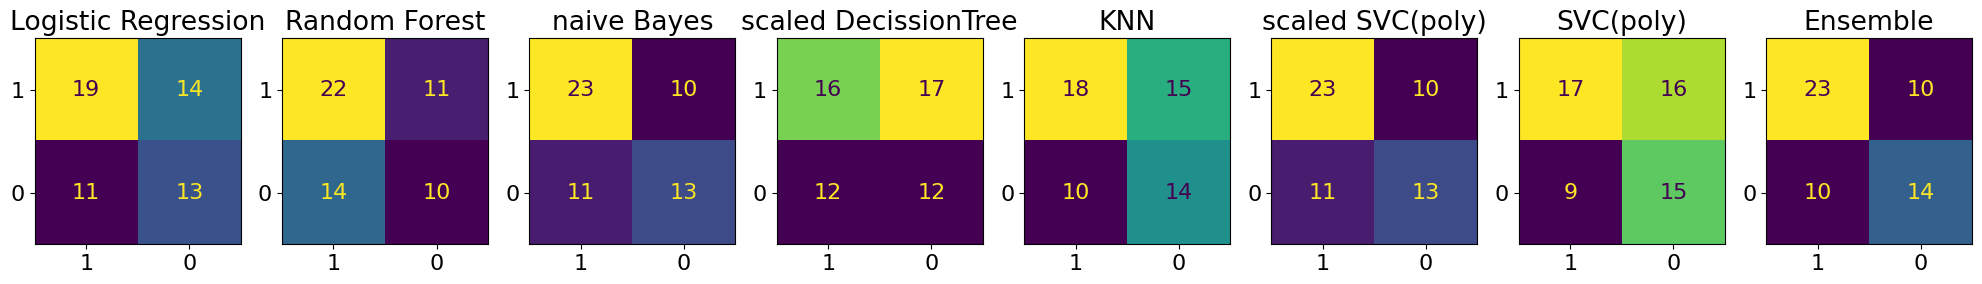

In [23]:
# Peak radial strain per patient or sliced phase strain
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['radial_strain'].apply(lambda x: np.mean(list(x))).values).astype(np.float32).reshape((57,16))
#x = np.max(x, axis=1)[:,None]
print(x.shape)
x = np.nan_to_num(x)
cross_validate_f1(x,y)

(57, 2)
********** Logistic Regression **********
[0.71428571 0.42857143 0.5        0.66666667 0.57142857]
F1: 0.58 (+/- 0.09) [Logistic Regression]
Recall: 0.58 (+/- 0.10) [Logistic Regression]
Accuracy: 0.52 (+/- 0.10) [Logistic Regression]
********** Random Forest **********
[0.71428571 0.42857143 0.5        0.66666667 0.85714286]
F1: 0.59 (+/- 0.09) [Random Forest]
Recall: 0.63 (+/- 0.15) [Random Forest]
Accuracy: 0.48 (+/- 0.11) [Random Forest]
********** naive Bayes **********
[1.         0.71428571 1.         0.66666667 0.71428571]
F1: 0.68 (+/- 0.06) [naive Bayes]
Recall: 0.82 (+/- 0.15) [naive Bayes]
Accuracy: 0.51 (+/- 0.06) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 0.28571429 0.5        0.66666667 0.71428571]
F1: 0.56 (+/- 0.11) [scaled DecissionTree]
Recall: 0.55 (+/- 0.15) [scaled DecissionTree]
Accuracy: 0.52 (+/- 0.05) [scaled DecissionTree]
********** KNN **********
[0.57142857 0.28571429 0.         0.66666667 0.14285714]
F1: 0.39 (+/- 0.25) [

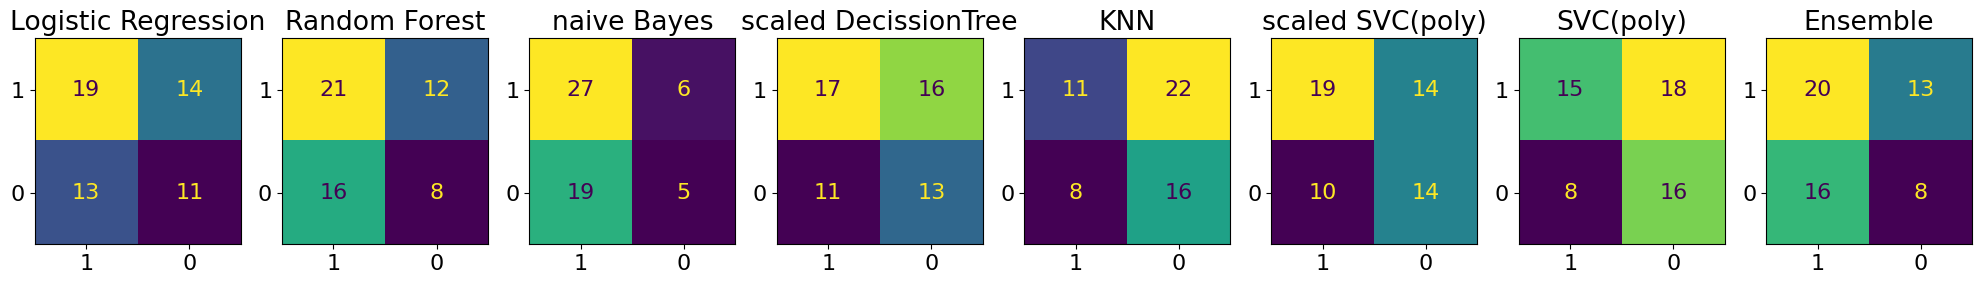

In [24]:
# Peak radial and circ strain per patient
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['radial_strain'].apply(lambda x: np.mean(list(x))).values).astype(np.float32).reshape((57,16))
x = np.max(x, axis=1)
x2 = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['circ_strain'].apply(lambda x: np.mean(list(x))).values).astype(np.float32).reshape((57,16))
x2 = np.min(x2, axis=1)
x = np.stack([x,x2], axis=1)
print(x.shape)
x = np.nan_to_num(x)
cross_validate_f1(x,y)

In [130]:
# Peak radial strain per segment
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['radial_strain'].apply(lambda x: max(list(x))).values).astype(np.float32).reshape((57,16))
print(x.shape)
x = np.nan_to_num(x)


(57, 16)


(57, 32)
********** Logistic Regression **********
[0.42857143 0.71428571 1.         0.33333333 1.        ]
F1: 0.70 (+/- 0.24) [Logistic Regression]
Recall: 0.70 (+/- 0.28) [Logistic Regression]
Accuracy: 0.68 (+/- 0.24) [Logistic Regression]
********** Random Forest **********
[0.71428571 0.71428571 0.5        0.5        0.71428571]
F1: 0.62 (+/- 0.12) [Random Forest]
Recall: 0.63 (+/- 0.10) [Random Forest]
Accuracy: 0.53 (+/- 0.17) [Random Forest]
********** naive Bayes **********
[0.57142857 0.71428571 0.5        0.66666667 0.71428571]
F1: 0.66 (+/- 0.08) [naive Bayes]
Recall: 0.63 (+/- 0.08) [naive Bayes]
Accuracy: 0.61 (+/- 0.12) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 0.42857143 0.33333333 0.5        0.57142857]
F1: 0.51 (+/- 0.10) [scaled DecissionTree]
Recall: 0.48 (+/- 0.09) [scaled DecissionTree]
Accuracy: 0.48 (+/- 0.11) [scaled DecissionTree]
********** KNN **********
[0.42857143 0.85714286 0.66666667 0.66666667 0.71428571]
F1: 0.73 (+/- 0.14) 

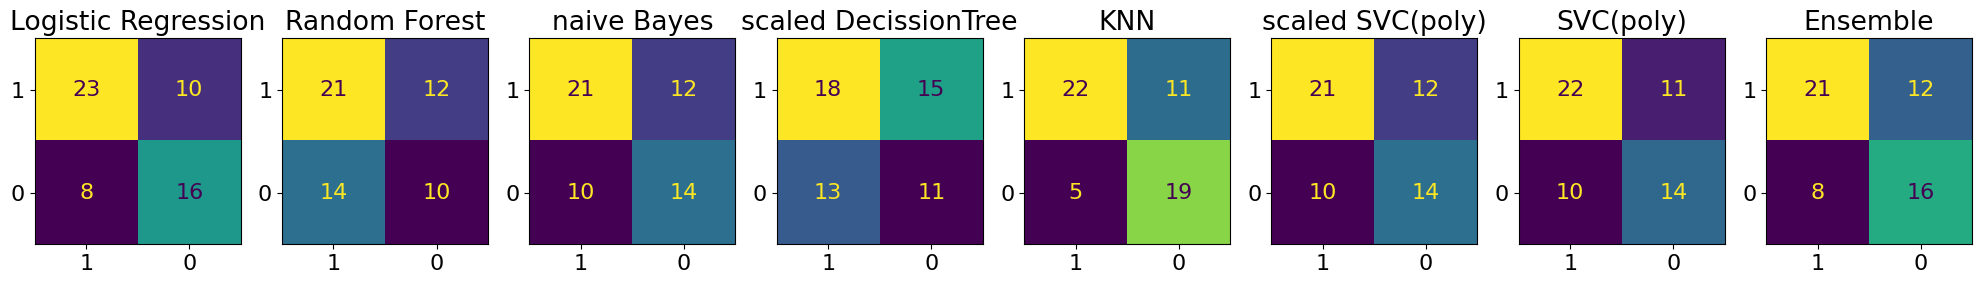

In [61]:
# Peak radial and circ strain per segment
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['radial_strain'].apply(lambda x: max(list(x))).values).astype(np.float32).reshape((57,16))
x2 = np.stack(df_merged.sort_values(['pat']).groupby(['pat','aha'])['circ_strain'].apply(lambda x: min(list(x))).values).astype(np.float32).reshape((57,16))
x = np.concatenate([x,x2], axis=1)
print(x.shape)
x = np.nan_to_num(x)
cross_validate_f1(x,y)

In [106]:
# radial strain per segment and frame 16 x 30
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat'])['radial_strain'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
print(x.shape)
x = np.nan_to_num(x)

(57, 480)


(57, 160)
********** Logistic Regression **********
[0.42857143 0.14285714 0.5        0.83333333 0.57142857]
F1: 0.47 (+/- 0.14) [Logistic Regression]
Recall: 0.50 (+/- 0.22) [Logistic Regression]
Accuracy: 0.41 (+/- 0.10) [Logistic Regression]
********** Random Forest **********
[0.57142857 0.85714286 1.         0.83333333 0.71428571]
F1: 0.69 (+/- 0.11) [Random Forest]
Recall: 0.80 (+/- 0.14) [Random Forest]
Accuracy: 0.54 (+/- 0.16) [Random Forest]
********** naive Bayes **********
[0.28571429 0.71428571 0.5        0.66666667 0.57142857]
F1: 0.55 (+/- 0.15) [naive Bayes]
Recall: 0.55 (+/- 0.15) [naive Bayes]
Accuracy: 0.49 (+/- 0.19) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 0.71428571 0.5        0.5        0.57142857]
F1: 0.58 (+/- 0.09) [scaled DecissionTree]
Recall: 0.57 (+/- 0.08) [scaled DecissionTree]
Accuracy: 0.52 (+/- 0.11) [scaled DecissionTree]
********** KNN **********
[0.42857143 0.42857143 0.66666667 0.5        0.57142857]
F1: 0.55 (+/- 0.08)

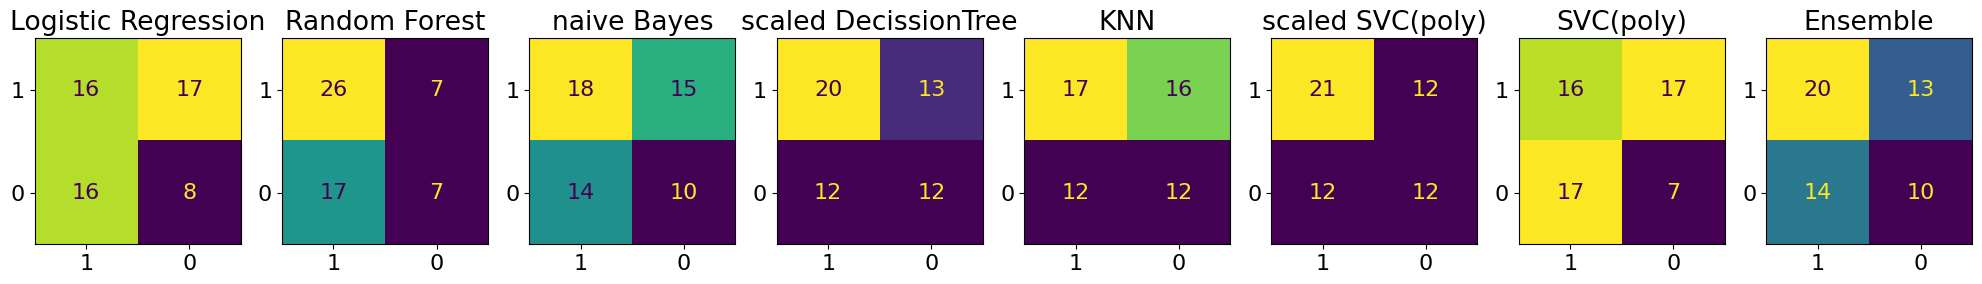

In [62]:
# radial and circ strain per segment and frame 16 x time x 2
x = np.stack(df_merged.sort_values(['pat']).groupby(['pat'])['radial_strain'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x2 = np.stack(df_merged.sort_values(['pat']).groupby(['pat'])['circ_strain'].apply(list).values).astype(np.float32) # 57 patient a 480 features (16 segments x 30 frames)
x = np.concatenate([x,x2], axis=1)
print(x.shape)
x = np.nan_to_num(x)
cross_validate_f1(x,y)

********** Logistic Regression **********
[0.42857143 0.57142857 0.83333333 0.66666667 0.57142857]
F1: 0.62 (+/- 0.10) [Logistic Regression]
Recall: 0.61 (+/- 0.13) [Logistic Regression]
Accuracy: 0.56 (+/- 0.11) [Logistic Regression]
********** Random Forest **********
[0.57142857 0.42857143 0.66666667 0.66666667 0.71428571]
F1: 0.61 (+/- 0.10) [Random Forest]
Recall: 0.61 (+/- 0.10) [Random Forest]
Accuracy: 0.54 (+/- 0.12) [Random Forest]
********** naive Bayes **********
[1.         0.71428571 1.         0.66666667 0.85714286]
F1: 0.67 (+/- 0.06) [naive Bayes]
Recall: 0.85 (+/- 0.14) [naive Bayes]
Accuracy: 0.46 (+/- 0.03) [naive Bayes]
********** scaled DecissionTree **********
[0.57142857 0.57142857 0.5        0.33333333 0.28571429]
F1: 0.50 (+/- 0.13) [scaled DecissionTree]
Recall: 0.45 (+/- 0.12) [scaled DecissionTree]
Accuracy: 0.49 (+/- 0.14) [scaled DecissionTree]
********** KNN **********
[0.57142857 0.42857143 0.33333333 0.33333333 0.28571429]
F1: 0.49 (+/- 0.09) [KNN]
Rec

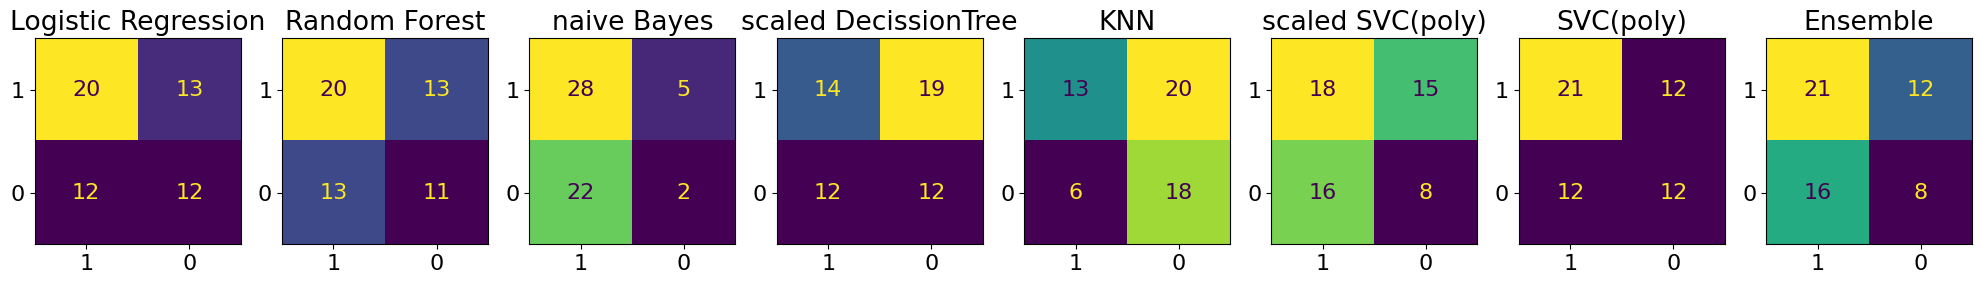

In [246]:
cross_validate_f1(x,y)